Lecture Notes: Basicm Image Processing

Before jumping to build powerful and intelligent models for visual recognition it is always important to look at some pixels. Looking at images and pixels and transforming them in various ways gives us often valuable intuitions on how to find things about images, and how to build the algorithms behind intelligent visual recognition systems. We will be using pytorch's Tensors to manipulate images as tensors, and the pillow (PIL) image processing library.

In [1]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
%matplotlib inline

In [2]:
# pytorch provides a function to convert PIL images to tensors.
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

# Read the image from file. Assuming it is in the same directory.
pil_image = Image.open('318.jpg')
rgb_image = pil2tensor(pil_image)

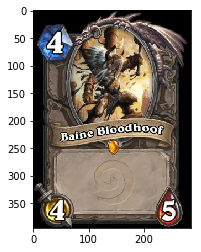

Image type: torch.FloatTensor
Image size: torch.Size([3, 395, 286])


In [3]:
# Plot the image here using matplotlib.
def plot_image(tensor):
    plt.figure()
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()
    
plot_image(rgb_image)

# Show the image tensor type and tensor size here.
print('Image type: ' + str(rgb_image.type()))
print('Image size: ' + str(rgb_image.size()))

### Image channels
We can slice the image into each R, G, and B channels and show them separately:

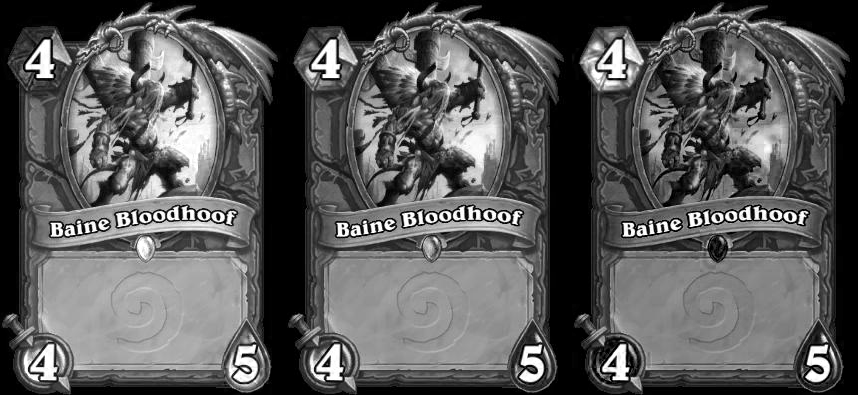

In [4]:
from io import BytesIO
import IPython.display

r_image = rgb_image[0]
g_image = rgb_image[1]
b_image = rgb_image[2]

def show_grayscale_image(tensor):
    # IPython.display can only show images from a file.
    # So we mock up an in-memory file to show it.
    # IPython.display needs a numpy array with channels first.
    # and it also has to be uint8 with values between 0 and 255.
    f = BytesIO()
    a = np.uint8(tensor.mul(255).numpy()) 
    Image.fromarray(a).save(f, 'png')
    IPython.display.display(IPython.display.Image(data = f.getvalue()))

# Cat concatenates tensors along a given dimension, we choose width here (1), instead of height (0).
show_grayscale_image(torch.cat((r_image, g_image, b_image), 1))

Each image in the above code is a one-channel image (e.g. grayscale image) corresponding to each RGB channel. You can clearly notice the Android figure looks brighter in the Green channel (the one in the middle).

We can try to enhance the green channel in the original image by multiplying this channel by a constant. (and making sure the values do not go above 1, or below 1):

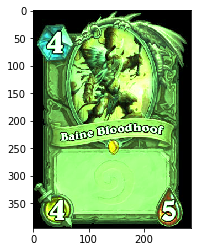

In [5]:
# We need to clone, otherwise both tensors would point to the same object, and we don't want to modify the
# original image as we want to keep working with it later. Always keep this in mind!
image_copy = rgb_image.clone()

# Multiply the green channel by two, clamp the values to the 0-1 range.
image_copy[1] = image_copy[1].mul(2.0).clamp(0.0, 1.0)

# Note: Alternatively we can accomplish the above with an in-place operations.
# Remember that in-place operations in pytorch end with _, not all operations support it.
# but often you want to prefer in-place as you don't need extra memory. See below:
#
# image_copy[1].mul_(2).clamp_(0, 1)
#

# Plot the image_copy.
plot_image(image_copy)
# Try, enhacing the other channels!

### Converting to Grayscale
How do we convert an RGB image to grayscale? A simple way would be to average all three RGB channels. Note the division by 3, since each channel has values between 0 and 1, we want to make sure the resulting grayscale image also has values between 0 and 1.

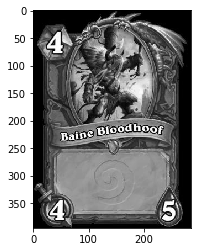

In [6]:
r_image = rgb_image[0]
g_image = rgb_image[1]
b_image = rgb_image[2]

grayscale_image = (r_image + g_image + b_image).div(3.0)

def plot_grayscale_image(tensor):
    plt.figure()
    plt.imshow(tensor.numpy(), cmap = 'gray')
    plt.show()
    
plot_grayscale_image(grayscale_image)

A better way to convert a color RGB image into a grayscale image is using a weighted average. For instance:

gray_image=0.4∗red_image+0.4∗green_image+0.2∗blue_image
 
Why? To reproduce better how most humans perceive the images. We do not have the same sensitivity for all three channels, the coefficients reflect this. We are considerbly less sensative to blue. Here is a more detailed exposition about this on wikipedia: https://en.wikipedia.org/wiki/Grayscale#Colorimetric_.28luminance-preserving.29_conversion_to_grayscale

### Other Color Spaces
In addition to RGB images, we can represent images as HSV, where each channel corresponds to Hue, Saturation and Value (~lightness) instead. Other color spaces include: HSV, Lab, YUV, etc. Sometimes representing an image in some of these other ways might be more beneficial for a given analysis. For instance if we want to focus only on Hue and Saturation but we do not care too much about Value. PIL has convenient operations to make this transformations.

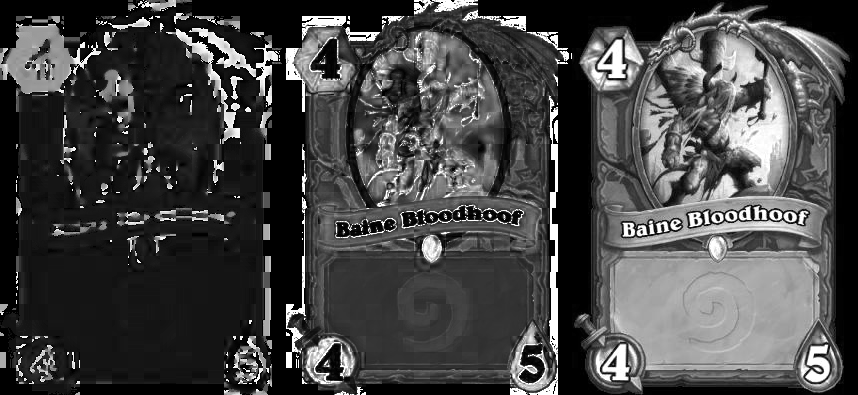

In [7]:
hsv_image = pil2tensor(pil_image.convert('HSV'))

h_image = hsv_image[0]
s_image = hsv_image[1]
v_image = hsv_image[2]

show_grayscale_image(torch.cat((h_image, s_image, v_image), 1))

Notice how the Hue channel tries to output a flat value for regions that are supposed to be the same color (e.g. t-shirts) regardless of luminance. The Saturation channel tries to output higher (brighter) values for regions that have more intense colors (e.g. the Android), and the value channel outputs something similar to the original image. You can also deduce that the RGB color space outputs roughly three different versions of "value" or "luminance". In practice, many modern machine learning and visual recognition models use RGB images directly, and do not take the extra step of converting to other channel spaces because the models are (in a way) robust enough to discover this information on their own.

### Brightness
Making an image brighter is achieved by multiplying the pixels in the image by a scalar bigger than 1 (making sure the values are still between 0 and 1). Conversely, if you multiply the pixels by a scalar between 0 and 1, you make the image darker.

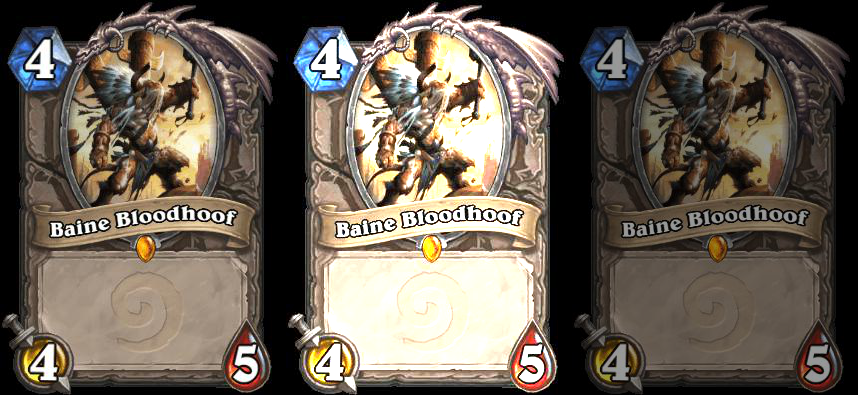

In [8]:
bright_rgb_image = rgb_image.clone()
dark_rgb_image = rgb_image.clone()

# Multiply all elements in the image by 1.8, and then clamp values between 0 and 1.
bright_rgb_image.mul_(1.8).clamp_(0, 1)

# Multiply all elements in the image by 0.6, and then clamp values between 0 and 1.
dark_rgb_image.mul_(0.6).clamp_(0, 1)

def show_image(tensor):
    f = BytesIO()
    a = np.uint8(tensor.mul(255).numpy().transpose(1, 2, 0)) 
    Image.fromarray(a).save(f, 'png')
    IPython.display.display(IPython.display.Image(data = f.getvalue()))

# Since these are color images (0: channels, 1: height, 2: width), we need to concat in the 2nd dimension. 
show_image(torch.cat((rgb_image, bright_rgb_image, dark_rgb_image), 2))

We could also write three for-loops that go along each dimension of the rgb_image tensor and multiply each value by 1.8. However, modifying each pixel intensity one by one using these three for loops is slow. The efficient way to do this would be to program the three for loops in a lower level language like C/C++. Fortunately pytorch has many efficient tensor operations implemented in C/C++. This means that if we can find a way to implement the above code using functions provided by pytorch we not need to write any C/C++ to obtain good performance. This is why you need to know all the basic tensor operations such as mul, clamp, or div.

Moreover, if you have a CUDA-capable GPU in your computer. You can move the tensor to the GPU memory by calling rgb_image = rgb_image.cuda(), then without any extra effort, the operations on this tensor will be executed on the GPU. (Note: You need to install pytorch with GPU support if you want to do this).

### Histograms
Histograms are useful because while images can be of different sizes, but histograms can be computed to be of the same size regardless of the image sizes. Additionally we can normalize histograms so they sum to 1, or their  ℓ2  norm is 1 (euclidean norm, Frobenius norm in matrices).

/home/hinova/anaconda3/envs/sagan/lib/python3.5/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


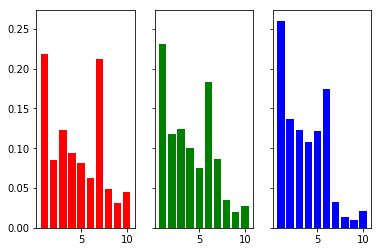

In [9]:
r_image = rgb_image[0]
g_image = rgb_image[1]
b_image = rgb_image[2]

# Compute histograms for each channel.
hist_r = torch.histc(r_image, bins = 10, min = 0.0, max = 1.0)
hist_g = torch.histc(g_image, bins = 10, min = 0.0, max = 1.0)
hist_b = torch.histc(b_image, bins = 10, min = 0.0, max = 1.0)

# Normalize the histograms so that they sum to 1.
hist_r = hist_r.div(hist_r.sum())
hist_g = hist_g.div(hist_g.sum())
hist_b = hist_b.div(hist_b.sum())

# Plot the histograms.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True)
ax1.bar(np.linspace(1.0, 10.0, num = 10), hist_r.numpy(), color='r')
ax2.bar(np.linspace(1.0, 10.0, num = 10), hist_g.numpy(), color='g')
ax3.bar(np.linspace(1.0, 10.0, num = 10), hist_b.numpy(), color='b')
fig.show();

### Convolutions
Let's assume a grayscale image (single channel). A convolution is a function that takes an input 2D image  I(x,y)  and outputs a filtered imaged  I′(x,y)  such that  I′(x,y)=f(neighborhood of I(x,y)) . This means that in order to compute the value of the output pixel  I′(x,y)  we will need not only the input pixel value  I(x,y)  (as we did for brightness) but also its neighboring pixel values. This is not a strict definition but this is the basic idea.

Most convolution operations we will be using during the course will use an  nxn  number of neighboring pixels, and will be of the form:

I′(u,v)=∑i=0n−1∑j=0n−1wi,jI(u−⌊n/2⌋+i,v−⌊n/2⌋+j)+b
 
For the purpose of this lab tutorial  b  will be zero, so the only parameters of our convolution operations will be the size of our neighborhood region  n  and the weights  wi,j . Moreover, for the first few examples here the neighborhod size will be  3x3 , thus we will be dealing with the following operation to compute the output pixels  I′(u,v) . 

I′(u,v)=w0,0I(u−1,v−1)w1,0I(u,v−1)w2,0I(u+1,v−1)+++w0,1I(u−1,v)w1,1I(u,v)w2,1I(u+1,v)+++w0,2I(u−1,v+1)+w1,2I(u,v+1)+w2,2I(u+1,v+1)+

We are effectively computing a sliding window as illustrated here:


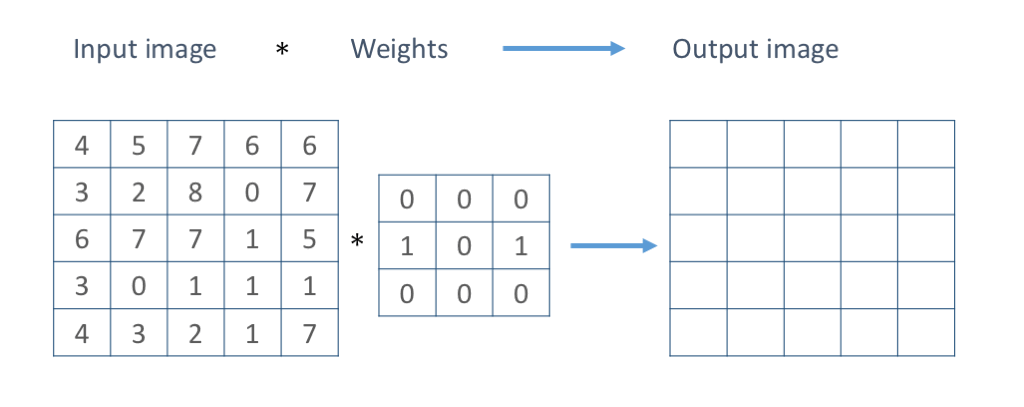

In practice, there are various ways of making the convolution operations faster by realizing that some computations are shared by consecutive windows, or by sacrificing memory and expressing the convolution as a single matrix multiplication, GPU acceleration is also possible and fortunately all of these are already implemented in pytorch. Convolutions are essential to obtain information from images as well as to apply many common effects to images like blurring, sharpening, etc. In pytorch we can use F.conv2d function to an input image.

Most image processing libraries implement a convolution operation, they are also referred to as image filtering operations in some libraries including PIL (see here http://pillow.readthedocs.io/en/3.4.x/reference/ImageFilter.html). However, here we will use pytorch's convolution operation. First we will run a convolution on the red channel of the image using a kernel of size 3x3 where all the entries are 1.0 / 9.0.

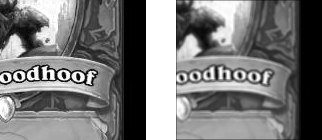

In [10]:
# The input is just a section of the red channel image.
# We will take the pixels between rows 140:280 and columns 140:500.
input_image = r_image[140:280, 140:500]

# The kernel is a 3x3 matrix that computes the average around the pixel.
kv = 1.0 / 9.0
blur_weights = torch.Tensor([[kv, kv, kv],
                        [kv, kv, kv],
                        [kv, kv, kv]])

# This is a hack, do not worry about the details of this implementation. 
# We will learn the meaning of nn.functional, and autograd.Variable later in the class.
# The reason for unsqueezes is because the F.conv2d function is very general, and works
# for multiple images at a time, and multiple channels, and for multiple kernels at a time.
def SingleChannelConvolution(input_image, kernel):
    import torch.nn.functional as F
    from torch.autograd import Variable
    output = F.conv2d(Variable(input_image.unsqueeze(0).unsqueeze(0)), 
                      Variable(kernel.unsqueeze(0).unsqueeze(0)), padding = 1)
    return output.data.squeeze()

# Execute the convolution operation
output = SingleChannelConvolution(input_image, blur_weights)

# Display the output.
padder = torch.ones(input_image.size(0), 30) # Just to leave some space between images.
show_grayscale_image(torch.cat((input_image, padder, output), 1))

Now here are other filters that highlight vertical and horizontal edges in the input. These are also sometimes referred to as Sobel operators, and they are also finite differences that approximate the gradients of the image (This is the equivalent to taking a derivative of a function, except that here we have 2D functions in the discrete domain).

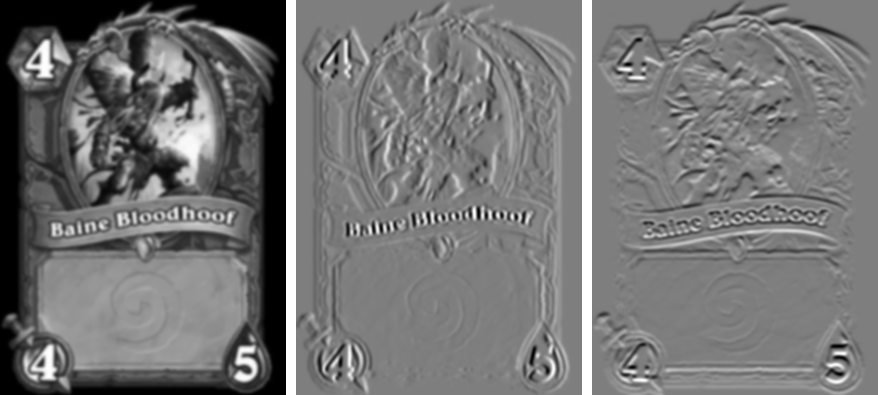

In [11]:
# The input is the green channel image after a few rounds of blurring.
input_image = SingleChannelConvolution(g_image, blur_weights)
input_image = SingleChannelConvolution(input_image, blur_weights)
input_image = SingleChannelConvolution(input_image, blur_weights)

# The kernel is a 3x3 matrix that computes the Sobel operator.
# See https://en.wikipedia.org/wiki/Sobel_operator
weights = torch.Tensor([[1.0, 0.0, -1.0],
                        [2.0, 0.0, -2.0],
                        [1.0, 0.0, -1.0]])

# Execute the convolution operation for the weights and transposed weights.
output1 = SingleChannelConvolution(input_image, weights)
output2 = SingleChannelConvolution(input_image, weights.t())

# Make sure the images are still between 0 and 1.
output1 = (output1 - output1.min()).div(output1.max() - output1.min())
output2 = (output2 - output2.min()).div(output2.max() - output2.min())

# Display the output.
padder = torch.ones(input_image.size(0), 10) # Just to leave some space between images.
show_grayscale_image(torch.cat((input_image, padder, output1, padder, output2), 1))

We could also apply convolutions channel by channel and reconstruct the original image by merging the outputs for each convolution. We could also apply a different kernel to each channel. In fact the kernel matrix could also be an image itself. We will illustrate this below.

output1 torch.Size([1, 370, 265])
output2 torch.Size([1, 370, 265])
output3 torch.Size([1, 370, 265])
output torch.Size([3, 370, 265])
rgb_image torch.Size([3, 395, 286])


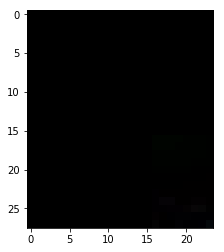

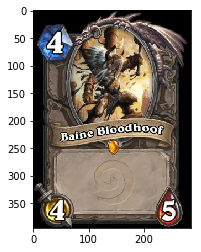

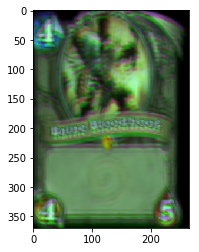

In [12]:
# Crop a patch from the image itself to use as convolutional filters.
kernel_patch = rgb_image[:, 0:28, 0:24]

output1 = SingleChannelConvolution(rgb_image[0], kernel_patch[0])
output2 = SingleChannelConvolution(rgb_image[1], kernel_patch[1])
output3 = SingleChannelConvolution(rgb_image[2], kernel_patch[2])

# Remember that unsqueeze adds a dummy dimension at the beginning of the tensor.
print('output1', output1.unsqueeze(0).size()) 
print('output2', output2.unsqueeze(0).size())
print('output3', output3.unsqueeze(0).size())

output_image = torch.cat((output1.unsqueeze(0), 
                          output2.unsqueeze(0),
                          output3.unsqueeze(0)), 0)

output_image = (output_image - output_image.min()) / (output_image.max() - output_image.min())

print('output', output_image.size())
print('rgb_image', rgb_image.size())

plot_image(kernel_patch)
plot_image(rgb_image)
plot_image(output_image)

Here is another example. Here we pick a patch from the leg of a person and we convolve this patch with the original image. By now you probably already guessed that filtering (or convolving) the image with a given patch enhances the parts of the image that are similar to the given filter (weight matrix).

### Attention score matrix

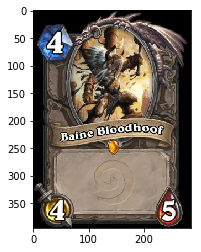

Image type: torch.FloatTensor
Image size: torch.Size([3, 395, 286])


In [13]:
plot_image(rgb_image)

# Show the image tensor type and tensor size here.
print('Image type: ' + str(rgb_image.type()))
print('Image size: ' + str(rgb_image.size()))

In [14]:
# m = Normal(torch.tensor([0.0]), torch.tensor([1.0]))data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMkAAAD8CAYAAADdcYAbAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4wLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvqOYd8AAAIABJREFUeJzsnXeYXVd5r9+16zn79DK9V426ZEnGkrsNjulgwLQQamgXggMJGEK4kOSS3FBCLgQCXCAESOwQMI4L2DQ3Wb1bbTTSFE0vp7fd7x9n5BYSO2AR8NXveeY5ZdZZa++11re+/m3h+z4XcAEX8B9D+u++gAu4gN90XCCSC7iAp8AFIrmAC3gKXCCSC7iAp8AFIrmAC3gKXCCSC7iAp8B5IxIhxPVCiJNCiBEhxM3na5wLuIDzDXE+/CRCCBkYBp4HTAJ7gNf6vn/sGR/sAi7gPON8cZKLgRHf98/4vm8BtwAvPU9jXcAFnFco56nfNuDs4z5PAs/5jxoLIS64/Z8mBPDkyRJC4Ps+CFFv4Pm/uOFTdi7gaUgWj473249F3/cbnqrR+SIS8Qu+e8KsCiHeDrz9PI3/rIUkCzzXR5EVXNfFx0f1fSRJYXD1CiRV4dSpU5RLFQBUAfaTO/ElBCAQCCHAB0928D0fRZMRQmCbDqoqY9vuoz9TFAXP8/A879d2v+cZ40+n0fkikkmg43Gf24Hpxzfwff8rwFfgAif5T/H448YH1/XRFBXbsZGERDAQZG1bO6FYlHRrKxPTM/imi+xLCOT60STcX8hVfHzwQRESwl1mPpaLD0SDKpWq/YQN4rpunagAWZZxXfffd/osxPkikj3AgBCiB5gCXgO87jyN9SzHstr46Cb36gQCrBlaSWNjI1v6enjFq1/Dp7/weYaHh3EdH4SC60vAk0Uo71G6k/Hx8UBAOqjT1NSEbdvIskxHRweFcolkMkksFkOWZUwlgOd5/OAHP8BxnF/XBPy347wQie/7jhDiPcA9gAx83ff9o+djrGcDJEnC8zxUVSWVSjE7O/sEuV8ICd93ENRJJqCqrFuzinVr1jI4OEhnQ5K/++qXODJ8jKVivs4SZB1cF5AQvocqZABc3yMUMKjUKqwc6MMwDHzXozUeJxKL0t7ejmEYpJsaaW5pYc+ePQyfHsG2bRarNiMjI1iW9d81Vf8tOF+cBN/37wbuPl/9P5twTsaXJInZ2VkURXnspPbB9x0USUb4Lr4Pnm3T3NDAyoE+WpobOXBwL5l8huMnTyNk8AXg2dQ/eIQ0jZpVA0AXErVahXVDg7S1tqJpCr7v09/WSf/gAAMDA+hGkJmZGW677TbmFhdQdY1iscjZ2SXy+Ty+7z8qdv3/gPNGJBfw1HgitxCYpslVV13FfffdhyzXFWhZAsfykDy3ziCAG1/+IrZu2cxzLt6CaZrs3F6mMZ1EBoQHLuDj0d/bQVO6ATtfQtd1yuUyvu+xccMaApqCYQQJhUKsXbOK9vZBTo+O8rd/90XK5TLhWJSxsxNMzc6QzRfxlvt98nX//4ALRPLfiHMn8rkN193dzXOe8xwymQyHDx8GQJYgrCs0pVMENIXnP+9aVg4OcN01V/O3n/0MQggWZzLE4nFecd1VqMEAiqKg6zqGpoPnUyzViEajTE2fJZWI09rWQl9PB/F4FNsyyWYzfPWb32J2dhbLsRmdnGZs126EIuF6HkKW8ISH5NfFwidf97Md58Xj/l++iAvWLWKxGF/72tf45Cc/yf79+wHo7+9nXX8viiy47rnXENBUhvp6WL96iL07d6LIglwux+zZHFc/91qmZqdBljh9+hSpRILerk4MPcCxiWkuWr+BHTu2E4mGObB/N5IERkClVCoxOnqaR87WEEKw78B+irUyLiAkCU8A/rLJ16uLhL7vP1sIZJ/v+5ufqtFvD5EowOPN8z6P2vvrkICntrj40nJbT17+jbfcmfPLOeD+A0jLRiVJAtcHTZOwrLolSZLBcwFPQZYFsmvzJ+9/Lw2JGLffdjtNLc0gVN70prfQ1xbGNE3MmsP8/DyFQgXb8piZmaNYKKNpGmOzU+TzeUzLAiTm5+cJhgzC4TBr16xj6xUbqVQqlIt5HMeip6uXyclpRk6eYWFhiZnpBaYrNR45epyyaeP5EIpGKRdyyLioOChA7XFT7yHhs2w9Q0INBLBrFo95ZTweXTAB/9EKP/q1eNLrr8cV8ywjkscH0Pj1P/Gkf7lPV5f0z/1K5rFlemZNmuf8CIqi4D7OXCot06UkgeOD5MOH/+hdrB7oY9+unVx7zTUMDAwwNj7F+MQkiwszzM7OE43EASgWKyiyhmnaLC4u4fs+Dj65XBbHshgcHKSxsZHNF23k1ltvpVKpIIRNY2OamZkZ2ttbGRoaIp8vks+VaGlp44H7H+aB/Xso1cxlvUNCVlTwHDatX4Pqe6TSCeYWlghFwlTKNUqVMoFQCN/3OTk8QqlcQVZUXMdGUzVq9mMWsH+3uE9nnX492/JpEclvj07i/+L3Tww+e+pQNOE/dkT5j3b0zB9brldXcB2nbrpVpboMr8oSLh5DA/0cPTnChnW9pFMxujrasMqr0XWNHTsexvV8lhYXKVRMFrMFMvkKqqpSLpmoqoYQMsWKhed5WI5JoVSiIZWmp6eHa6+9mlQiyeLSPLf80z/TmEpyw0tvYMeO7Txy9DCxSIS+gRU8//pNNDY2c3ZihuGpURaXsuRKFRKJGG1tbbi2SVM6iVMrEzJ0rrjsEkqlErOzsyxlBabtEAwGWbd6EHwJ13UZPnmacs1ElxQcz8V9wsKdW5/fLo/9bw8nOdf2SZ8fTxZPh5MoyyPVRYZ6D/WvvGdU3Dp3ZfF4lKgRYnFmht7eXlqbGknEYhQKBVpaE0SjUS7esomujjZmpqYZGxujXC5z+vQolmVRlgIUiyV8bzmEBIlq1USRNWq1Gp7nUauUGBjo46MfvpnTp04wOzPF3NQko2dO8YbXvZ6R4yO87wN/SCGT4XOf/xuOHTsGksAIx1i/fiNr167n77/+95i2haqqaJpGU1MTrS3NdHe0s2b1SjRFpW9oBccfeYTJyUn27dvH6PgYAd1AlmU6OzupVqvML1XqxDJymh2791CxLdxH53h5tSTnsTnyHz/nj1/NX4uz8tklbqmyhuPWWbgkJLzHcQRVFdi2j3yuPx6bd0nU4/3OwUdClVVM10YSIOT6wjiO86hT75mCAFb09zE+coYrr7gMWUi0NTWxaeNGxkfHUDSZLVu2cOedd9PR0cHM3Bxzc3OUy2Usq84l8j6YpkmtVsO2XWS5Hk8lhECW63cs4/OlL36Bo4cPccft38e1TDILM/zu615HJGywbfNVHD9+FE1TSKZixJMxBgZWcOfdP2TXrj2oqs4b3vw6BgYGyOUypJJJivkcsXiEv/s/n0fTNGZmZpAUjYWFBdauXUt7RysveOlLOXrwIN3d3YyMjDAyMsJtt93DUiZDrlhien6BbK5I1XXq6yEUPHyMWJByoYSuB7BtG1XRMWsWYvkIVGUVy608Y+vwn+DZRSQC6s4xWLasSCiqiuM8Fr4n+0/c4I3pRlpbW7FtG0mSEEJQdnRkGVy7SiY7x+LCHMAzQiDnxnBdFwVYNdhPf28vsiQRj4SRhGD4+DF0TWN+fp6ezgGQBJFokqV8gXy5LlLZts3C3CyWXUOK6LS0tNDZ0U0kEqGtrY2FhQUSiQSWZVEqlTh96hSOZXL0yCH6e3tJJePMz07zg+9/j89++lMUsiaKIpPP5/F8i0jE4OUvexmtLW1MTk7z2U99lu6V/bz6Va8gGgqiqiqq8Ni1axeVSoUTw6dQFIWxqTlkWSYZTxAKGVy8ZQsNDQ3Mz89yw0tfxre+9S1cIRMMBqmaNSYmp9l78BDZfI5KuYbjuQyfGQcB8Xh4+TDwEZKM6/kosoazHB/m+b8Wr/6zi0gQIMsarusSS6QJhsLEk414rg/ScrCdrz66URVFQZZlVLX+Xf0EttGCCVTZRZZtps8Ok88tsTg/i2fX2fuvMhvnCE2SJOKyx7p1a7nqiitZXJzHMAxGTp+io7WNd7/7nZRKJXBkPHw+9bkvML2Qoea4lMtlotEoV191GQODfdi2TXt7G47jUCwWmZiYoFgsUq1WCYfDaJrGPffcS1d7O9deey39/f3UajU+/38+x+DgILt27cIwkthWjYWFOfAt3vamN/LG17+eQwcOISOYnpzhm9/7PitXrGCorxPbrKGrCq5tEo0n2XfoCEtLS0xna9TKFVRVplYtY+gBGpsaGOwf4NSpk2zYsIH3vK9+b+Pj4xQr5bqp2TDIZDLkiwUKhQITo5OMnDlNoVBiam6e4ydGcABfyDje+dMTfwGeZYq7ELhe3ZdshEO0tvcgyRrFUg1JkgiFAph+/RSUZRlFUTAM41EuoigKlmWRzxXRNQ9Vsmlp66BWLREKhSjm8kg85lX+VRAKhVjRliYSDBAJBbHNMEePHgFg8+aLaG1rZm5hgUQohiSrvPrVr+QPPvQhFD3E2vVr6O3poau/CyH7DHb1UCgUOHLkCGNjY4yOjgJ1h14gUHcczs1M0tyYYnh4mFOnTrFhwwZkRUNWNJqaW7no4m0cPnwQIxZi9NRJqmaNf7rlnzG0ILFwBF3XSSUbOH78BMJ1kDybrvYWAoEA9z3wIELWyOZKBAJJqjUHRQsSkDR832VqZp7MUp5AQGP79p284MXXMTg4SKlUQNMUbMckFgsRDQeAVhYXFxjo6Kano4PZ+XlOj0+gyBpj01MsZPLLa82vy7r1tPDbw0lUAa5A1oIMDq0GodHa1sP42WkqlRqaHiTetgbP8ygUCvi+jyRJ6LqOZVnIsly3BJULhAxwzQzvfPvrue1fvs3c1CQjJ4fRFZma88uTyTlOsnLlSjqCEh/96EfZvXcXr3nNa/iDm97LDTfcQLFSBODIkSO41Qqt7R1su/p5JJrbmMtmEUKQy2XYuWM7E+NjuEWLUCiEqqosLS1w5swZhBCUykUSiQThcBhF1lm7di1GOEKpVEJWdQqFAnfedTevfOUrEVqIvt5uRs+MMHN2lO/+07f40E1/yMMPbEdGsHJgiKbBddz3s5+worcTu1pi1WA/kiTR3t1LvlxjZnaOR0YXWVycR/LBCOpUykXampuxHRNVliiXyzh+jlgsRiCgsWXTRt75vvdQmK8HbGqqjO/7WHmHfLlCc1srB48cZWx6jvGZGR7csYv9hw6ytJSlWv7N0Ul+eziJrQAKHa19qCJMqWIzOT5LUA+hhQ18SSD7FRwpSmPPc1D0KLbj49YKBMvTYC8RUAR5GwxdZdO2q8hnCwhkytUqsiywHffpmfAlnnDSCb9ul9Ekj40b15JOpnCrVXoHuzl4ZCeq8JAslfFTC1RrFsNjJ1hYmsHSWzk2eYaf3/+XfOTmP2bi7BTfv/1OLMsiZai0N8Tw0gJJUbn9hz8lk60QiYUwNI2A5xO0a/g5E02VEdMKluSRSLURDDXw0P59XHXlFWjCZs++n+HW1tLa1Ep7ajO/93tvR0gaAxdfxnwmS3jlKk6fHsaXfE5PTBPQdNaHG5icGidbOcLadUN096xkbuEemiNxbNPCqlpIRhTPqyKAmmVSNWuEE+3UHBg+eprDxya4f8dh3v2u32fd+jWIoEa1UkGNWIQ0n3xpiWhU5Zru9SwutrF1dTdjY3Uz84/v38Xo+FlODp/GrKe9ICsqviTjOB54j1m/ZEleljIeb95/5iB//OMffwa7++XwiU984ikvQpUl2js7iSUSVC2XSCROuVpFVSWS8Si2VcLEwPE1YokmFEUG38FQbZzyHMJcolxcRJZdpibP8PtvfysT46Ns3ryR3p4+bMthdmYG1/8vyMI+j4avC2DdqpX09/USDofZvH4t4XCQ8fEzyIrKrt1HmJ5dxHQF89klSrUKtgutTUmuvWor3/72N3jtG97A/oP7Wb1yiIa4gWMVcZEZPzvD9NwCjucQDkeQgKgRIBTQUBSJuHDpaDRIGj4NDUFU2WbjhjV0taaJqoL2nk7CAQ2zVmJxboZdOx7mHe94G+FIkIXFOQKGRiwSJxqNc/zEMJ4PVdMiFomwuJihZtYYHZ0gEAxyxeWX0d/dDZ5PPpcjFgkjqwq+71GtVZhfyFMo5Onv70dTNWZnpnl4x8PcccddpNONrNmyhczMFLKikEqmUGSFpaUMtVqVRCJBMpkgnU4xsGKInq5OWlqaUBSJqGGwlMnguQ6+7yIJ+VHrnufXoyWe4L1/eo7lmY9//ONfeapGvzXilgys3bgFX9JJNHQxu1hE+B6F3CKaKpFMRHCNQaqORDDaiKxqGEENMz/Jvu1341VmCeoKlVKJ93zoQ6wYGuL48eOsX7eWUFDnLz72UU4cOQLiadjnl6/28QQSUAT3//w+jh09QjKZhFqNltY037/tVkpFk6Wsw9xcjqViiapvYtolVq3oB6tGLADT09NcfNnVdPf18e1vfoPrr7qYsOpy74OHOPjICSQ9RKVmETEiKMIjYSgYqoyuyFzU3oDmL9LZESKUipNoaWd8vkoi2Ylb88gpMrVKFSEEt99+B5s3PYfJmXnWrL+INes3kC9V+dmD+7CqFtWKSWYxy9mxCVqbmlCFx2B/L7Vqmb7+NlqaWmhuaOT0yWGKxTLZbBYPCUlXOXb8OI4cxXUdyuUyhhGgvaOVkyePY1k1wuEwl162jT//+IfJ57NMjI7huBZrVq3EdRz27duLWakSjhg4nsBHwnF9To+NUy6X2X/gMKdHxxk/O8F8ofq4DbScV/Zkwnjqrf20xK3fmuJ0sZiB5biouoHlySAH8CQNLWjgeT7VahXDMNAUGd+p4lpFFK/CyWP78a08qmTj2SUkQ+bIob2UKyUi8Rhj4xOMn52moakNLRh+2tdzjkDO4aKLLuLkiRNs3bqVS7ZczAte/nJ0XUcIQaFQoFQq4QnIFUoUS2VsH0ZOHcf3bJYWF9i2bRsHDhxAUxUkGRTJJ2SozC8tYbs+tZqFpgVQdI1AILCs/zh1c6nnEQ6HCQQVwhGdVDJCMhEmoEAspBHSwNAhKPtctGaQiCFz8cbV3PfTH7F754P0dLeyadNGPOGRamygu7cHSVXI5vLk8mXm5zIUilWELLOUzTA/P1+3HMoSiUQCwwiQjEVJJmLI1NOBm9INOJbFxMQEAwMrSCQaKJUqHDz0CHf/8EfEokkaW1rJLOWYmJgkGAwyNDREIKhRqVSYn5lhbnYKVYGejlZ6OjtYs3qIztYmBnt7iBjBR/1i0i/iGs9gustvJCd5vMn2nDLc09tPON1DINpI1YtTrHnEw0Gs4iySV2V+epTGjo2EojF8JFzXZnbqDG5tjod/dju9XQ2UCzkmFhdZt2kb733/RwhFUiwsLGIEghiq4It/+zcUlsZwnbrIJaTHAmARIEn1IgxhXadaMx+N/JKBz3/us2zasJFPfPxjZLNZfMthYLCb/oFOcvkqJ09NMzOXYz5fRItoDK7up1G3CGgylUyWnr5+dh08xpVXX8HBfTt57iWrKC+e5W++dR/lmg1KEEVTkRBoeHjVPJGAQjgYoEFTufEll6BKGdp622jq6CJXk6iWBVbZpLbsc/A8j3K5TLlqUqzYlC1wXEHZ8gg39bHxoou5464fkc0UCQTC7Nu9l4BQaE43EAoaqIEqESOErqiUsnlSiQS6rjM0NMTpsdNEolGOnJggs5TDiIQxbYtCoUC5WkWSJBKpJIVCAbNWYMvFm3ntja9i/bpV3PPDO/Fck+uuvYpYLMK+ffs49shRLMtCUlQUWSMQCqHIGpblcODgYY6OTZLJZNiz/9BjoZQygITvLUdPPLXk/NuruJ+ryHEuSDAYDBJJ9eAb7dREnCIJutasQXKr5GaO4VslQkmf8VOH6O3vo7evh5mZOaZP7eaOu75Hb1czViVLKGqgZSQcyyYSTeNrUVq70li1Kq3pCJdecRUHHrqTUChErVZDluvWGFVVKZfLBAKBun9CDyFJEpIPAo9kPIHkw6te8UqGBvuplsok4ylWrBgiGgvS1RVndq7A7Owi8XCQmcwMifAq2pIRZOEzvrRIY0ML09M/paerm1PHDtPSmGK2Mo3peqCquK6PbVroiooi6pyjKR5B1xRa0kkOHjvFir4k7UoESYkSCIJtVQjGVCKWh+s5OI6HbDoIxUIPK8hlB9dXiMdi5KtZbv/uN3nFa97AyeHT7Np7hC3btlBYyjNxapSQEUTINRSRYdP6DcRjaU48cgTHccjm85i2RTRRIWRoqEqcufl5ZE3HcerWuXK5yszMHOlUA0Y4xH33P8SJk8O86PrrePc73sLPf/Yj7rrrLjraWtmwcR35XIZqtcrwyRFkVcOcnSUYNEilGti6ZTPp1jampqZobWrk6LETjIyfxXHryWaKpuLYT1TkfxX8RhLJuYQeSaoHza1cuRI9PUDJb4BAAy2t62nsXk0tP0O14mCWF1DDHr3tBc4c20N+8QzT05P82Z/dzAufdzlmrYRuGOD7SEjgy8hykGCkgamZGXRVZX4xxw03vhprYQRNqzstz3ngNU2jWq3S3NxMPp+nnC/j+z66piGETywU5p++/R2GBgexzRrvesc7OXHyDK+68TX8y7/8I3fdcTdNTV1cdskWPElw/46fkgorpBMRKqUyluVQq1lkM0Xuvvse3GoVWfikYlFkRcVxJZAlZEnC81w84eE4Lr7vYlkei4tnWb15DbMTEwwOrKaasxABlWpxFkl2kN0gsuSjyz7BqE48rFO2QFNdLFdQtkDSXFKDndzyzS+z7qLN3HDD9fz4Jw9iRAJ09ncyMTpGxaxg6AFOnBqjMZlAM8Kovk883UQunyFfKFEpZFEDQdavW83Bw0fAd6lUS7iuh6IoTM1Mk25qpK2tl5nZs3zvB7czO3OW33/L60nFIxw5vL+eHJZOc/kVVzA9M4dlesiyRzFfoJArYgTD9PT1s3H1as6MjhMJGgytWMGJ4dNkC3nmMjk0TcOyak+x054efiWdRAgxJoQ4IoQ4KITYu/xdUgjxYyHEqeXXxH+133MioG3bxOPxutc80Egg1kWooR8t2sNSOUDJi6HHOghE2wknu8jOjZOISEyNHeN5V13CR29+P77noAcC4C0Th1DAkelo72XV6g2sWn0RLa0deCiouk5/Tw+T4+NUSyVK+Ty4LmalgmtZnB4epiGZrJfWAYJ6gNbmFq6++mo8z2Ogr5+bbrqJ9evWkckVuPnmj5DL5Vi/djUb164hoAmwq7Sko0QCSp2jGSHKxRL3/OgnfOXLX+PQwSNEIlF810NXZTxRd4Qqqoqi1MUNXddRZYVwOEw0Gmaov4XCwhTXbL2ME/uOkJ9eRHNsAk4F1VtExUfxXGTPQRYuuuQR1BRSsSgNySRNqRSGsIgbElu3rGFyfJh/u/27XHXNZYSiAWKJMANDfUiqgelCqWYTSaRRdIOVq9bg+j4LSzle8KIXM7iiD12FsxNnaGtpZsWKet58e0crhmEQiYQpVyzml5bYsH4z+VyBw4cP87WvfY2eni4aGxsplQrMzM/x15/5LC9/xauIRqOEwxEsx6WQLzE1NcXOBx7k/h//BK9W44ptW2lONTA4MMCK/gGiwRD2M1is4plQ3K/2fX/D42S7m4Gf+r4/APx0+fN/jmUtWCGIThCNZfFShnT/RuzoGjJhBUmqEagUSJY9/IwCcitW0MCPCoLNJgPbnsfZhTJ/fPOf8o1v/APCrpfe8asmnuWDK+FqLlIwSCzRRa0aIaC1YwQ7CcVayBSrDF75IvxkGyWhY/sm7Y1hGkJwxZaNNMbj2DWfN7zqBdz0ztfzypdchaFYHD+0k9fe+DLGJkb52J/9BT/66c85evphXvzal3L/keMYHT3sOXaQH/74Lu780U84fMJirryC+w5keOhkDblzK6977wf4/q1f4nW/s5KXXNqNV81QciDqFXCrGTzhYPo2wtCRZJ90EALlOdpUi6jeRENXO/Miy8W/czlHR0fILtgoXhxNSlMqWiiKTqVWo1gpUvF8AsEwRkAlpNnEAxk64jGCrgnVHJ1NSebOTvHTu+/juiufSzIsYyglrr3iOlxL4CNzdnoOT1E5OTqKZoSo2RbDw8PEEo20dfRi10wCKuQWpnAqOdqbG5Akj3RDEkOSUXyZY8dO0tYxSL4qc9/Oo3zm7/6RjoGNvPFtf4gq6hbD7/zj/2Xz5rVsvWQTDakkilAIqlEKVZf5bJmTp8YZGx7nORs3saKjg+6mRjavX0lEE6DK9YQvVannQT990/ATcD6sWy8Fvrn8/pvAy57+T+sqmK7KSBIIXaVStQgYITSaMCsmpdIshdIhJHWYXOEoqiRQCaM4jcxMT4Iq86obX0E0GgFJwjfNx/KxZRlJKEiShKYruK5FIKgSjRkYoXpEakA3SKVSFItFLMvi1OkRJianOHDoEKZpUiwWSSaTRKNxzp6dore3l02bLyYej2NZFk1NTezYuZuutj48V3D5ZVeytDjPI0cOgm8h/BqxiGBm6iSXbNnAcy5az5qhAR45sJczw8cJyIITRw9TK+fxTZNELIIMlApFLNNE8sE0LXQ9SDAQQlEUWpqaiEQiCCGIRqOkUikes4UIQpE4luejBYL4Ut0mJEQ99P6ckURSZFRVRtd1EB6u67J7924WFpZoam4hnkrjOBaWZeG6LhMTE1SrVUzHZnRsjMbGRvYfPEShVMR13Tr3FzKSJFEoFMjlckTCYWQhEY2FUVUVPJ9MJkNzUyuO43Ho0CHGxsY4e3aK1tZ2dF3HdV127tyJaZoMDQ2haRo+LkL4OI5FoZgjk11kenqadDpNKpUiGAzS0dEBjotQFHzHAc9bLuP6X9/Qv5J1SwgxCmSpD/1l3/e/IoTI+b4ff1ybrO/7/07kelKZ000IkH0FGQc9IFHzPAY3XIIWG6S9exMlp4PCwiO4dpYaRQq+jhpqQ64phIREczjGj2+/mS9/9Yu89Q03IgMzZydoaW8FDxzPRVF0Tk+O0r/6Eu64dy+uFMd2fWThUynNUyrM0hAPMDk+wr997xYWx09iFhYwNJ1gIIqQNFat2cjv3ngdpVKFa665hmyugOexW7PMAAAgAElEQVT5vONd72XV6nXc8MobKZUqTJwe5c5770VW4ciB7bzyRdvwamWuuvoKhsem+dyXvkFHUztLmRxGLElE9/m9l15Ok1rDMYtkluYZWrmKca+Lj37yMxQJ4ssqwgelVmJta4q05mEENfq72+jsTRFJ61x26TWMnZkiny2jSjZ4WfLlKCtX9xKKqoyND6OoQVxHwbHB912QTJyaSsWxyDge89kyt9yxncNHp+ntX8XrX/tyGhpiPPTgYTzP44H77qepqQnHqqFIMpqmIEsSwWCQkK7Q0JDGs0wCuorv+0xOzWA5LrKuMzO3QFALUbMcbNfBsh1Ms8bQij4mJkZoSMQZHOznfe98E6OjZzh4aD+OY1EuVti27TI8V7D9/h2UXBvTNCkVylRLZXQjRCKZJt3QSK5a5ZHjx5jPZnnk6CMEggaVagVZknG8J4Qd/VqsW5f6vj8thGgEfiyEOPF0f/jEMqeSjy8DTj3jXAG7AoWqRFtbO2U7RL54mOzSFJLwiUSTRKNRJAVCRhHZr/CTuz7Py17yPN76hhuRgB/+8C4OHznIhz74YWquia4FcfBRZANFCFSpSkdXB8WySblUxbdV1HgjNTNDV3cfL3n5K/n0Jz5MMhQF12UpkyORSHHTTTdRyozx5S9/lffd9AG6e/t5+zveBbLGitVr+PZ3/pmDBw8y2NZHfmGJ6ZlRrrhkFQMtQQxZJsZZrtncQP9fvpnFWZ+G5naOnTxNJb9AyCtjYFG1Sgy2NnJ0904OFc/g1qo4noukBfGRUSSZUqlCNKITDQcp5efx7BDpRDv5fB5Fl5E0AZKCZamMzOa55vXPAbOAMzmJomgocgAhuQjJQ1Z0hCHhVyFQMUkmQlSLWTRNYymT51u33Ma69at40fOv59Zbb+Xya7exZ/c+SvkShmEQdAwkSWZ8ep7mdJya49OQiGLIKvFYhMbGRnKFPGcnZwkHNDzPQtUEsq8gJIlwOMTJUyP0dXcxPzPNrt0H+HtZ4S//+i+xHJ+HdzyIrgd54IEHSCZSbL18Cw/v3Y+my0gCzEqZarVKdXqGqek5og0NrFy5FnH0EZShNRw58Qgq4C2XZarntvC0ucqvJG75vj+9/DoP3Eb9kQtzQoiW+uYXLcD8U/d0rqJUvbBaqeqxetPFJFoG8bQUc3kHIQ/RvfpKetdtQ4pKCCXD0vRBJk4dZ+f9u0mFevj+v/wjjlXmf/7Pj/Ce976boBHGxkNW9eXoXoHvg8AhqPm4tSwB1SEV15FlgSQUwtEYSBoXX3IpK9dtomYDik44HGX16jV86q/+N3/0/g8wNTnL+//og5TKJn/92c/xope8lJ/85F62P3Qf09NjHNp7F1sv6uRPP/QWLlnfTUQpE6RAXDaRyhlEYYHOjhT53DQDg53s3beT1o52fKFg2YJs3sKXgtRqFp4DmiShCkhGw2iSjCyryGoAWQmwemU3ucwSMjKWYyLLEAjLVJ0qvqKzZuvV2CbUHJmS6eIJBUlVUTQdRQ2gBoOoQY1wOEhAF8QjGjNnF0hGglSrZSzH5+57fsaBQ3t4/gufx9zCDK969SvZduXlVGwT0/coVKoINcDcUo7hkTHmM1k8BONnJzhz5gyVSoXW5ibaWloIBRWCukLICBCLR7A9l2AgzMTZGTq7+0kkW9h/cJg/+IMPct0NN9LZ1YsaCCDJMo5rc+z4UdauXUlbWwuappBKpR71AWWzeaan5pmanKW/q4d0PMHaFavRhIqK/Ett+F+aSIQQISFE5Nx74DrgEeDfgDcuN3sjcPvT6K1+MWo9Bbd/9QYcKU5T+xoGN15GsqOXorLIgdEce4cB+QU0xW+gI/UcTh3egWmP8O3b/wQB7N+7j099+rPk8mWMcBSBgu/Xc948z0UIcCybPTt20N6SIBkOIVyHjvZWYrEYlZrD7MIS2UKN61/0MmxUPKFh2g4/+fHPOHTgINdcex1//MGbKRSr3Prdf+UjH/koP/jB99m/52FiAcG6gXau2tZOMpJn05ommpMSjdEgHU3NFDMlMnMl7IqCiYccDCCCBpHGNg6cHEdPd6Oku5ipKcyaBiXTxV7OTnQcB8+xiUYMfNchoKrUahWmpkdpa+ugWKzUdQ3VJxRV6F/RxeaLt9DU3ku2bFG1PYxYDMdxcF0XSdEQqoblQrFqoeg6AV0hFQ/x/vfeiFtZRPOrZDPTSMLhoQd/TrlUYKC/l6PHjtDU1MAnPvEJ5ubm8CVBrligUqniui6maeP6PvgS+UKJhfkl5heXSKTSRCMR2lvb6O3uJKDpBINB3OWKA8MjpymWSzhC58SpcT758U9y46tfzxVXXkuhXKZSrTIxMcGJE8PUajX6+/sJBoMkk0l0XScY1JmaOsv8/BzjZyeIx+MIIdB1HVlTf6m9/qtwkibgISHEIWA3cJfv+z8C/gp4nhDiFPUnXf3V0+vO41xioCyHcByNcKwZy4Xx2Rk8tUpH/wr6V26lu+dykpE1xMMtYJfo7Ipx6eY+AL71nW/XdTRZRZL1J9yoLAS2VSNo6Nxzzz382233YJsuRiBEtVRG1WQ0PYgRDGM7Lu0d3TiewHY9Orq62bBhA1dfcyVr1qzjB3fcSUdXN6PjE+zZs4dyqYgmgVsrEtMVutriVAozVEtLKMIjlUwSDAbxfIlSyUZW6h5pFx8PQWtnF9+94y7OzMxTMD0kI8l82QZFRdE1IvF43bnq2XWjhuTXA/sAI1y/XkULkM1mWVycBWFTqRTJZrPk83mEEFRqVRRRr5t1LiFNUTSErNZFLiGjCJAFrFs5gPAtkrEQlWIWfJNirsj27dvZsmUL1XKFs2fPMj09TTKdZHTsNJIEzQ0NdHa1s7AwRz6fp1gusZTNcHp0rF6qe1mZD4fDxONxDMNAUZR6KL2mYdsm+XyeRDJNNl9g//4DZPMFVq9ZRyrZQCAQpFKuks3mGR0dR1E0IpEIwWAQwzBQVRXXszkzOkIinWIhmyEQMujs7qJm1X4p9+JvSFiK7MsCkDxcD3rXPJ/W3o0UtXZEopmOoX6iUitLRZdyzcQrztLojHHbFz/ABz7we7zvA+8h0RjnR9+7gze86c1su+Iqtm/fwdf/4R941ctfjCxAEvXpGRk/zerVW1i/4TJqpooaDJFqbODFL30h2y7bymKhhFUrU8gssWXjKu694/v8/d98moDv0ZRKEw+HUFTBYibLlq3bODM2yoMP3k9vWwMBv0pHOgJ2laEuQUNbJy3tHSTiYaqZGWTfw3IklqoCLdKEo1pooRiLJZ9wNMnJA/u547v/SigUxPE1OnoHyZkSD2zfha/Uo14TIYPmcIAINi1Rg6Cuc/3v9BMMtdC3YiVFc5FiZQnLyRI2YjQ39mJGLqO7PcqpkweoFibAsggH4uhGAlQZT/YxghFKxXkCqoNZrXHm9AzzWfiTv/g8Q5s2cGZinJmzObRAgA984I8plsrMLS4xMT7Je993E//j3e8lYARZ3dXF2976VkqFDF/54hcByBWKCElBMyL09Q8SlRxm5ucpVWtIukGpZtYrQ+Li2RayLEBEaEzHyWSm6Whp4FWvfBmaJPHQfT9HkWTmsjlM0ySoG6xaMUQmX2Bmdp5CscRcLsdDu3fiAuvXrScYCmHbNvv37/+lFPffkABHv17YQQJJi7B+45UMrNgCIkLfypXMLM0wcWqchfkZbCuD70/xw7u+wEUb0nzsj99GR3OMudEx3vimtxGKJNmxax8eCoFAGM9bvkkP8DxqZhlNUTm49wiOKWHoccr5Gp///Od5303v4uTJU7S0tNHTP8ChI0cZOT2G57McpFfPKx9YMcTo2AS3/eDfGD0zzg0vfxmT46NIbpWlqVOs6W8lEUiS0OM4NZ90sqEegxTUqXgmocY4IqKjuCZ+rUwoqKAKWDE0yGc+9xk+ePNHuOb665mYnWX7voMIw0DWAwhJQtWVeu678PB9Bx8by/GYnp1n1+79dPV0E40ZdPe0kcvMUspliRgBHNukXCwQUGSi4RCapiFkCVlSCBphHE8hkWrGsWxwbFobYnQ0RvnGlz7Fa294Pt2tcQJqEM90+ebX/4HNmzaRz2Tp7mznwP7dXH7FVjRVEDE0Pvfp/00+myUWi6HqOvf+7Od8+5bv8qKX3cCufQeQZYWOjh4i4Rizs/P1zNKIgarKyLoABcrVCvlSkVg8Ti6X4wtf+CK27XDVldcihEJDugVJ1OuPHTt2AtepZ2pqukrQ0Ojr6cSVJfYfOcT2nQ+ze98elID2S+3O3xBOInyBshww6HHN9S/EEhoZr4m2FS9kNitje1MEqw3EghHSgRy3fufdTM79hHS0gZqvcvx4lur8AWJKGqsqoRsG3ev6CUQCqCgongQeLDh5Fo6dIqgtsuaS17Ly0o8ghaOUrBGoVLCCSS4eauWSdf2kpAzf/NoXmFlYqMvthTLxWIREJMol27bR1dNNOBTkz//0w4jyEpt6m1nX0UBUl1m9IkLFcmhq7yXa2ImrxZicW8BWIhRNl1RjC1YxTzyRoFwrowY1POERMHRMq4rr1vWGz3/mNnbv2084bGDoAQKqQPMtYppMX1szQT1ALZ3kZ/c+zFteewP/442XMT91mMLiI1Rtla4V11BuuIiYrjB26jgJxSEsO0iKjKcbOLKKpxvofgHhapTyDtVqlUoph0OVREMjrq9h2oIP/K+vcOjAQdYOrcHQdN74e29m9769LBWLNHW0cdvtPyAWaUHyfTau6OVl119NVJe59MpL2bt/L8FIlI/92Sc4M+YztLIfyzKpWCXyxQL5XBEtECFkxDBNE4RFtVymOdWEJgtss0pbY5R3vvNN/OiHt4HXgGmalKsVkHyyhTzr169jbmaGubk5zoycYvvJYVRVfbR+MfDkYh+/XQGOjy+/9ON776V/zQbinW1MT4+hBjtx81msWAwvrRJIJmlIJWkzUnjFCnowybqVPRirGsHTwavflquAiVnv36lH9YYCBunVG7nzrq/jBlJEmnqo+hLJtI2bzVCVgoyfnWL40E6Uwhns6lI9GlXWuXTbJfR1dXL8+ElSqRS2bfP1b9xCsVymPZHEiNbjmfKFLCPjJbr6Bpicy6BVZeSwhSOpCC1AY7qBtvYuaqUCtVqN1qYWXCx0XUXVJMrlIql0gvHxcWpmhXQ6ydLSEq5ro8Wi+EJCCQQpmTalWo0fPbgH4Ut857v/yguvW8nSfI6oHiccbyCYaKelvYm9Ox8mtziHHjMIRIIokoTp2HieRyAQxHcsPA+q5SK1qoUkCQKajqbLaFoY39fIZvIoikY6nSYejnD8xFHWrl3LbCbDiTMjPPe63+Gn9zyEY5qMB2QeuP9B3vmW3+XQocMM9K8gVy7y5je/mY99/MvMTJ9laWmB5/7O1QD1LMQTowjPJ5vNsnXrRjKZHFNjk6waWkHJt5memefb37mFV9zwYn76411ksot1nSeTobGxkZ07d9HW3ILvQVd3HwcnpyiXy4/usV/2cRG/IeLWk+C71KpVdE3GrpYRroWOgx7V0JtCBJvjlIoVcFUkXwNHwnPAR+HfPxlKAh4rF+TbDgiZxaKJaStIRpqaCGC5CsVyjY6OTtraOnBdH1lWqdVMkrEkhmGw+aJNLC0s0phO0d7ezsmTJzlzZgwkGcvxUFSNSDxNxbRJt3Zi+QqOpHFk+Az/8E//ws+37+TUmbMMnxkjV6mRaumgoa0LoepogTA126G1vZPm5laMYJhkMklbZxuWVcMwAoRCoXqENBK25zO7uMTY9DQhoz5+NJmi6kAk2Uqm7OJg4CsRzFIGs5RFEm692LUsI6n1IhKSBPg1LLuGVatimjVcx0SWPIyAhoxff16p5FMxa8sV61UGB/s5duwRyuUi8XiUWs3kssuuwHNcAoFA3WLlexw9cZKAXn/EQ1NTE6FQmIGeTqqVHNVKASOo4Tomvd2dpBIRyqU8qiJIJcJEDR1FgWxuiXQ6TblWZXxiGiOSIBIJky/mMc0a2rLT0nVdKmYNX5LxJZnGxkbgMeL4ZaWm36j0XWnZw+MjKGQzpFu7CEeamJ2dI6FYFBIhkiu66FzTw4N33kqn8Di2/xg79hxhx6ER9hzYy66HdrBvxw727ttN32A/wWC4btnyAVlQLhf56lf/ma9993uE+68l3PV8apKB42Vxi3kaGxtZ3dfBzPgI2ekzhIIqZ0bP8O53vptauYJwTPr6e5memeJLX/57VF3Hw0OTJcLBIItz88RiCRxNJV8DPdZCQ9cQzT1DoEe5f88hZnNVHtqzH1fo+IpG7+BKLMulobERy7Jobu9A0xRi8SSXbr0Gy7XZu3cvekDHF6CoKrbrsJjNsJAzWSr69Pe18PvveCt7dz3Agf37GTk9jh5tJd2+huF99+JZFSRcPKGiR6IEY1GE7INwcKwCwYCEWTWplqr1EA4cFNXHw0cPhKiUyvzfW+6hrbWVLRs30NSQYveunRw/doyNmzaxkM2z/9AjODWbbGaR/p4eqqUSE2NjpBpS5Aollpay+D5ce82VDJ84QlNDAkWGeDSMZ9u0tTWTWZinKZ0gGdfwXZumhjTTk9PMz8/R0dnDUqHEkaOn+P23vo7+gR4ymSXmZmYJGgbClymUSqQbmpiZX8IWHnNzc48SybmK+I/D00rf/Y0Rt+qadZ0LyLJAqAoHtv+Uy6/vIB3QyNkmg339bNy4AjsE13zwo7z5r/8Uag6YHnhB8HMoVg7fzBGLhrjkqstZk0zh+SArAjyXfDbHn3/y01TDKi9594vJK62IRCv5mQmMeBNWOc9PfriTWj6DoJ7Xkk43Uq1W0TSFQjaDEVL4f+S9eZBk51nu+Tv7OblnVVZlZm1da+/dai0ttbVYsrxiWxaGMQwYLlw8EDC22WZYzWCuhwtmIAa4MIN9AxzGwHANxjbINrJl2bKWVmtrqffu2veqrMp9Ofsyf5zq9nLNGGzNDSvuG5FRFacyKk5kfu/5vvd5n/d5PvvwI5SKA2xuVRAkkZSe45nzVxhKaVyenUfUQFJUjEyOSEsh6hn6i0Mcu/0e+kujjE1Okk5nEQQ4f3WZfUMFIhSiIGB9ZRs/MBnfP01vZYFf+qX/BV3XefKJp4jCEKvbZbdawZNF5LRMUfT5rV99N3ffc4ovi7uMlE+hSxGmKzN35Qq61SRAYqfeoa+s0CfJeBG4tknoW6iig+8KWJaJoRuIokQU+biuBV6AIHRY39gllcyQTqU4uH+SZmWTt735NXz+C1/E7LVJJAw2KzXe9xu/xgd+6z/Q7fWQg4DA8zl3/ip+eJHDRw6y/8ABAq/Hr//qLzA3N88/fPLTrCzMMzk1Qzqb49jhGZLJJL7bIJvS6Fkeo2Mlllc3aHS6JNN9rG/W+MhHP8K73vUuhoZKuE48K7O4tIrleLRMh8FimXZk35CV+toBvn9rfBclyfU0EQkDD0mIIAhZufoM993/IF9eqJCKNOpX20gzGSYfeJD/6cEH6GuZ5ByJhz/8cdL2Go995iOYXpNQiGLqCuC6oKghhG7ckAtDerUatVoNaRBUORbSHioN0ti8SKOyguA20SQwu23uf9ObuHTlClIUMjk8SDGbILTaJHUVXRcRJBU/DJGNJFIyRVKTMT0b0/VoNRyUlI5ndan0VlhtWIzPtLEikYnJaYr9fSQMg1q1jVHM0+2YXL16maGxInNLX2JsdIqeZfKG17+RKIj40iNfpNVqkUolWNxpMDU1xLu//16KWQG8GoN9CdxOnTAEN5JQdI9QUHG9iE99+iF+5j0/j29bNL0uuZSIIIKhaYSSSlHLI/kJPC/Atk1a3QjTdjFrHfxAIvAcZEIKWQPVValsV7n31Ak+949/z4/99M8zN7/Exz76l9x888288MwZDEkil0ry9LMvEIU+q6trJBNpJKHD1tYusqTy4ANvY3xyiof+6bMsraywvb2NYRhMTJSo7OwyUBxG0w1Gx/fxpS8/SX//EEYyyZXZa/zhH/4RP/ue9/J//cmHsMyYyNo1Y/heTCZuDO1dt9b7dt2Cv3uS5Gu4NLIAsWCyz+rsC2xOjDE8dILN+XnSqX7MNQOtrNAKRPqyKaprULdklCiF5YPrW8hCRISBH4GmQRT6CIrI5PQU1Z2r/Nz7P8CH/+kT3PWWkziBj9WqEGZksCooQRPPrJNMhiiSQb6vj+1KBUUWOXHbrfznD/46Nx0c59zsEicO7+fiXCxuLYURkaxSGhujMFBkfWuTje1d5EQKBwFJS5Dv68c0Tb7whS8wPbOEa1q89fWvpbGxwWfXFhgbKdI/2M9LF2a55babyfQNIPgRv/97f0CjVsNQVCZGhrk2d5mfetcP0t+fR9NsLLuNpAa0OnV0USYMQNIUKruL9JcP8fhTX6TaMBER6dV2iEKLKK0giAHyYA5BSREFMqYboSoGEQGOKyLIKSpbTVxPJCGLjBT7KPclaK3WEJ0WWUNlcrgfs11nrFyk3uhR2dqg3e7SjSCf72d0uETguXTadV588SUGCwrnz1+mZ7loappu72F0LUFxcJih8hhBEDA3f5mhoRJBELC8vEyhMMD9r3k1zz77EkYig66lWd/c4U//5EPsn5hhZX0dx/eptZosbSwT6CKpRDJGyvbi261JvisL9zCKZZWkCITQZO7icwwbMo3WOk8/9yi+bbLztM1RF65+ZpnPffRTlAbL1NsBmb6BPQG4vW31upeJKBATKCUCDxSvyYBiEtaXCBorRN0KTqfG9sI5ZK9NRgvotna47bYTzC3MkunPM1gusdOo0Z9SUEKHQjZJu7HDYH8WQYyQFIVGq8m12XlefPElFhdWcBwP13VJJZLoqoJl9lBkkVtOHOX4sUOcvO0EvVaLpKFx+fxlTj/1LJ956GFa7R4BCl4Ap59+jtnZeaIgpFVrsDQ3yx/87n9ktDjA9MQY6YEJ8qMT2IKImMrgiAqCnsRHQM+oXFnv8tAjp6nUAnzbIStD1G1iter0Wi3CSMJ2IwI0JDVJ14r48J//NXOLG3R6Abefup9s3zBjwyV+4O0P0K5toeKQ0SJ0weHwzD7+5qN/wR23nsAPXFRV5dX33osgqUxM7kc30gSRiOv4XLl0GVnTSaSy+F68y29uVtncqnLh0iznL17h2twix28+xermDoqqc+ToITrdJmvrC7zxjfciiy6qlqC628D3Y5kUVZLJZrNMTO4jkdJZWl5kY2PjZVmP3z07CV9PylQk8AIQ8XF6bWrry/TvO8xirc3mxgqq2kdNHKFxdRlnt0lhfB/VWYF2p8dtt92GELhYlkREjij0UKU2RDbofbh1F09scseb30vLauH6PhIh7VYN37PxsNE0Ad9z2Dc+RuXCVURJojhU5sWXzpNKGsiyiCwJ5LMZMLLs1lpEgoAkS4iidINqIYgijuPgNhqIqkZW04iiMDbXiSI0RebS+QsU0xmmp6a4NncFI5PCDyIquzsMDY3wuc99LjYDcgPECPZPz/DG17+OCxf7GRgosLtbJ5PXkRM6RjqDFfTwQ4EQl0iAZ1+8hBuIGKqEpqgEjo0sBIhI+FGE63i4BCBF9NomjVqDZ59/gUCASSsgEHIsr6wyWOgnoank1RTVwEdVBAIvxDV7BK5L4LkYhoEiKiSTacIwZGdnh3w6Ebt1OQ6eayNLKggSlu0yPT3B4SO3sLG1Rb1eZ7daIQgimo0OQ+UxFhYWufueV7G7u8vC/BL+gcP05bLkcwU6rS6rK+uIQcTExARWdRvV0Mhk0nRsm3q9fmM9XVfh/3b85797kiQC8G9o8X7t8XG7vo6x+AKn9g0wOlXkpcvPcOub/x0V16epypgKdNw2hdFxfviX/oonn34B03IxNB3Zd3BbVXrNHWQBOtIiOd2ilCiwvKlSOKSQkpJQHaR29iFyskk6lcDzHDzBoOkaOFGaXDLPzPAw//Sh3+fttwziGQrPXqozMnmYlhPSl8jS6rZoIOPKSUY1DyMd0J+TWd/cJJUt0bE7YMrsbAp0rZBG7XHatSrrV66Rz6XQ+7KMTE0yWCxTHJrC7yh0Oh2+8vij2NVdqkSMFvv53u//YXq+hZLLU7NdFtcWWX9ijsrqPK86eTOHDx1gfn4WWU9w9vQ5qvMrKI7Lj/37t6MlBLwoJJDAt80Yqu30QBlCNHSEpMtYaYbhgwd5+PSL+E+eJwg/gaob3JvNc/GJJ7j/HfcTDuSJdiEjC+B43H18muW5ZymXjuAHPZbXL+JIXZa2d6lV00iCz4HpUUpFlZHyCEeOHOP551/guWev0Otu4AUCshYSyR6yKnJp9jLJZBLTAT/UmTlwM6sbVR4//TSjo8Msz58hYaSIBBVH0bHDkMDqkVNlZoaH2Nja/frlFUXfVoLAd1OSfItYuvgMvu9y6KY7GBo5weLFZxiaPI4aWPzAg2/hof/yUYZv/yF6hVHG7jmAomuEjgdOh4TgUttcw3MsxM7TRLV1+o0sVV9BDDsMDAywvr6OqtQI3ZBms0kY+rzzne9keXMDAZ87T93CE498jsl9Q+RyKZq+xOhwGUEIyKeTVBSBbDJBtWtS3amw1HYYHSqTzvXzqslpdtomSSfAlFLImSLjB4+QkHzEaJoFPUGzWacX+mxXG1TqHWzT5w33vREjkWZxeYcBAyRZRFE0VpfXWFlaptHu8NgTj7MxN49vdigX0nz67z7JX3da/Nx73s321g4nDx+nlB1EfN1tHJiZRPBtAiL6S+MkM3lkPYlpufze7/0pDz74diwn4PKVqzz6xeeRVAUjmUM3kkSIVCpbzDj70RUZfJ/+fJbWTgNZEcikE/yXh/6R977v7Vy89AKSJPHAAw/wyOfO0D/ShyxIJIwUp07dzi0338K5i+ewbYtcPsPuboXdWptWd5d0n4hpdhBI0Glr+L7P2Ree46abbqI4UCCXy3H5ykWKmTQTk1Ns1hwunr9EaPcYK/cjSQIJXSeXzdBstl+Wtc4guMkAACAASURBVPeKSZK0alFKB1w9+yXun9zP6Ytn2Fxe5u7bbkW2m4i9Bs1Gj0zGRUEksm0UIUJTwGk2cDu7RKFP5OfwnTpiOsmx/VPsWjW6O5vU1k4zqO3iCCp4IqEfkc2lEbZ2SWsSWytzPPfko9x9ZARZFBjI50hoLfSUzk6jyfHDE3z+4SdJ92cR9RTdjkWl1aXtePjzKwhqglBSUHIKmVQscvH5Lz7M9uoqA8kM6WyW/MgQ/WNjGIkM+Uw/280e7WcvkEil6fU6RErI0PAYzzzzDFuVTU7cegtXz5+ntlZDCh0SQcRNB0+wtbbMx//y/2F6cpx2u81P/s/v5KVz59CjHqqURk/3g5Gj7iVoNFz+9h/+mbMvrHLh/Idod3oIkoiipNH1NL4XEapxs67ba3Dl4ovMvDTKoakpNhfmGCz2sbS4joTHvaduYWPpCreeOEKltsLiwhKuZ1OrVyn2x4xf2/JZXlkkCGMfx0qlRYRHFHncc8+r0FIBkiwgBCq9XjxM5fsupcE+rlwKaNZ3ef1r76Ne2aAwWOT0C4+TK/Rh2i5IMgE+Q+URRhsdms3LL8vae8UkieuCGPTwurt85Z8/wf47H2Sz2WT23LNsLi8yNVJCkTs0L32FSmULy+6hiz6C3UKJTBJSgK7ItIQksiiyurZArb3NxP4JFhcuIztbCEIDI7Wf+WuXmJ7cR7Vapd2sMn1gP5/8279mZDBLWhVwTItsXiYhQ6tZ4b677+HQgRnsToMzZy/TabbpS6Wodh10HyRJRpVlgkgg7JgoOZtarYbvOaTTaSRBwvUDNis7RJl+0qGMZYtsb7dRRYdI1IjEHo4fcm1hEU0M6bbazF+9hmmadLsSxUKG87NL8bHCcUnrBpbpcPzoMTarVe5+zWuoVCqYrsvqxg7v/+D7aLsaPTuiY8FAIker02NoaIR2t4sW2TEtfc9yThRFDhycZruxybmnz3B05h1kkklcxyGTSWKHHQ5nRnjy6nMQdRkaKGLbItMzM1Q3t+n0BK7OzXPi+CEOHTyCE8SCdXPz/zfpjI7tusiKgOc7BCFkNR00haSmIMsin//sQ2xXNjl69CiqGFHoH6BSqVCt1Zk+MMrWxir5jIaqyfhhROi9fP4m35Xo1jcL1YBEKqY3SEJINq1TLGRpVitEgcv05ASR72H1WuiqRF8mQbGQQ1MFDE1C12UUVUBTXfI5FUOHbnuXxasvUdtcIqkoRL6AZVlomsbAwADdbhfd0MimU2yurzA1MU42qaMaOqVSiXanRUJXOTA1QadR4+47b8fsRsiiSCAI2F6I5YaEgowTRAiiQn9/P+VymXQ6zc0338xNN92E53kIgsC+sXHKQ0P0FQbRdINEMs3gQIlSaYggBFUz6HRN2BOLjvslKYx8FjWTQ05mabkeSjqDI0gEskyj06YXShjHb8XoK6Imc6TSeW6/7Q6yRpKskUAXRbwg7h9pCQ3Ljs13vNBFlCJEKUCSoDRURJYEqttbzF25jK4p2LZNIq2Rz6UJPYvL58+iyiG5bBZN0xgdH8X2bJzAwTId5mYXabc7LCws0Gw2Yw8Tz6HRrLGwMBcX2HKstxYEseCDqsXSr7EWG7iui+M4PH/2JYxkgvXNDVTNoNFqY1kWURiSSiRftrX3XUVL+f8KN4RieYh6o0EmV+Dawiqvf90bmb18gV6zylipjx0zBFx0NcDQIhyzhhCaEFrYTo+e1cW3Zuk2V/HsGnZ7F6e1g+j0UMMATVAJdQNNlXnrAw+wsLhAKIjsn5liZfYygdNBC7vk01muzC+RGyxx+6tuR8BHlkLSqQyKrrG108CLJPRECiOdRVR1jFQGQdZAlgmjCMIQ3zXptNqkNIOhkVEiRaLn+gSBz77RCQ7tP8Dq4jU6rQZrqws4rocs+YS+S8IwmByfYGR4hEubVYbHxxE0ldzAIJ4kcPJVp5g4MM2BY0dYd1X2lfZhRTJblSrl0hDDA0VkL2Qwm0G0TFpRiKxJyEqsJGP7NhCgqgK9bgtJCpnoNzhx0zFGy4PUd3c5euI4vhjGYHsQ4JkWA6OjnHnmaU696rXMLm0hiCLLy/OkEwaC76MIKpbZ4eKli2xubuL5AabpYjs+ogRjE8P0ul02V7fIZtMAjIwOUy6X2b9/mitXrjA0NMTW9jZXrs4SiDqCajAyMsT68iKyJJFIpmm2Tda2viUE/EqjpXyLEOIxXKIAObRIRhF/86EP0pfJ0i8HPP7Zv0KTBUQiPMcCQhQJCHxEIUSRBBSgJ8UGnUQimgCB4yISYmQH8XyFRqPB97zpdWiaRhRFZPN5zjz/AhMzMyhBj567S8f0mJg5QLo0DIqE79voioLjOhw4cIAnnruC60UIiopuJOnrHwBFQhIVCsVBVF1jfX2D9c1VQtumkEjTNU0Gxscw0inShkbGkNGliLtO3c6nPv4xBgcLdFpVEEUGSkWOHT9GfWcXJwjjOf5EgqyhMDqxDwGfi6trlLspOo5Dat8x0LKUx/oIHR+7UWV5YZF6ZYNuo0ufITNn9iCCjtXas5v2iKIIzwPX9REEh4WNVQYKOdJKinS+QGlkBFcR8Kq7iAi43S77sina7SG2NjYxjAQrG2tkckm2dzYYTObpmT5nX7hAfzHDhrVFOpMlnU4DWwRBxE6lzuLSLEIgsVHZJplM0ui20TSNsbERLM8HOTZXlRUNI5uh68HKxialUon11WX6CkUMTX/Zlt4rJ0kikCMP1bcxvAatusnUvhk6zQVC12IooWJ2tgl9FzmKkAQRBY0wDAmCCFnRkGWZjGbQE0W6toMUuuiKh6qq6Emo90JMs8vBgweYn71Kp9dlbOYg88srHJscoT8hUNYmKKcy2KJEJApEYYgoxWLakiKxsrZBJIroCTX2bZRVerZFZIvIigg7Id1um52dHUJZJZlIks1mEYQITRaobW+yvb7O5tws/ekC2xuL4FuUyv2US1kmx4aJXJuN7Qpb6xskEjXUIATHQVQ0Ll2cJZHU6EslaHc8eqmAQuBi1nZQUwbnX3iOZx5/HLNtcm12gcmJ/dSaO8iKge/7dLuxK5jrgSJpgIgQSfiuiBX6dG2HjU6P7/3+t7BdrdGxHFL5PJGoQM+h3Wlz6uRxnj6/wfjYUVYrm9z16jv51Mf/HsfxsM0AvZDlLW95EEEIcDyXM2fOs7yyy2Zljfn5BRqNFvlcAVFRsFyXa3MLRFFEp9cjiAQcL3YRsCwLOYhuyBMNTu9DBKxuD999OYz94viWSSIIwkeAtwI7URQd3bvWB3wcGAeWgR+IoqghxHTLPwbeDJjAj0dRdPZludMoRAo8pNBFDSxUv83kYJKl9jqC4pIRXLb03J7QtkLkB7g+pLI5REmjF0UISIxHdfoGB6h1G3SaOyR0mURCRzEgsB0kSaLb7dLr9VA0A0XXsB2PRCaDKPoohkKr2yNVGKTRs7Ack2azwqMPfx4Pg4adIgoVvNCj3W7jegFIMulsCkMwcG0LRRY5efMJbFnD7XVZOn+RQn8WCw/JMBAFiVpli5XL19jaXmF83wiO2yGd1OmYHXzLIq0nECWZza1t/EjF7Zq0etV4B/QCkpKMrovoWpKdpWvU+1OcW1nm6rkXkYio1hu0TI+nnn2Rg0duRq7WCCMX27GRA4HAF/G9AAkJz405UBvbDRTnPHcePcKlS1e4ZfQu1IRBMp3AcgNyuRwDqsDc8gbNusvMzQMYhkGz2eTwkYM0lmtUKrsUC2ke+/JXcD0LUZbwfTU2hEXC0A2KB4tsblWQZQXPc3DduGaLBBFVN1jf3MCxY9Kiruts1Xep72yTEDyO7j/A5QuXGB0/+LIsO/jXFe4fBd70Ddf+JSnT7wFm9l4/BfzZy3ObACFmpNIRUnTlDEoqSzKlEwkhasKg6Yf0aQF60EH1WqQlh1IqIh3UGc+GTKZ8xgyTMKHjBD3yCYVCLk8+N4oo53FtBS1Q0RWRIAjZ3N7Ftj0UP2AynyYdePSpOqKUwRpIsma32Oo0efqlS3zyCy9Q8YpsmxnadkyRyAUO6dAjI4HX62CaJpXqLrVui0QuQ8u16G2vsbu2hKiLNO0uvu9htpt4VhMv6mIKLVLZcQ6euJdieZLaboOotYPY2iCyW7iiSqXtICk+yaROr9NGQcR3XZr1KnPzl/CCLhfXa3QEnS898xJbOz06LR/Bj1DEiMFSBkV36CsmCPAJBRVf0PBFkVB2aZhbpPMSguwgahM0xRxLTpPkUALNtSiEkDQDdEOlZ3gERGSzGeYuX0T1bSKzid1rcfTYMXqChGukqO522F6t0q2bdKpt6lu7KKgoUoIolMnlihT6ikRBSLfTRBED0gkF0fcRXNDDJHOtLuT6MN0ummTjWB1coCeI+IaBHdnccccdiOJ3jk19y50kiqLHBUEY/4bLDwL37f3+l8BjwK/sXf9YFDPJzgiCkBMEoRxF0dZ3fKfwdbKcQRDccJ/VNI2RkRHarrNnzNmm1+sR+CGiJFGpVNA0jUQiQXFgkIFCH67ZjRXiTRtJFFnd2EaQNX7wB3+Qubk5oigilUowO3eNK5cv4HWr3HT0EKXJMWodG69rk0/kOTy9n75UjrHxCRRNxzRNspk8G2stnnzqaS4vLqNms7i2g6zG0p6NWp1UKkVla4tWq0Uul8VzXFaXl1FVFU1TcBwHUZF501vexNBwmdlLZ/B9n431Cj/6A9/L4PAEv/cnf8nUzDTjQ31UKhUURcGye7iuTf9YkVqlQ7VaJZ8fZGVljaXFFTrVKkGvSxiGZAeKJJIpnFAk9DwEQUREgigiDDwiXJJJhWazjoDC0EiZ0XKStNbg/MULHD64HwERSZZIaEky+Ry71S6aIjE1vY9WuxYPR3XrlEolHNcGIcSJetQ6NslAZrAwgKwodHoWuYwKasjlCy/QavYYGi6RTacZGioxMDDAlSvXGBmeYHVzjWa9Tm5PQeZ6J311dZUoEji4/wAXL15Ez6RuUOOvz5J8OyTHb7cmKV5f+FEUbe0pOAIMA2tf8771vWsvS5Jcj+vJEoYh6XSapKHHIgCqjiAI5JNpolBgeW2VTrfH9PQU/f0DiKJIs97g/Pnz2N02qVSKZqtDvlAgmUzStVzKw8OsrK2jKAozM9M8+vmH2b9/hvPPn2ZleYHwe17LrUdvRSlLeL7N2GCZw1PjscWB6ON5Kp7fYNG2cGyTTDpJvd0iWygCEYHtEsgSHa+OrqokikV2dnYQoojSQP8Nb5aeaXP86DGGhsu0Ok1arQ4IEnfddQ/djomzusGBAwcIEIlCH9/3Yz1j22FgYICzZ8/yuvvuYGN9izd+3+t57umnWV7dJG8YiFoSx3QIPQnb9AlE6Jk2oRMRufGCkwFJERkdG2Vhbp0wiEhndPoHs/zyL74HNepSq+wQhuATEYogyTLZdApZFDh1+01U2jVEQJE1Ll++Gjshez0ETecdP/z95HNpFmevUd3tsLS6wtve9gZe+4Z7eeGF5+i0Qp58+kk838YLXK7OzpPvH8CLQhbXVtg3vi8ePVZ1dioV+vpyNOtNZmdnmZiYQFFiSs/1B6qiKF/HCP63xMtduH+zIeJvmrrfoAX8r4q4CA/wPO/GE+L6NcMwiCwHLwiQBBFBFhkaLKLs0xFEicuXL2JZFpIgk0rG/ZZms8nAYImBUolas8PWzjz2nmS/6zoU+nIMlQocO3aEgzNj7Gyv89nPf4HBgRGGS0UQBFKpDJYZIAogSyKqAoQKp24/hJ4w+NtPfBJVkuh2WoiiiKKqeJaJpsokDRlZkBgfLWP3bCpb2+SzsdWEjsLU6AS1RjUu8hGRJA3L9omyMpuVndi7xPPxg682zlRV4drsZRRZYnCgRJTP0qw1qVWbjIzso1apEPmgpLK4iHQtn1avSySGhI6HGIEqyxhJjeM3H+Nn3vNefvRHfppatU1fPsFP/tSPsVPdBL9FUk8SBRF+tKdFLQpkU0l63QbJpMHcC+fYd+A4V+cX2d2pc8cdt3L69LMM9g3xladOoyoi7XqN0BbxbI8zp59hdW2JdrvJ/umb+MmfeBef/MdPMzt/jSgSyfYVOPPcs6DK2KYVC32rArlMlnQyQ73eBCIuXrzI2NgYl54+fcN8NIoiZFn+b0pwrFw/Rn2DlOk6MPo17xsBNr/ZP/h6LeB/hY87X50HuK6IDmCaJoamUiqVaK5toCkqtu+BKDFUHOTawiIbO9skUkkSiQRRECeW6zioqko+n8e2bRzHob+/H7Nn07PMPdaowC233oSuycxMH2L/gUlsz+bv/vmT1HarDJeLTE1N8eq770FBQ47EeAIOcAOHQ0f288GT/5F3/vhPk0hniEQBx3FQRAGjUEDwPHa2twEol4cZGizFg0OtLsOlMtXKDs2mxfLqCoqioKppVlY36NV2GZs+gFevk0zniMwOMzOjVKq7LMxdY2ioxMrCHACdTg/HDrh0+SqppMF2tUoul6PeqIGssbW9QzZfwG7XSRkZCEFT4abj+/nAB36DnhNgWRbj4+OImFQrq/T1S4iSfENYD1EkEgIUTcYJfDRVRFUcTLPO4EA/Fy4voKo6E1PjPHX6KwhCkqXlHaYmRjl1+2tQxCQf/5tP0qjZtNrLQEit+hSPPPpFXv2a++hYNsHmBoKk4Lg+elIn9AMcyyZpJNE0bU+aKJ48brRatC5dAr46aOV+B34l325V8y9Jmf4T8O+EOE4BrZerHvnGUFUVSZIQBAHP82g2myi6RqfXRlEUJCk29AxCDyGCwPP37I2/ei41DIMgCG5cU1UV1/fw/VhWp1GvEvguqhbLiXq+z8HDhxibGmPi4BQX567xmUceQdKTBHISJ9IR1T5MX6dndanWKly8cpFCsY9sLoMoxoY8nudhGAaF/j4U+as1gG2bMU1FVWj3unTMuAFqWRaHDh/l2LGbsCwHL4jY3tlFlJU9l9vYLqJarSLLMvV6nYnJffT19TEyMoLje3Q6HdrdDpqu43gOk9OT9PXluPe+e7jtlpvIphOx+IMhM1jI8tr774TII5VK0GzZdLomihSRTGhIYuxCFhKBKNywtpBFiWDP5sD3bIyEvDcyIBGG8UNOEENcJyKXHWBq8gC+H/GZhz6PF0CxNMr0zEHKQ6MEYUgyk+bLjz1GKpUhmUjjeR4Q1xc3FDltB8+LYfxY5zlmTVjOy+NyBf86CPhviYv0giAI68D7iaVL/04QhHcBq8A79t7+OWL4d54YAv73L9udfkNcTxBd13Fdl/X1dcoDBfRUEh8/lu+UBYaHhxFlmUajhRCBqmn4nkMQBPTtuVaJioLv+xSLJda3NimXywjlQer1GumEHM+OaHECTR88xOGbj+B7Ad/79ndw9cosv/mB3yGbGSCdylEcHGZra4u1lWdod2wEzeDQkRO8dOEqkRAREnD7q05RrezQaVRRBNg3Poas6KRGciytrDJQKmI6NqbvUSoX+R/f+SOUslkee+RhdC2FadpoqQAPj9GJSeh2OXPmGVKpBHPXLlIsDTA2dph6vU55oMBjz53FdGyanSam1WNiX5lDh6d44IEH8N0Azwv4397/PIqkcmz/QQxN5tHPf5I77zrK8vwyY8NF8v1DKKGDHLlEnkMQuUiigaoo6HoC2+uiyAGNMCCdUAnrdSb2lRBFEAUZ07So1XdpdnZITaZYW17j2qULFHJZspkSgqxw9vwFMnkd0+yiJwTaXZNScZizL56P3cq6IbIo4dsOetJAlZX4JKFq1L0msiyBIMW7RvTfsE8SRdEP/Qt/eu03eW8EvPs7val/TWiatocEadimHyeLENBzTbKZuF/iBX4sppzL0W42EaK9eiYIYqSrGOPxkiDcOFIsbGyRTRsMlwd55olH+Z433o8kRwyWBnB9j/XNbab0MRqdBqXsANFEwB3vfz+CLIEgousxeOD6/wOipJIvjFCptfjjP/4zLl+e5djR40RAvtCPv9NhfGQYI5GiY9k0Og0OHDtCp2dx36veyL7xcSIjRSTIXLxyhUpll/6BQcp9SU69+l4+/tnP84UvfJGJgQHGxkfpWh0OHz5EEPqcOHGcrZUVzq6t8/SZl4gEcDybm04c4jd/41fYWF9mcmyA7e1t3v++9/NLv/Rujh86gi6KJA2N+YVLDBVz/Pbv/BG2bdNp9+jP5MG3UXQBQVYJInlPP1hEjgQ8xyOTSmP7NrmswXCYoFGrEwWxlZlp9hgdLRO4Hd7w2rvJZA0USWZ1bYfHn3iOntfCajYpDxWRJIGZ0VEunLuKJCnk8yKSJDCxbx9TUxOUiiM02i0efvjzpDMZFEWJe1IEsbuVIOxJcH/n8crpuH9DXN96FUUBXWdycpJat44hCtieG0PDCQNREGMVPz8+VslGTFfQNC3+YF33xk4yNDTE4uY2g4ODnDx5kie/9DCappDbk9pUdY10NsMH3/+7NBoNxibGuPc19/IXH/4QJ0/diqRKFIcGGB8fp9Zs0VcoEjZrZHMFfuXXf42HHvosn/7UQyRUjVKpRLfRvCE3atsu2YECQ6MjTExOE4oiV+Zn6R8epbrb4vJL51H2TFZPHj+IZMQs3+n9+/HrdfL5PO1ei2wuQ19fjo2NDfrzeWYvXyES42PJwYMH+V9/+RcwEgojwyVcp4uuQOCa3HrzUcxuD13XaNSbDA0VqFUrDA4O0tfXYt/4fnIZ6M9m6Do1ZEFBkSQ822G72UISA/wgVpRpdExkGXK5DE0rPma5rkuttkuxNEh3s8q12YvYVgsjobOwsEGAhpFUSORUBof7MLs2h44cod7okTJSXL16lYFCHwdnpiCMj8SZZOyYZVnWjXVx/RgYfRuqKP9SvHKSJPqq5Z2IgCor+I5Lp9Xm4P5pGrUaoutgyDFVGjciYRiYdjxzLesGtm2jRQGh75JM9mGaJkgSPdOm3mwjqRp2t8fVy9cYKZdJ9vXhCiI9P6TcXyCdSfL8w4+w3PQwUknOLr/EwqdmyaUz5IoFDh44SnloALPXZmgkz0vnLqHUKwyNTqMb/bzx/lfzz5/+LJ4d0mm6ZJN5mg2TodI4a61Vjtz+aqRkmmcuLzB3/hJvuv91eG2LytxVDLcFocf87CrLc1cIgogsAYYY0i0VeP6p5xHMLq9/0+2Iik9hUOD4kUmMyOb+o23atklusMCBcgY5k0TVi3TbHUr7RvmjP/1P6EpIqs/A7HRJ5wyq9R4f/sjf8lef+gp3vu7NVKo1Kr0kyzu7jJQTKLjUtubZ3alxcP809cYWERY9T0VNavitiHYr4sK58xBBIhGi62nuOXkv//Dnn+Ds+TVkWQEsXFdCM2Kbu6nCBIIrMjk6wfL8HFa3Rn/O4MSJ/Zw7d46FhTA+JkvEtB8lQpYMuqaPgMxXc+OGu/t3HK+cJPkmcX3O4QYWLooIoogYRUSRQK/XQ5BiOvd19UNJkrD3ivXrPYnYTi+egZYEGU2Ni+tSKVbrkEWBMPLZ2tpClUU+8Nu/hpEUyPUp5LNJ2i2TwFUIfBGr66GpGayuwqHp+wD4sw//Z848+xy6rjPYX2BzcxOr56EpGmo6xfz8Im9501vwuj0eeewJ6tUat992C4lsgnOXL7KzuYHVrNFr1ckYGplUgoH+AgcOHIqPm6LAxy9/jFuOHcYLBLzA464Dh3jxzBOYW1Xe+QPfx8ZuBV+I6DRWUIMkfsKgXavj9wyyyQT1Rqy+IQQynZbF9k6TvmyJQibNlRfPc/udd7O1fpG1xVUSyiC6GKIqKZ587DNsre1w8s6bGB4cZWO3hYFG3nGxBJFGo8GRE7dz+eo1FEWJLRLSCW699SSCILK8vEyv18ULbNodH8vqIUkpJBHm566RyWRoNmokEgluPnGcra0tEkbcGN7Z2cV1fZI5Dc9rfO3KeFnX2Ss2Sa5De1+rzieE0Q20ShDEPZ3bOEl837+BmV+PryJdMTrjOA62bZPO5AmCgISm3/DyUFUZIdS49dab0Y1+gtAkoUlYlkUYwoXzl6nttCmVC6iaROincVyLTCbDzlaVkWIZ13Xpz6apVSJ6rRqBlkbVNWYOHEWTFJrVGhtLS2iGTqk0yPLqAo7j0Go18O0ejucSJTRUXWdkbBRVV1AUlWefPUOn22ZoZIRaa4N9UyOxAahroWIiCg6FfAJRUxB0gQgHs9Mj9C10RUMILVStzNbGOvXdbTzH5e//7h+wXHC6JlLK4Or5l7hjIsJIaAhhhBd4dBpNFpZX0BJJ7lJOgSCh6inCSCaRkEm5sQ33dbNPVVUJw4her0en04lrtz1oNgwCAt+/0QMTwpCUYZDQYmLqvn1x83B3exv2akrbtm80Cv9rTa3/Ho9b3xBxAuh7rkoOuq7HDca9Tvx1d6Pr6n2dTgdN0278TZblGx+sKMZDPpubm/GXKcnYPYtSqUQqmUAQI0QisrkMvu/j2A10Q8L1XBRFxTFdBvtH+PQnPgKhSxg5DI/NcOHceY4fPUynXiVl6IhCwOTQIP1JlSefPs3AvjFuv/0U9e1dHvrEJ6lWq4xNTXDs5uPU6tsEIvh+DDbIkkQ6kyIgwPFsFleXkDbW6Xa7OL0uM/v34fg9xianuPueV9FtrmI1drnr0DAvnX2KZreNqutkiwUGR4cZG99HYEg0GhWcMOL9f/znvHT2BUqFPJIg8ou/8HPIksrP/eKv4vk1ZDdEIsFgIUkmo5BL5fjwP/4Fmi5z+6mTIIvs1BsIaoFuz8Z2Alw7xDA0Mqn0jfrBcV1s1+GFF58HxBi6DXyC0MH3XQLPRxIhm0xgdztIUfx9zZk9Go0G+XyeUqGf5eUVFhaWkCSFIIji2vRGYvx3vJO4rrvXVFNp1Zo3ehuyHOPxvusQhCGKqhJFAkEUYlk26XQapdaIeyquiyiK9Ho9DMOIWaqt2HZaEASEUMB1/b0nVWzBJgsQBT6eE3OPZDUglU7gOg6e4/J7v/sHdJoR7UabXJ9Bvi+BpNX5wO++lNpntwAAIABJREFUl8ZWlY3Fs6RVmVJxmMbGBqlsjkIyw6vvu5dOq83p06dJyDpjwyOcvPUWJF3m6Zee4W3f93ae+tJp9s9Ms7W6gKYkGCoW0BWZcrnM9IH9hGGI33P40//0+7ztgdeSHyiQz2f5+Mf+mdffeoThQZlqN8T2XRaXlxkmpvLY7S66oqIhIisSC0sXOXpskt98369imz2SmsxP/MR7+ZuP/T6JdIZarcbQgIDntRAkk7bZ4eCxKV775tfFjmCCj4qG6yeRVAVZsVHViOFyGc+xGB0b4fyVKxRKRQQJQiLC0COjp9C1JKurixTyfcxMTdDtdvADF4SQ8lCR7e1tqrWd2GHLsvADl+efP0sYgKLFD0dN075+sfwbjEO/VbyikuRrQ5bjW/c8j1arRX9/Py2z93Vd+evIVuR7N45hwA0Fcs+LbY6TySRX5hYRRRHHshkbLUMUN8zEKCQKAxDCWLDAD1F0iXptF0XRaNba/OiP/ii/+4E/JJNJc9ttB3ndG+7Ckzp0OmsszF+h29zGi1QysgiiRmlsnLtuu431hTkW5xZJJxLousH45DSNbptnH3uGO+56FY9/6cuoocZIqcwPPfhWlpfmeeKxL1K1LUyrh+M4pFIpHFfm+PHDPPjAfTz6xa/wzJNfIpfJ0VccpuGso6UzHC4eY3x6ikJxkGQ6hbSnCyZJEj3T5M8//H/iuw59fSrkJd73a7/M73zwPUxMpOl2W+QnEjh2B9VQQXRwLY9b77wdQTRoWR6Z/jSiaGA3NCIh7sB7Xo9ysRTvAIUBVFVla3uHTD6mkPTn+hkdHY1n/ZOHWF9bZHFhPq4FIwEviMjm+xkolhFFkVqtRqEwyOOPP44oyGiGhpFI0mp1sO3rzcOXdxeBV3CSCIJwg7dl2/YNbk7wDdwcWZZjb8K9JFFECQHp6yjU17lfEDcpS6US7XabVFJEFEVc18VzbAJJIIoC/EiKYU3bJJfr44//4P8gmdIZGyvw4Pe9BtdvsLFh8ZVHHmXxwhUGU/2cPHoTxWIxVmL02iiRTZ9scOg193Jxfgn0BHomy5mnnyUUJbKJLFcvXmZyZIyNpSX+cX2Z4aESY0NDbGxsYLW7XG1fRtM0VqohzdVnOP/CE7z+nps588w5cjfdQmFkBLMtIARNtIyMnssiygFtq464N9cuyzKoPotXLjA8XOaLD59BVkT+w2/9BiIB1d0NavUdUokkPgaK7CPJHtlsH46fQJVT9JX6QZOwPRNZ11EiHyMhkkyKsS9itp9qu0s2m2WnWkWUY7/GXH+OdrtJp93kxPEjJAyZ2auXIPA5dOwYpZExLl6dRdjrY4miyG6jxeZOlWyhjOfFQtm+73/9cevbsyH5F+MVmyRBEBCGIYqikEwmbxRw3jfg49dRrLiYF278vP6SJAnH9UmlUpimeSOZ6rtVEkYBASm2r5biTz4u4g067SbZbB7LdFhcXCRhZHnnj7wDUQrAs9hc62D3JFxLxMimSCXS9Gf7SBgKRC65XIL+ZAFZlrCtHk4QcGlpiasLc9x79z2cPn0Gz7LYWt9gqDhAy2rTbdVIJ3SGSkVM2+HqtWtYrkMrGmBwoEBlc4XWUJlMyqCvOIFi6IRuEj1qgxIgiCIRHrIIiBGyApIUIWgSn/zEP6DrOj/xEz/O0HAZWQZJ9PFdlZHyKKl0AtPR0QwQJS92NRaySHISUUnjEaAnEkiBBIKD0vIRRYvID0in0yytbaKq6o3vzXFiOklIXB+a3R7Hjxxlcf4aoiCwurrKkSNH+PKXv0w6naZcLnPt2jVGRkb2emTCjdqy3W6zU63/14vkZYpXjFrKN4vri1+WZZb3ZjG+FsH6WtZwtHd8uq4qfx3ZCoIAURQZHR1F0zSGh0fIptJ7AnUhYegjCMKeOrmLIEQokkI+349tOeh6gre+9a389v/+W6QzCRKGQDIlEjg5kvooUpDlthN345g+qUSatKFR39lgcDCF1+2wdO0qmUya5bVlLs/P8lM/89MMj+1jt1JlZX6Z1cVlLp47z9ricjyHYiQ4efIkURTQ6XQwO10sN+TkyVvx3B5PP/llNpYXOHz4MFoqiyNqJPMaghYgqgFW0MELeyB7uEEXUfFJ5zR+4T0/z8+++2eZmZwhncphGGkEZMojY6TTmdjjPjUIJJCkNLreh6rmgQReaICYI4hSuF6A7XqYjn0DMLFtm0plC0lViEQBPwoJiQGXtbW1uF8FDA2XuOfuO2m321i2y9r6Jq++9zUUS0Ps7NYYn5ii3ekRRl9FxRKJBLKkMjEx8f/bOntF7SSxhbF3o98BYNs2S0tLMfXdtFAUNa49RBkpDFGEEN9rAQJhGCGJIl7gIusaThQQCtDqdbn71pPsVBtE2v/L3psHWZbd9Z2fc/d73/5eZr5cKrP2vaurN/WipYW6JbXUGgkhJMyABxsbD8TI48Ew4QnMLBAYz2DwiGWMMIRZFAaEQXLQQhISWgDR6n2pri1ryarKPfPl25e733vmj5v5uiTs8SB1T0xHcCLyn6xXL1/cd3/3nN/vu+nsjJqMoh6N1eu4yy6RY9GulZjcv4Bx7ACxCFAVCztfQdM03vn+N1MsJfh+yC99/FN02wGtTspEKUdi+PTCbSw1pDvYotfrMTM1z9WXb3LswXdSP3yEz331LwiHLif37+f6xfOs3LpJmgxwijrtUZdQzVNxajQihePlGf7wz57iyuXrOLkaftTljlrA973tLM3rLzCx7zCKU+fW8g71/bPUhi3UqIYfDekHLqWqSa6g0dje4PC+owSeh/AkU2drqFJFxiq6YaKhoSoGcSJITBUUQWqa6GoOJESpRGgailQQakhITCoFuVyNKOpj5gRpT5BaDt1RwNAPkd0hNiouCqpisr7RQFU1okTj2vVVZmpTHKofxj/q049D0iji2qVXWF9fpVKr4rkD1ncaCMdm6LuEcYTqWGgFiwiQQslAZ5miAK8Ve+sNUyS3R3rt0RwAcrkc++fnmJ6eZmNjg36/T6lUQhFqNvEQ8VikpSgKMkkyHcLu2Bd2MZbd3aLb6TBZy9Nt9+isLVGWIbPlIoWpCs1+nzfNTuEUKyiYhJGCgk598iCt9ha/8iu/yWz9GAPRx6BFycnzwAe+k5qjMjdRRCYpk7PTLN1YJkokL774IlutFmuNNvff/SZCKfja154kiWJK+RrlQpHeoEG+WOb4yVNEScLFixfptluoQiLjkGqpwAfe8QA3F18mh8eg06Sg5dlaW0K1YmTk4QlBlEAqBUqi43dDvE7Icxsvs7a2xmPvfRxbyaGQKRNbrQ7PPvU8+Xyehx95O7rqkJCgSIc0itGUjPWgSpVUCpIYDEVFaDoym8IjFAkiHe/UUmb4yMTEBDubDYI4o+Dv2TDZTo4LlxeRR49gF4pgJHijPoN+d4yJWE4+O745OYaei2XqICVTU1NZLN/rtN4wRQKvFkiapmiaNhZe5XI5Go3G+GaPoghTM8bHqb3X7bm8+2HGArZMm8Ew4/1EUcRwOERGMYaioiLw/AipC0I/xNYtLKFx6eVXuPu+N2MaZuYmkkKaqPz8//FLHD92Bz/0g/+Uf/RD/wSvt8balctczWvU8hqHD+zj5PHjCNNko9NkZXWb2YUA1TD55z/x4/zJn32VZ772NH6/j2EYjHp9YtfHKWS4z/r6OrP75hkMBvQ6LUQaM7VvhqmJKrK3RnHWZnutwXxhkn5ni4V9h2iuLzExZSGcEoVSnjQIyOsaahLw1KUnGYQ+73rPY7hSoxAq6LrFl7/652ysbzE5NcPb3/k4wtQIYj+TH6Q6cRigKhKRhpCkCCSkglSGyFBD0QpZHnsaj4+7qpo9sOJEUi6XiVKFJM0yJoMgoDfoE3keliaQV6+RJBHORI6pyRpVWaNzrYWmaRw/fpzucIhm2Nw5c5okTXn62ReZnpvHts3XbOT7zesNVSR7a88hfC/ewDCyfO5+f09Loo6fYLcXyd7aa9r3im7v/cIwJInjcXOfHdFSbDuHoRkYmsbVa9e5+74HSZIIzbCRMjvGmabJ+9//fr7yla+wtbVF2ZBUCyUKjsDUU65cuYbruvxX3/lB0HQefuTtLBw4yPz+AySpj+cOGA1a2JaGlBGaoqKo2REuX6mwubmJouns7OxQLhTw+m3mZ+scPXoUfXAZ29ARioYUmRCNOKS1vc7s/HE8me76lkniIMbQdZAqd919H9WJOl1/hCo0Op0+MlUpVyY4dcddKKZDKBNUzQZNgQikAKEkJFFI4A+zXVrTEaqJSBPi2Nr17MrcF/d2bUVRiIMAzwt2pdfZdXdyOaIoxEsikljBdHUEYMs8nuexb98+VpdvAVCv13ngTffjxzHTk1OEScy5c+cRpN/QXL/WtfKGKRIhxHjUp6rq+MgVRdE4hvjAgQNomsZgMGC0+2VkYpzstUIIzF0dyt57BEHAyPWI4xhFUTBNI2PmCpU4hVTVCMKU4XBIqilsraxiGDFJPCIMIY5jlpaucfDgDKWSya//+i+jKgrEMffedzfeoEHeFLzt4Q/T6jT5jd/6LY6cuoMf/OEfpjZpsbq+ySd+9w+4667TnL/4PH4QUcgVieKQTrNFkmq0d5okQmNxcRGZxBjEPHDPnTxwzxnWV5YxdcH5Kze5tHiFO5UKcaJy4OSQzzzxac7e/5PYpkIU+Ri6ipYqjFyfO+68hwMnjuKnCVMHD0FPsrl2i3vuvZ/Juf1IFNBNDF0lJdnlyXnoikoUDomiNq7XyXaIIKU6f4BRY4dYM/B9D8s2EQpomkKcRLs9ZIZ1oAjiOCKfy3HsyEFuLF3DsW08d0h3NKBUKnFreZWZ6QmmajXm5jKNztXFS1y+dp1cocjW2gonT54mDDwUIIoCEK8GN72WaMkbZrq111dIKfF9H1VVxx666+vrTExMEEURrVZrPC0Jggwx3+Nt7RXM7epEw8iKYq+I7IJNGEeYOQcvSonSzO/p0sVFXnzxRY4cPEQUu/jBCFVLUbWUz/zJH/Gh734fuhHz4JvPkjKkUioQhT6zs7OcPXuW5eVlpqamsW2bxavXGXk+l65fZWVjhe/5r7+H4yeO8VM//c/5+Z//F0zNlClVLX7qX/4kpZzDoNdlMBhkPrdSknNsInfA9uotCpbG5etrtDwL15xhqRHiTO5n6IdsN9qEiaDfXENJPOJoREBApEmmD8zjxxFRFBD3umxtbJEvlZg8fAxME+HkSRWdNNVIUh2JSYJFrGgITUdoAsvRSWUAqY8cdsjlMp8sTYcg8EiSiEajwXA4xPez61solEjikIJjoKsJIvVR0hBdkwgV/NBj5A3pDgYUyxVuriwzGAwAOHfuHCeOH2V2uk5nZ4vRsIsuJKqQGJr+ut17b5idZI9oCNnT29B10jQll8sxGPTGRROGIfl8PnP6CwKS6NXGMUkSVPgG9N0wDLQwQ96TJCGVkv5wSK0+xdKVS6S6xsD1mJiqc/DYAd763ncw6vvUqtM8/eSz9Ho9fvAHfhBD1ei0migyxTazm2h5dZkD8/eytb1BoZDfLW6d7ZV13IHLH37+S5w4cYqLV17iy1/+Kh/5yEd48KGH+Jmf+d9x/RGapnBgYR+Nc5fxIx8UlZmZGerVHLVSHiX2Wdu4hUjyPPniLX70f/lfiV2Pm4uXePZ3P02rNyJRLMpqhJKM6PT75Kt1zGqRRFHw+gNURXDj8irb7ZS3PfooiIzw6UcRqm4AAkWqQEokSiB0NBVUK0AVAjcaohkK/V7ApYuLlGZPkHOKpGn2YErSeEwd8nw36ynDAF2kpEGIpSY4JsTBgJxj0uu7tLptPD/KErG0kJ4fIKVkolbBNkz2HzrI8vVFNGTG0E4i0iTKzlmvMZAIb6Cd5PYdYM8exrZtZmdnqdfrnDt3Dk3TyOezs2wURWMSYz6fH5Mbb3+vvYnZXtHEcYwbBbihz/TsDKkq8KMYP06oz82iagbFYhFdLfNnf/p1/uCTf4xllimXJgnDBKTK+vomitCyFNhhjyiJuXjpEisrK6wur+C7Hh943+NcvnSJu+56hIcf/iC//8nPs3Styb/9td/jx37sJ/nkJ5/gx//H/5lzF65RLBaxTGM89u71egCsra7Q73WYKBdQCjMkdp3f+8zXUAozxHqJJ589j9AcLly5iRa5eL0dms01pJEg8ipGxUG1VHJ5E0uB/YcPIAWkSQy6hmFZILIjKalEQUXKKlJUEeoEujaBZkxQKs0SRza6WqZW2U8ul8OyDeIkw5Rc1x0PVLKYiCG+N0BVJKaWYusqJAGaSvajg23qOIU8/dGQWq2GlJmt6fT0NM1mgyeffJJquYhlmaQy602/2YTutexL3jA7CShIFFRNwy4VGHodQhlB6NJpNTEUhcWr1zl8+DCKYWKaJp1OhzAJaXaaFEqZhVAisp5GIQsuNXWDnGVnU7E4ppaAmXoUTAEiItZNRLnG0KhSnJzn333maS5fWGL51nX+1c/9NAcPzNPtNSgW59ludFltDIg1k1JBIe/YKIbO1NwBzi1exlzdJFA1/s6P/BD/8TN/wpHpCj/0P/wIvTSEgs1Gb0A/TPC/+izBSPKxn/04ujVC6iqJoqCqFqs7A1K1xcJ0mcaNFjnLpNldJkxM5GqD3/+jL+KNevS1Mh9+/L0cX5hhoG2wMH+IXKuDY1YxwyKIHJFt4tSqxJHNvtljdIZDDCMmb0jScPgq1UMBhEBPVtHMCYKoiqbDYOcqStzl/NefZHb2ASZrd2CZEzS7PQp2ga7doePGaHaO/mCApgqUNCKXyzHqdZjbN5+NphMFFRUlFehSUJ2oUSzlKRoCr9fisXe8nY2NDTa3G+h6jma7wd1nT2GYDkmigtTIXJWUcXVk/MbXpjP5L+4kQojfFEI0hBAXbvvdTwkh1oUQL+/+PH7bv/2EEOK6EOKKEOKx1+RT/ieWrpkMh0M6nR6DwSB74loWo9GINE3xPA9d18fUhT2/pW+mp0CGk7iuu9vgR2iqiaZbCHQEKobu4Pshzz77Ai+/fI5Op8Mdd5xienqKMM4IksVikV6nQ6/XIwgC+v0siqxULPLggw8yPTWBoih4oxGdVpuZmRl+999/gps3rpN3DBxLp16fZDDo4Y4GuMNh9p79YTZIAEhjbD1jO3ueh+eHjPyAVqtDmqb0+322tjaIohBNVzh+/DjuyGPf3AJxnGSu7RvbDAcDdra2KOZzIBPmZzKuWnVqiny5AjKbFMo0BZGZK4CCEBqgIUR2Xfq9Ea4bkqaC0dCj0+kSx/E3eKMNBoO/hkftjfANw4DdCdjeaH9PmFUul8dsbWDs1KjrmfnDnkbo9u/09Vr/b3aS3wb+L+AT3/T7j0kpf+H2XwghTgHfC5wGZoEvCSGOSfntW1d881tEUcTS0k0WpqfIFYrs278fM1/KlGt6Dtd1yeWyIBfbtun0ullvksrxaDjrYzwMw2B5eZnJ6TnAwo8MXFelP5SMOl38VoxmblKolrGKBUqzgv/+Rz9KLLM0XJA0mw3m5/ZhKSqlYpF6SeP4kaM89NBDlPMOL7z4DOw0cGMfzxtx55nTFAs2P/U//SiWXWLkxRi6zaf/8NN8/rOfI1IiWjvrRELD0jRmJysErkdEwqg7oq2kCBV6boiu5nFHPkNvGyl8lm+1uPPEEZ588mlma++iteOjoLG52uXrX3uamZk5VNPiTW++H8PSKc9MUc7l8LttrHwe1OwGjpIUTdd3r78EUSWVzi7omMMfQRgl2NYktlNh4IYUdzlZw2GWkNVut+l2s+LZu5l936dSLFIul/GGPfZmUb7voxkmtm1njpyqijvocOXKFYbDIaZp0mq1mJ+fZ2trazyI2Rv3v17rW/UC/s+t7wQ+KaUMgJtCiOvA/cBT3/In/Ib1KigoFUGvP6B+913kcgVefOkcJ8/cSalUIpGZIGvvSXM7mJjuDgD2iiRJEoQq6PV6nDh9J8lIYbs5QDEGaHoev99lGPuUTYPhYEQUuPzsz/0EippQqZYI3BGObWNXajz75AuIMGaiUMLQfJ595inUNOT4kQOUinl0XSVWoFzMkcYep44coDfoknMc8o5BEMU0O022GptYhglIzFyJYrGA4nt4qc8o8pFpku2Ymp4lYAUKfuLhlByGoxg7J+gP2mxuJPzar36Cd779DKvLy9x3z73UynMEw4gj0/vobmxSqZV4+qVnOfHgo5SrVeJhjyiV5KvThJ5HSpbaJZGo5JCJirpL/yBU2FhroqUamm4i0+xG3zP7C6OEAwcOcPPmzawn8TxCJ4eiCCYnJ7Esi157B1VVyecd8PzsWGeome1sr0ehUKDValGtVukPR9RqNeYWFjj30rNj+bWqqn8NC3st17fTk/xjIcQPAM8DPy6l7JD5/j5922v2vID/2vqb2pzevpkKIbDtHG6/R3fgkrdzaFaO8+fP89a3vpWUbLcYDoe7WugMjY+iDA0Tihjr4w3DIE6zJ5zjOGx2mqQCIhky8oeksUff93CchNiP+OXf/FVyRQ3D0FhfvbHrpOIS6g7/9uO/hqEqeL0edkVw5o5TnH/lZVZvLjI9W+fWygrTB+bRtJRREPCLv/k7xInkrvseIhUWZ87ex8Pvei8vXrjK8q1buK7L/WfO8u63PMA77r+Lr/zpZ7l4/gK3tposbXbwE4UYQcHII1MYuQNU3USmCqZZY7o+h43KE5/+Mz760Y+SxglnTp/g2aef5FN/+B+5687jRLHPXWdPs3xlkUuey91vegC7WCYZdjGsPFEqM8xEUUjSOAM6RQLpADUNSbwRk1MTtPs7pGaRMMwcMdM0w6ZmZ2dZurFMtVxhuDvGdhyHarWMpitZvFvkE8VWNoxxMkfGPdqR7/sUi0X6/T6akR2xoyjC3JX17hFc//9YJB8HfobsefIzwL8G/gF/Ay/gb8XmdA/wcz0fTTcxTJvzFy8xOz3D5ESdVmOdxcVFytUKYZjZCjn5PI7jsNNqZt5cfoQQ0Ov1mJqa2tVZB+MzrqJH2DmHMBlQnyrS8lqULMH+fTmOnDxMHKyReGXaHR/LMJCpD0Ll+eef37UlmkbECsQByzducOrYURxbQygJ9ckKceTRbW4yMTvLd7z7g/z73/skn/3iX6E6BS7e2GFzc5vUyFOdXUA2djg4N4OtK6zevEG1XMEdjqgWSzjlOpdurtEe9EDPYZo6993zMEnq0eu0KZUqdDo9zFKVSnmKZ55+cYwrpUlInKhcOH+VqXqVV166zFBTeOSRd7J0+Qq6YXHg2ElUzYJUoOkCKQV+0kXXJEk4YO3Sc2zeuIwjUrQ0oVzWudFYRYnzJIpCHKdEUUS9XufipSsMBoNdsNZEygTT1ImjEF3PEPlMLyLI53PE8atOjYVCgdDPCitOJSqvyrMBSqVSZuDxTf4Fr+X6lg5yUsptKWUipUyB3yA7UsHfwAv421njEa6m0u0P2djaRqjK+My6sbHB5uYmN2/eHDd7pmn+tUbPsiyGw+EYfDSMLM+PNCKJA6RMSOKIUjHH3HSVcsFASVxSb4Ais9douzafFy5cGOvoNU0hjHws06RYzKOrgnzeIedYHNi/D8PUWLx8nnxpgpOnztLtu4yGAbdurbC1tYVlWXzkIx/hwx/+MCQ+mxtrXL2+RKvdJYhiUikxDZ1D+2eZKBaYm5uhWq0CglarR6fdJ/ATzp49S7/fRaCyub2D64esrq+z3WiSoDIKErp9L8srTDPp8r76DOV8keWlG4TDIboAJU3QANNSsDSBpvhsrF5HSWMMRZDEMeViAd1Qxh5YWWpWtpPv9SN7NKK9/mGPRSFlMm7qHcfJdEG78oa9pv/27w4Y0132hjCv5/qWdpJvyhz5LmBv8vUE8HtCiP+TrHE/Cjz7bX9Kdqv5NoJjFMUIRUPVDZrtLteXljlxaJbhcEgul8MwMvJco9HAtm0KhQJra2vYpoOU2RRlc3OT9fV1NMMcG0nEQYxMIIxDjh0+gj4cMlNxEFEI/ghHTdHTABlLBlGMbVpIYTC/f4FCtcxwOGJ6YhItkuyfm2GnsY2hJDx06gEW9s8RiJiJWpl/9hM/yWa/ilRUEBr1aZVRu8vb3/ZWet02L/zFl7lx/RoP33OE9c4OL2+38DwPd+RTqzmEvTZHDizwplNH+MpTLzLwIrY2HTwPDu6/g0G/zeLiItNTZXwrpdvrI1QoTU7S6XRYWVmnlLMZBglDT3Ls6D7OvfAyim6QCth34CBXz73CHffdh2JaEHq7PlkRQguRbo906DH0U1aubXG2OosME6I4wgBGoxHNZhPdKY09kJ1CgVF/gGFqY31Pr9cbu9EQpxSKuV37J4kiBBINQ8t2iSCKiWM5Zkjs0ZKA13Un+Va9gL9DCHEX2VHqFvDDAFLKi0KI/wBcAmLgo6/FZOv2JUnGF1hVFExHR1N1VtbX0aVHvV5ncnISTdPodrssXr2K4zikSKrVKtubDSxDw7Ks8flYNy3cTp/r16+D1CExEEje9sCDdK+voiQhE8UalVyBYDBCMySKUMhbNqE7IlYSnnz6KVx/hG1YJALq1Qo7OzscP7TA5z73Be67/yyVySrLW6u0m1s8+uhb+J3ffYFqtYrrBdQck8lalc/9wSdwbJO8pXPv0QVqeYOVXp/a5Awr6xsops5Ou0e1YLK1fI3WmsKj73qYze0Rl6+sUSlNE4UKUQiWZbG2cZPu1iaJULLeSzcZeD4ilbhBD01R6fQDksDl2InjuwORPkKoTExO8rlPfYr3Pv44olxCJhKZ+gjPx1I0vECj1+yRSp12w2U0jGi3VtFbLfK1OleuXOGuN72ZYrGYgbu7TfjERB5NVxFSMBz1sXYnaHtM7HK1ipQQBgGmpiCTzMY2Slwcx9zFb3bvh28Chl+P9a16Af+7/4fX/yzws9/Oh/pPrYRd/hYqSpySBi6qpmIaGtMzNdaWh9zcXKPR7zAIAsrlMuXjzAIcAAAgAElEQVRiibe85WEG3R7PPPMcjuNw8tRpmjtbdJs7hL6JYzskqUIYCba2u+yfKeOYAiVVEUnMTreNNVNgJxhQ1gpYmiASHqORixXnqZYnSEn46Pf/N/yrj/0G/UDlRjtCjda45/RpajmDkgov/vmfcfbuO9HUFEcE9Bs3mTJ94sEGd555kFp1gZtXr1Awbaq1Eve94y0UJidQLz3FQxMKjY1rFMSQK0lKx6pwYxBTL5RxVJO/fGYZpzLDMHUYtZpIr8/JA1V2Wk2GoU7bi1E1A1UzITHxUdlqbGHpBpah0otibnh9uvkuU7Yg8rqs/8mnWZif5Z4HH+DK+Rc4ceYMQ3uLommCorK63sZtdRCxRMQpG89dQhMGmvApTu9nY7VJY8tjc2Wb6d3Ge6pW5eKlmIKmoaPQHwwBE83Mk8hMf+K5AYZqACGqbWAq2niC1e2NKBQtDENFUzMcC5Td0wW8HiYQ8IZC3Bm7NUK2vS4sLDA7U8c0TQ4uLDDwh1y8eJGL5y9gWRbFYhFV1SiVSliOQxBFXLl2HUNXsHN5giBARhG9vsu+6WnWd1rU7jqG63pEUcKFixcplkpAikxSIj/EHbh0BtmRTjFTRoMukRwQBho5R8cplblwcYl1r8vf+Z67ufHKK6QalCb20R7GzB89AHqJRx/7Lt58f8rU3GGe+PKLvPjSVRrbG7zvsYe5/8F7GUQes/v303dXmbYM9s/P46eSq3/8ZXTTpOrkkGFMu93Gt4a0RwMsuwhpSqFUwE98copJq9dCUTSGI58wdkmERioVCsUyMkkJogDXG1Gen+D5l1+hbjvUnBxVs8L62pDWF77C3/uROUKvgTQLdFsDiujoym6zrEkUqZIkkkTE9IM+w6118vvv5MSJY1y/fp28pWcyW80gjjO+3R5Nxff9sdRhTws0GAwoVopEXoa1aKqK7/s4jsOwP8gkDbeZE76euwi8wYoEvjH7rlgsEgQB29vbdJpN7r7nLKdPnuLJJ58a87ckgv5gQBjGuK6LZpsUcw65UgmkQpSm2KaBrgqSwM/Mq6MQXTcZei5SEQiRNZpJFBMHIWmksLm+RaV8DNvRCQceMo3ptDfx4yFR4DGMY55+7mWE52LnynT6AUZO0Hclf/lXLzA1P8/c3AzCsFFUgyBNQcto6UJCv9Xh2NHjNEKP/GSZQaeLaTskEgzLJIoFumaQGBGKFiFQkcKnWLTRCdnYWsGNRvT9kCIKUSKJkpQgDkikQkE3MC0bP00JPY/NnQYVq8DVpQ3mqjU800BhSKEmQfoYRoxwzMxMYhjuTspUhJKlXEVxTJrGRFGACH28wCNfLDAcDtGFs8t+UJGpGCfydrvd3WnXq8elMAzp9/tUqiVSVUVGMUKSRY5rGl6YEStvn3ABr2vz/oYqkttBQVXTyOVy3Lq5hOd57J+f5+LLr3DmrrO8992PsbGxweXrVwmjmO5ogG5YqLYJqklv4CGkAnLXaV41KDgWlZxFsVphc2sbqajIJGGqPsOweYvQV3AHLv1Wj5giw67HxuoKpqVw4MgCccvlsUcf4vf/4CsQSjzN4qWLy9x14ihbg4iKtGkMBS999RzDJGbgvYjmeQg7T1vabLd75AzJzZvXyRmgqxrBTpNr1y8xV7AYeC4KCn4ak8sVWFta58S+BWqVCudvPc++w6fp9ANK1QrXLy/R2W7jpymx7uA4NqqlYkhIgiRD7lNB2cmjaxne0FVgs9lntjJJs9Nn9tAsJVvQ7t/AG2wRDEyawZCp0hREEd12j6gbYAgdU3cQmkAVGmmSYpkaz734HDOHzyJERlkpFDQa201yu06O58+fx3Vd8vn8+KGnqir9fp80TTF0nfrEJFGS0VxIIApiFKkgk1fhgG++N16P9YYqkj2VoRCCMAgxzQxcsm2bI0eOYCqCG9euM7ewn/3793PH3Wd58pln2GpsZyIsNZuxSwR+nGAZGmkQMTs/SxqHFHM6a+srpALErjfU/P55Ljyzga7ZKKioqYpiFRn0ruO5JsOhSyKHFMozvOPhB/i1X/s0xdIkucoM3cGQta0m9YUDeKmKkgjCVMNyKmw0V4k6LsN4gGfkOHD8EBvXL6CKMrE34KH738zJ/Qew3/c+ClKystYgdgM0u0AiFPpDdwzy+QMPx3QITJXz584TeS5pCq22j5JzSNwWYRCTSIhTSRSnqIbJ9Zs3EWlKtVQkkQ6q6uMUQr7j3Q9w74kJ3nL/MdLIJQx9eu0O2pSK15MUtRpJEKIrFoZmohsWYRKTIOn0u6ipyl99/QUenz1GIgWVQhbFd/3GDcrFCleuXCEMQyYnJwnDkCAIxhy7Pd7d1tYWs5N1ItgFJ9MM+L1Ncfr/xVEL3mBFsmcUlyQJYRjSaGRRjXtqxUqlwvrGBlevXkVRVdBVjh46TKlSRlV0mp02K0vLKKpCrzegtLBAxK7rhpRUyxUWL17ivvsfZH19g1KxhlMsstPpUrMl9UoBdxQSBUMkGpVynZ3mOlGokM+V2Vjf5OP/5ud54jNfZmllk87WCreW++hKQhpHSAF+BFGq0xv5OLqDROPEkcNsrC0zXylwcLpGNOiQRD5JEnHg4DE+9TufIAwEjUEXxcqTKAanzp7BH42wpcZUbYGdrR4xKt4wxBQqQuggTZJQYRC7JFKgKCoShTSFnZ0dbF1Dk9DptCiWCjhli4MHYj7wwRMUnW0CcQEnV8PJT4E0GY2ajOI+xYKFbToEPkSJQhom+HFAmETky1Xs0hQPveVtNJo72LaJbqhIEhqNLUq1FDMekKYpnU4HKSWWZaHrOpVKhdOnT1MsFpEStnd2yDs57FweRVFodzscPHyYXn8w9kmTUo5FWa/XesMUyV6jZ9v2OAouCAJ0Xafb7bK6uooiJDvdNneeuYsgjljf3ODlF1/iHY8+wurqOkcPHmL/5CSrGxtsbDVZunkDy7BwvYB8LosgcAdDLE0nbztAdv6PEZi5HOvb28zXS7QG24w8j1bXo1zax7Ub1ygUEi6eX+JTT/wqnW4IASwcKHHv3ccoFQ3O3nkKhMC0S2w1eiSxwvOXGyzduoVMI2S7yZHTBzADF9uxuXD5ApW5efqNa2xtDYilTidIKFSnudbqUrRzGFHI5vYG+xcOsd0bsXZrBdsQKEmEZiR4Xh9FSmLlVTM+KUGmMaamosoEXVOxdZ2Kto2tDKkXSjRWz3PggTlMTSMKIoI4QFVUbD1GFTqDTpMkCEkTE1JBLCWjIMRPfIr1SVabHc7ceT9PfOlJKuUihXKRfreNpkump8o0V3fQtGygcvz4cSzLGmtGGo0Gm5ubbO3skEYxJ44dp5jPBGvHT57kyae+zvLaKocPHBizhv+2cd9dUkoajQZTU1NZLMJumGaxkDF+l5aWaHR2uPfee1m6fnNs7W+aFs98/SkefeRdbGxsoKopBxf20Wy2mahNMhy6NLt9fD8gDEMKhkEwcpmoVNnpDugPRjz8yCP0VhcplysYjsOov4GZt8jnJ2g025RLB/mt3/pjXnrlKqVanve9/x2cnCkyOVGkVFYIgxaVUpBNg5QB1UMFRm7Av/g3nyf0ItQg5tG7zzBpxEzaFsLSOXLfPbx89TJbFy5Sqcxx+doNFte2qN75AJolUXWNcBAw7HXIOQV63R7g0m12yBtw/70LNNt9tjs+265E7hovIBQ0ASJJ0HQFQ4UjBxf4iR+5h4WFfRTyGpZloCgRfuhi50yCOELKEWnUJ2dYXHnlGpZuEyYpqZKFrsUyJZEpUSS4dm2ZqHAQL4wwRiPissnm5ioT1SL5gklX0wjDkG63y87OTqYvGY3wPC8z3HNd3DihVCjSaHeYrE+zcOgwL547x3arTb5UHvcwjuOQiFftoV6P9YZRJu75wd5uK2TbNlJKbNseu6aYpkl/OCCR6ZiKUqlUSKKIqYkJco5NEkVUq1Usy6JQLmXofBzR7Q2Iw4hep4umaYxGI9Y2Nzh48CCu75EiGQ6HNNs7hHGE60cowqS5M+Dcy1exHItH3/0Yp0+fZmFuGhKfbnsbx1EQIkBVI5AuSdjjK1/6LEkSkcvb1GtVLBXyhsFEucJUbYJqtcra9iabm9vcWlmj0xuSxOC6HoZuZhmN7NkkSdqdHYJwxMlTExw5UuRDH3qcu84cw7Ektmmhacqua342BbJsA03JqDj7Zmew9C5K2qPf7uMOQgLXRlcmUZTMcysRPqoCURjQ7bbHxg6g7LIGsqjq7mBIHKd0uxmDd8/StN1u4zgWpqmPvytd1+n1snx727aZmJigXq8zMTGBbpm4vke32x0fy7JQJgXdygDFPdP026Xdr8d6w+wkulBIRXobTX5IEGVM0fZOE1PVOHnoBDcXb2CpBoquECcp+XyewXDIl//iK7iuy0MPPsBg1GKyWmaqJuh2u9SLBjs7O/R6Pfqp4MatJXKVcpaWNYyQis3Kdo9ypUYrFgz9AlOz+xgmGnalwG/+8q9z5lSFH/q+D2IT4A4uIWSNaklHFTlyaUIuVmm3h5T238c/+8U/5C/P96mICqYQHJ/RcdQ2sVOB+izF+iyV+jxWopIqNRabNwgMnbBUxfBzaIFOorqsbm9Sqea5vhKSUyLm8gGf/KV/iIpPzoEH77qXqeoOn/ijHUzVZBRHBIpNFKfoZoGiiKiXcwSbm9y8eTe5osHCwRRV2QFpkyucYNQL0EVAJBNG0sSWJTp9g/WNLjmzgKrDMOwRRD5WvsBv/+mT/P1/8A+5cPkGiR+iKCqLi7cYDSOKtklJT79BeNXpdMa0+RdeeIEjR45gWRa2qpAKqNWqCA2efeEZ1taX2bdvH/V6nbztjMf8TjH/beW0/5fWG2YnSdJM/3Hz5jKu62IYBktLS+Tz+TFRMZfL0ev1MM0sLsy2bYIgoNvtEoYh1WqVra0trl27xtWrV1leXsZxHEqlEjMzM5w9e5ZyuczOzg7PPPU0k5OTCCF4+umnmd+/wJVrSyiajm5Y7DTbbG/v8LGPfYwjR+r83e/7fgzDwgt8bCeHTFIUzcRPDfqxwXo3xq7M88lPfYavfPUcgnTX5VCiGyZOsYRu2Ji5PJPTs2iGQ65UptO5Rbls8J73fAfFsokf9PDDHgOvS22iRJIGiDQgZ2p84PH7cCwbx7ZJohTHcfjuD32Itzx0lmJeoVKxCIIeqpmSEBEmLsNgQCh8dHOKcuUgUVyg01Po92DjZoN//Qu/wpWLS4jUxFAzr+VBf4RhWMRpQhhHjAKfWEJ3MOTQkcPjBGJDV3Fsk2F/gKqq5AqFseHGXqaMqqosLi7i+z4nT55kaWlpnE2fy2W0+fPnz3Pr1i2mp6dfzYzXNGzb/oYQp9drvWGKBCAMY06cODYGofbYvhMTE+i6jpOzKZWLhIHPcDggcF3iOMK2TErlIlP1SdbX18cJWUmSsL29jaZp1Go1TNNk3+wMOcei1+tyYGEfke9hmiYfeP+HMG2HVGRRyLNz8/z6b/wuuVyO++6+JzPtXl7GcvKMvIA0lizdWKflWVxrG3zh+TV+/wsv8eRLNygWVPQU8rYNSUq3P8AqVChO7aMwOYuaq7DeaBOmUMh7/PT/9k956uk/Jwj7REkfz2+D9ND1zI29ZETMTBR5x9veikhAkwq6opP4IXnb4u9+7+NMVQ2mKgbVikmSerhBn4CQUeyiFgyeO7fOr/76E/z273yZ55/bIgrL/NF/+ALNrQGvvHQVJbLI22VkrDAaeeiOhWKZpLpOLDQU02Gr1eHOO++iNxjRar3anCNSnJyF5wVYdu42kmqEruuUSiXW1tbGVPpGo0G73abf73P16lVUVUXTNHzfp9lsMhqNxkObPabw34KJu2vfvlmklMzOzqKIFD8Mabfb5Kxs4pW3Hc6cOk0qMnKfv5uBKBUx1l7vzdh1XR8r6G7evEm1WmV2dpYgCjl+5CiXr1zji5//HEeOHmc0GvL0M8/y9kce49bNRaJE4bOf/yJvfvM9PPTgffR21ne/eMlg6GFbeS6cv8bzV1a40RNERjFjvLY7dNsdokhiaBJVAdPUcYOQnd6IhdP7KdRmUMwc4Sjg6089w0/9d3+Pl196Hm/oMez7hMLEssv0ezsEXsih+cPMGhb1qqReLbN8/RwHD87hOCaJlEiRMl2ymCw7NDoj6rUKkRwRRQkx0PcDem7IhSvL+ME2Rw87XLv+Ivfe+XYOHTzO2soqjz3yLkQscHs+Xj/Gdgp0Gh66aREjcdMUpMLV5U0WJpp0+0v4vk+plKOzs4U/cinmayyvrLKycgvDssjlXi2WMAyRUnJ16Tr1en3cf6ZpyszMDPl8nlwux4ULF9i/fz8bGxvUypXxxLNk51/XInlD7STT09M0Gg3m5ubGjdvtxnKKAmGYaciHwz66ppDKmDgOiaKAfr9LpVIZm9vt/X9FUVhbWxv/Hd/3mZubo9XYwdQNNKGRCgUnX+Dq9Zt0un1WVtY4ffoMQRBhm9YuhhNjWDZBlFIuVymWanRHMYG06fsKqZbHcEoksUQhG2FLKYnSlE5/hBfG2LkCUSJp7eygKZkstVaaYDgIsJ0Svp8JlWSaYmsO++cPMuhuMlHJMTM9gRAqitAQ4lWOm66kVAoOlqaioaGrFoGfkKQaaayC0HEDFy/w2VjfIfBTzp07z913n+XHf+yfoCqCQb+PInUMw6FcroKuZlMlBVJFJVFV3DCk1WnTbnd3HWnkLpaRjoNFByN3fFzak0+PRiOEEMzOzmLbNmma9ZJRFO3myFczIHF3CLNnUwR8Q6zG67XeUDvJ7c3ecDikVq1y5MgRttY3KBaLuKMRYRBQKBZJ0zTLbdcNUiSGpuFYFlKoTE5OcuHChV1P2nRccIPBAE1RkUlMwXaQaUx9ssb5rQ16/TYIgWYX2Wn2sAslGjtNksilaEjaOw6GbuGHKYrQqE1OMzPUSC538UKN0E8gViBVkYpCkkYImfGZ6tOzPPzoI/QCydD1aLfbPP/0k2iJx42lFVyqKEqVKDJI4iGR75HTNPLCZPHZ8zxw2uE973wz7eYWhmGhqhoSDUVIRqMe559fxOu26TcbdAYmpl3H1mHY65I3FFZv7mDogsZmk4UHMqvYJ554gmDYpuBkoTyu16fR7tFpx8zN3k2UKsQkDAOPUNNZ32zwzvd/iGcuLiKFwHNdzp6+g6uLlzA0nY21dY6dOEp9ZppBv8dWYzszLbcs9h88QLVaHRtsa4bO1sYmcRyzuLhIqVQiiiJmZmZ2pdv2rr3s0jhH82+L5JtWGGaUlDvuuCOLW+h2eehNbyLwh0iZEAbZuDa74AaaqhJJiZQpmpZ5ck1NTbG2tpa5PSYJxWKR9fV1zpw+SRwnCFQmSmUun3+FyckpWt0Wy6tbvP9D38sv/Muf485Tx2g22+hKSq1eIIoivDBA0y1cd0gcSMoTk0Rhgp8M8FwXVcbkNYljWrCrqotlytCPQOhcvXaJ9UaT1s42WzcX+c73Pkp32KI11BAiR+Bnbu3+YIt01Kcbphw9fIQPvv9hpiZt4mhIGMfEqKRRjG6b5AyNB950jI3GBk7eIV4acnOziy4NkAr+aMQw8THMhPe88yzVXI7Id9EMhRtXruE4CqnMdmo/iJiaPMzC/kNM7nP40l99DcXQcdOYjVaP4pQLioKqaiAFG2trhJ6HomVo/yuvvIJmGsxM1nAcByklhw4dGg9Iut1s9G6aJvPz8wiRGXQ0m00ABoMBhUIBwzDodrucP3+eiYkJRqPR3/Yke2uPKp+mKaZh4HkeQRBw9913AxB4PrqqjfsPwzKRSUK0a/qgqhop7CZazdFut4l3s8MLhcJY9GMbBr1en5npKS5duMiHv/dO3DBAqArL65vMzs2TpMqukYRGsVhEQSUIIvwwJk4VVNukXpukXLToru+gy5Qk9nEVSSoUhKYwGA0JfShbKp/94hdZ22zgBx62rlDA4/4zR3nucg8l0ul7I4Z+wEc/+gP83u/8Iv/4H30fz335r3jPu9/JsaOTyNSnWivS2FEI4oQo8igaGihQyLt8//e/m1Y/5ROffoY/eOJpoijGckzqtWkWJvOUq5KCXaRkFfGkjiYtDE2SBDG6bqMbNpUypBh89k++wJsefoza7Aydfo9ee8TD73w33V6AULYQasyZU6f440/9EcV8gSTJ1IOmnaM/HNBo7ozxrm6/x5EjR3Ach16vx2g0Io5jJiu1MWDsOA5RlPkKLy4ukiQJJ49lSH2pVGIUxKSp+7rdd2+4ItmztCwWiwBMTExktjPb2+P5O7tgle/7aJqGbppjsMnzM3vUPYlvr9fDtu0xI3VjbZ1qdQLHceh2sjDMjMqt0u32iOQKJ07dwc76Mq1Wi/pEGd/3SXJZCleSSGwnj+uF5C2L1VurmGYeGUUIGaErKoGQhHGEiCUJIWubHu1OE6GZnD55gtVb1/lv//4PEPbbTE1P8Kd/+RRpGvNd3/0BlleuomkJb3noNHcdnGWiXMMPNoijCN3I9ONCVYkCiRQgVYlhBrhRnyRNiOMeo2GPmdl5Ds7UIfYJvS6NjSGb4SaWdKhP1mk3Vsk5kql6FcvUSDojItFENyfodPqsbWwwClzqszM8ffEiTmWGOM3iw5Moy6AsF0tUy0VOnj6NF/hIVWOyPsXLLzzN+vo6qqrieR7PP/88tm0T7saHSylpbGwRxzGnT59mbm6OTqczptXv6d3HBNdCGSH6r9t994Ypkj1loorEFJLE8zCQeN4AGXtYpiBKM9/aKIxJ4whDVxFSopO9PooShK4gE4U0VTmwsI+LFwbIOMHSTSI/xHNd6nUVKQU5xyBJHL7ypS9w31veysgb4nkeB8o1lgdDDFXNzuaqwYiURAfdSUmTAeh13GGCKiEMUjS7iu+P0B0HNexS1hVU08AbppjOFO1Wm4myydKFyxw+vA9hWYwsi2TLJWyt8fDZQzx+/zyXrw3w52coazq5qoqqdCF1SFMfYg0/lPhegq45yNREAdrFt/HUUy/z7HMXeOIL1yhNTFCqaIRpDyFTgkQnDmo4eZuRFnPF6yCL/zd77x0lWVnn/7+em2/l0Ll7coIhZwURBAQRTCvJgGFXV7+iouiaPeoaFlfBrD8Mu6YVRUFFEBEElZzTJCZPT+fuqq58831+f9zqAjbJfpXjj9/Z55xhmpqq6lt17+c+n/AONlbKxrPL+E6E7wao7TSOM4eIA/bteghhp6nOT3H8ccezZd80kZYibLqUcgVuveWPYJi4KOwcH0dRE5FAScDK9euptlrUFxfRdY10Lo3ruti23uOsy8QIhT179lLM5RkoldFjmG512LB6HX4UMjA8xPjkNNL3QBFP0er5S2ZfT0fmdJkQ4lYhxFYhxGYhxMXdx0tCiJuEEDu6fxe7jwshxJe7UqePCiGO/Esc6JOtFrwg6nU7wjjJVdPpNFEokbFA1w00NbEmM4wk91ZVHcuyyKTSaIqKoekU8wUy6TRRGBKHEaaeuMMudU9UVaXcV2R2dpbly8cSPnqnQyRDjjjySHKlEvVmk4npedpuhOdDremDZmGkLFRLQyrg+B08v4VpKcRxB9uA5aN9tFs1rJTgoI2ruOBVL8dxKrzmtedy3vkvQ+KjahHT09M4jsNFF11EOp3ml9f8nBe/+MVc/fNrUFUdVdExTJsgEnTcAMPMsHvPBEJL4XoCzSzwi2uu5n3v/Qg//uGPSadM+ks5UpZG4Lfw/A5h2CaT1gEXGTnoQpJJm2TSJs1ajXa9RhQ4OF4n0bqC7o7hs3PHVkb6CuiEhE6Ngzau5rBD1xMGbQ49eAO2qVIqZBjq78PUFeZmptnyyFaOPOQoXvyisxgdXoam2qRTBUwjRzpVopAfZOXqNbzwhWfQ19/PAw8/zJat28jkc6xYvQopEth8oVDoXRPP5BJ/quARQgwDw1LKB4UQWeAB4OXAG4CqlPJSIcQHgKKU8v1dXeB3AC8GjgO+JKU87k/8jj8Z97qus3zZKEIISrkMKUNl4/q1bN2yibRtcvTRR+M4To97EIdRMrHVkxax7M5IQp1ui1QQhjFTU1PU602q1SqWaROLELfjUCr1kcvmcf2ASr1B0/N47oknsnPvPtzFGic+7wSu/cVVrF2zmnUrR/CdOpYGh2xcRxh4LHqCG3/7B+56cDtC04hRyKZtihmDct4gbWo87+QXsG7dOkQs6DRbpE0Nr1NF4DM4kKHZrkInw8TcAgccfDD7J6b44pe+zuWf+yha1GZsqEizVkexTWZnZ1m2fGWivSsTd2ErneL666/nymseYHCgCBioeppc3mKgP8XIYJGUlWbtqgMYKvYTESFVAaokEiRUWytFHCRprIpJFHgo0kfTBAuLi5QGBtk5OQepLA8/upm0pvLII4+wZ88eisUitp1KjHuS84xlWYyOrmPnjt2ohs7g4DD7xvcnSOx8jkMPPZyBgQGmJ/fSaDRI2SaO02ZiYhzPdVg2MsrQ8AD5Ypk4jrnj7nvR0znmKnV27tjxxAXz9HaSB6SUR/+pJ/3JIPkPLxDilyTawF8FTpZSTncD6fdSyg1CiCu6P1/Zff7jS8/7b97zTx6EUDQMXWVosJ9iLkva0lm5bITF+VnS6TSdVoPVq9Z3W4IqtmUld70oRggJS7bUuujVGJqmsX98kmazSa2WMOKkBu2Wg6aqjI0uI4okgYTHHt/KwNAwGw7ayMLCAq7rctYZp3HN1VezZsUyMpZO2tRZs3o5ruNQcWK+8tVvgaaiWSksw8BQBKN9GXIWrF85xolnnI7neMRhhKFpqIqkWZvF0ASrVw3z2KaHeeDu7Rx1zLFEQvDTq39GX6nE6y58FTlLIQ4dhvoH2D2xn7bjsWbNOkwrgXOgqhTyJTzPw/Fc4kjH9SJaTYdGax4rFaOICCEVFGzSqorreXhxiB+GtJ0OpmkTeCG+4ycaC1oaRYClS2TkJ8ag+TyBUGh5IeWBQbJZG9dN7KkNwyiWuq8AACAASURBVGLNmnVUK4tEkeSee+7j3nvvZWG+Tq3exHV9jFSaMIJ6u0MsFaQi0FSDlctHE1572mLDhnXIKGb37p3snxhHyogN6w5A0zT2TUzhRFCtt9n++ONPXDB/wSD5H9UkXU3gI4B7gMGlC78bKAPdp40C+5/0siWp0/8ySJ7Osm0b33MIoyf40Jpu0u64rFq9FgYGSNlpGo0GqpqmWq1imia5TJpYRiiApqmEQiIliXllKsXYshE6bZdq9SHCMMR1kx3I6XR6cprV+QUOOehAHtuymaOOPYJUZgU7duzgsa3bueC1F3Lj9dfhuDqF1atpexo7dk7ym9/fh9DSSKGiSANTMdCIMYWOGcFRBx+J34kQaBiqjiZUFBnSXx5DVWBuvk3aGiRfXKDebFFr1Dl440Gcc84ryWXTZG0NwpBYhhT7RtFbHWYXmtTrUximTaeTqM6HYYgqXFwnRggN07Bx/TpWKmkn66aF04a8ndQg+/ZP0jfQTyRjDM3ENi1iLzE5Qg8QQuLrCoIQXRHUF+dptDtU6g0evf9OpBoBSYPFNNLc+fvfoWsmhmFQKvXxirPOIJu1KfUPkLIz3HXfffzs59ei6h71ZosYQRQ22P54jXK5zMT+CouVOcIwJJfPcvjhh7Njxw62bt2K4zgMDI8ShhGu6/45l9d/u552kAghMsDVwLuklI3/Jg98WlKn/1Mt4E7HgS78PYglzbaTYHa6mr+lUol9XQNK09SxbRNFgUZzEc9zIE52FL8rRGAaFs24hpQC2zLYsH4tmzdvxbCtJM9VFGr1RUaHRli1YjmLrQZHHHoI1/3i57zpbe+islBl//4JFitVli1fTa1aYduOXcxMTTMzPUl13sVKpcnkcsREZCwDXYnRkGxYswYDBUUoqKJrj+0HCE2QsrNkMhly2QxxHDIwsjxRxV9cRAhBZb7C7OQUvu8ShQnyNYwkUSQJ4zgZ5DmzzM0uYFgm6XSWgYEUA9k8QRDTbrTJZ7JESodWOyKIYky7xNRChXxJpzy8iomZWfL5PDNzFWxdgyjoQXYC3ycIQBMKQZAgBhQVhvr7GB7o796EZNeGLxEu99yAMAypVmZp1CssVKbJZrNYdho7k+W1F7yEwdExhKLxxz/ezqZNm3j0sd00a9MQxSzMz6DrOqtXrWTb1scZGRlh5fIVtFot5qs1DMPoOQg8E+tpBYkQQicJkH+TUl7TfXh2Scmxm27NdR9/WlKn/zdawAiBoibCZJ7n9fjui4uLXffcxEq53lhEVxWC0CcOAxQVVLpur7niU3gpiTdGUtSbpkmo6YSx1+OTtFpNyikLVVVIZ9KoqkKt1qDTSX6XYZj09/fz0AP306wvsn/fNGEMffk8fhjgOXUyWZswbGMYiVBCFLrMTE+Q0xOt2+UjY+TzWXzXIwiTu//09DStVou21yT056kuJlrGrUYTVYCmJeQoTVExDBNkMpjU9US+RwiBFGCZKTRNRQp6TYkwkkTCxc7kUDSLVjOmPLCMequJE/gI1UKoFqWBETKWge/U8YIA09JALEn5KBhaAhSNg7AHMpRK4jUS+olPe+CGPWlTw9B7gMbJyUkQiXW1biXqKTEKzznmSM4+83Ru+t3t/Pznv6TZTs6V7znUKlWKhQKLlRqpsSFKpRKTM3Ng2M8o6erpFO4C+B5Jkf6uJz3+OaDypMK9JKV8nxDiLODtPFG4f1lKeex/9t5Peq8/HSRCByTZbIZCLoWpqWxYuwqiRIJGxDGWLshm02SzGUxDY+PGA7BMFU1XkWGC8Xnwke1UKhWy2YRslcvmu4jUiFqtxpbd+yBKLragawQ0NDSEamk0221QBI9un+ZNf/dGbr75ZhynTV+pyKEHH8S/fucKWq2YbEZgxhLdgGWrl3PssUfzojNOJZsyMUIfPfBRZMDexWbPGdhzO3ieR6uZpHnEiQGgkcmRsS00VaCrCaNP7Vpne93PJJKxAZEMMUwdFAXD1JLZhIzwohAiBUVqqMJASA8jY9DxQhQ9w/Yds3z7u1cyMFzm9DPOJJ/P86UvfQ1NgwPXD3LaSSdw2GGHoHg1/LB7MQoVIRLsVRSESBJUtSITz5AgSExLHcfBNBPPRESC/PUC6O/vR1VV5mZmWVhY6A1zfd+nXC7TiRzK/UOMjq3kO9/+PpVqg7YTYqfy9JUHqLerLF++nG07dqGlsn/dwl0I8TzgNuAxnpDI+xBJXXIVsBwYB86VUla7QfVV4EVAB3ijlPL+P/E7/uRHMtJ5fNeBKKRcLjI21A+RT3+5hOu0yaXTHHPkwWzevJmO0yT0PTLZFPlcGssyuh57FqpaYNOmTaTTWWzbRlG6wsskcjY7JpOWK1GMpWk4jkMulyFdyBEDQRSyfW+VtWvX0l8uMj8/i66plItZ1qxZxeGHHYplGRT0Fq7vs1Cr0uw0kIFL4LsIxyFqNxFBQFs3ux0fsze09P3EISrwk9mEkS7jtlvomoLbcchnsgBIRe0JUGtSRQiJpisIVSSAzjhI2IgaBLGCodrIWEVEAlWTKBpcd+Ot3HbnA3zlaz/kzHPO5bLPfpbLvvAljjrqKL79nW8yONrHcw4/kIM3LOclLzkb3a8gY4HQdcJYAZkEq5QSGUW4rgOBQRSFXeBhhKLGRFHYValJvN1jmeuhf4mTHWh4aJDFhQqFYo5arca+hZ0owiAIBQODK0DoTE1Vuf3O+xgcGGX52hEajQbNjsv4zDy1psPePXueuGD+mt2tZ2I9nSBRVZ3lY8vI5TK4nRYpQycKAvrKRXRdJQoCVo7lEqqujJmfn0dRFHQNUrZFOm2jKyrjMx3q9Sblcj8yTnz1oijA89uEoUcQZRgfH09SMSFJ2xbtZgNDhUzKYmR4iMGRLC84+fkJMcg22bdnT8JBqVYSHFEc0lGzhF5CeSUOE3BlFxquqiqqrjM/uR3dSGMYZUwrTRA7mGkjQToPrqRR8yjkdKaqVXbsneTaX99MOmfwN2efzsb1y5if2MMhBx3IXNWnWCwwMz3JsmXLiCNodFwyxT5+dOVVbN/+KG9/20Vks1miSKKqOhe942M0XCiWTLbs2IWRK3Peeedx3S9/RbGvlBDSrBS6qXPWWWexatUqFnc9yC+vvZ1rrrmC+x94gO9+9/s02y7ZTJHJqUWkhG985mJyhSJuENN0XEw7he+7uB2HocEyrUad4ZRKpROxZecurvjeL+gf7GNsoMTZpx1PRo1ZmJtFy/fT6rjUm006bRdF0SiVStimxSOPPEJdLWIYBq12h/n5efwoZvv2nf9TQ9G/fHfrr7miKGJ0dJjNmzezfu1qRBRi5zOYRsILaTUatEsWppXIZKZSGQ475GAct43TbhFGAYqE2J/FUiPcZhXHcdA0FcsyWDHSx/DIALqZ4557QlqNOgcccAAvOPn5LMzN4DkO5WKetWvXMlVd5K677sLQdFrtJjIMQEpMUydtJ50cv9PE1HQMQ0NGAqfdQShdw5koJPJc7IEVtNshvpLllzfdzu59jzM908YyIQ6SeuKtF57HF772Pd7x3ov53g/fxsT0BNdfezWHHTpMrDZ4yzu/gC+g3YaL3voKlq07nJRl8eZ3v5Xjn388/+cd7+OQ9Sfwkyuv5NJ//jKaplGt1nh8Z5W2F7Np2zas1CgiarF8aJCMbYDvkbVMfK/D9k2PYds2o2Nj4Ou88qUv5bWv/wAnnXQi2/YlNgu/veEmTn/RC2nWAo7emMX1Q3KFItPzC5x91ksYGR5g+/bt3HPnbbz6/PMI167ko5+8jOVr1vP41ByabvL7m27g7X/3av7h7W8hSpWJfZ8g9FCgBxuamppi/fr1bDhwIzfctQlN0/CD8CkWDc/EetYECSToX8NIbKIb1QUKhQJR4FOpVFBVQaVSI51O+M7tVov77nuAlG3S11diYGAAyzBYu3YduWyBfL6IlCLZhaKAIHSRBFipHMcdcyiagNnZWfbvfRxVSKIwZHamwe5d25hrBuTzeRYXKwgJ2VwOohjTTPS/wliSMhLBgygIkVGEqgk0oaKpCoIE9h/oGRQz4qOf+DJrNqzGyPZz7gvP5LBDD+X0U87iox/5R752xfd5x7vfzSc+9VmEoXPqKadw4vHHsenxca6+8iqyhRTHnnQK1co8//qDn7PY8Dj8iCNYtnIV3/3+T5iam6d/ZJS3v++9vPp1b2Zk+SDnvOwc7GyBcy88h1v+8Ee27djNqjEFQ9OQUYRuWbjtNlY6zSc+9jEmJia46qqr6O9fxvNPOY3rb7qRSy+7DN/3mJ+vcMbZZ3H7bXdywvFH89JzX8N3vvOvVKcr3PS7W3nO8cdTryyQy6S49NOf5PLPX84l730XoW5z8fs/glXo458+81k+8aH3cdWV32ditkrKNlGCdpdvA5quYts2tq2wUK31roclOzjgf4MkWQk/RDdUOp0WzWaTkaOO4PGtW9ANFdtIUW82mZmrQeihaQqFTBZFgXajzY56ImAmgma3HkmjaRqlUgFFAUlCzgr9iGq1SrvVQBOQy+USwpCd6tFRzYxKtVplxegobsfBD1zULhFKVbWkeI4SamoYx+ipFMQSIUBTQCM5obvnqnz5Kz9kx+4daJkS5f4S51zwcu55aAvvuPijXPnTX3DwmpVc8d0f8fHPXQ7AmgMO5sZbbmd2ci+7Z5tsefhBbvj9Xbzn3e+i3VjkRS96EdffegXbd+5ianaBo44/jWUjo2ze9ChqDk564fF87uufxsiF3Lfpd1gl2LbvblavOBkrlUUKjWqtSYwKUuHGm25hYaFKq+PRr4a0wiqR7rNy3TAtv879m/+IkQv46GfezQ2/vpFP/PNXuOXux/jJz65m5cplXPCaN3DjDb/mvHNfyRXf+Brnv+qNrD3oEG76/a2UBgcRCOYWFjjw4EPYtXkLn/3Ee2g2amiKhS3B6yQoiiiKyZcHcNyQzY8/jusm7ecolj3B7WdqPauYiYn5SwTdIrVcLhLLMFF4VwRBrKFqOmvXrmV0ZBjfdWjUF6lU5nuOVumMTaUyT6UyT6PRYPfu3czMzLB3795ke5cGy4eXs2H1BlaMrKSYKRH64LuC+UqH8akafrOKIX0qU/vo1OdRo4C+XAa/1UCRISKOcF2PbK6IYti4kYIvNUqDy/AiiZXKEUWStaMDfOKDb+Poww5huL+EQsymRx5h06OPohJz+623Mtuo4MQOUoVIwEGHHsjd997JrvF9xMT86Oqree97PsSNt9yOkSqyYeNhNNo+VipHoTRAEKts27mJWrtKLm8RxG1i2oDDaac/D1V12LXnUYSq0z84imakyObLuH5Mxw0xrAyaYRF376e6rpPNWMREpAyLM854IYqAhx9+kCgOWKw12D81ydDwCDHQdHwaLYcf/OAnSBRWrj+Ivr481137C0YH+9CBt/3thbzguUfw+vPPQARtsjrEUiKERFHA1AVR7OM4bRqdDrMLNRzHodFo9DB2S/JCz8R6VgXJUnNtSYW82awTxxHpdIpsNotiGlRqi7RaDYhDVBGRy9gMDvRRLhcpFvMoeoZ1BxxGsW8Uw84xMLwcodvkS4PMLjTxA6gstqhW2/h+RBDEDA+vwgk1UvlhfHJ4HRdD1clmc5RKZQqFEp4fMjA4ipXOoZkp0NOEms3kXJt3f/ir/NOXruD8v/0Qe6cXaYeClg8FLWYgrYPrggxRZMiD99zJL3/2E5ABxx91CG+96E20Ow3aTg3Xa3DYoRu630WEFPCC004FQ+XVr7oAp9PixOc9h8Bp0axXKOcznPfys4k9i4Jdwm2A4ttc/qmvIT2Tn/7gOurTHq86+/V4Xotjjz0Mz2sQRR1ME1K2yiWXXMQZZ5xMoWBDoHH8oacQtUxeetqrUOMclixzzovfwEVv+ABWlOdrX/wkatjg4ftvY25qknNecTaaArEMcd0ARRXoquCFJz+PnKGi4nDsIYez7f472LhymLwhSStLSOAIGQcgI7Ipm0KpyObHt7PY7mBZFqlUCtM0n6BIPEPr2RMkYsnVKCaOQ0wzETaL40Q6BxGjmgZ+6BNGHgifdEpH12Ki2CeWSUvSLgwxMd9EGjmEVWC+4dMJTRqeoDC4gk7gYWdT2LkUQtcwUjb7Z6cxsjm+9M1vs2nvXn51611sGZ+jFdu0ZYqqp1GPbd73qa/z3o9/hTse2UVH6tx4611s2rWfRtBh12yLlnRp+Br//JVvUnciAt9FEZKE6qIQxfClL3+dI486hne+5W1Y+SKf+sdPM9BXpllZJGPalDI5BspFpqdnkZHglJNOZ9XYACefcBS5nM7l//RxTBHzvGMOxalO8r1vfxl3cZa7bvk9b3jVOQxm0/zsB9/ltOc8h4++852cdeJJrBocpGxlOeN5L+DCV5zGWEFlIF1gOKfz0Uvez203/IZDVg0xlk1x1ouO5/1v/1sueMlp5FTBxrERTjjsIGZ37WBZoZ/bbvgxv/nZv3DhK06jPrubN154Lm98/QV86QuXYts6f7jlFqbnaxhWCiudpV2vY5vwmledi6FAs14l8D0iZO/CVxSBnTJZXFzE9QJypf6ePsGSfNH/MhOftJYm5UBPjVzXVZpB4qqb/CdGQUEQg5SomkDp8qDvuvdBbrnlbrJZg8BPpD5VVUFRY9558UVohkIQB8Shj4hDNKFipC1uu+dO2p7Dz6+9lluu/Sn/9NnPseGw4/CCkM9/7jLsdIozX/EyDjr4UC677DJsPAKpML3Y5oJXv5ZLL72UYiHHpZd/iWL638iV+gmCBRQjRYyg0/YwMjZC19F0i/nFOmHHRc/bBF6E23ZACoYHRqjML/LJj3+Gr3716whF4Q+33Ey5kOGWX1/H5L5J3v/et3HppV/nuccewVHHHIfntPn9LbdSa8L1P/9XLrn4dZxzzgXs2PEwrgsXveV15O3EGu+II47gzJOPo1qtEscxY2NjPWpzbbFNOmNzwgknEEQR73nnBfzw337M+z/wD0ggl1L44me/QuzWeNmLT+UVZ53B17/1PT73T58mWyxxx+9v5fxzz8HOZCmU+wHBnr3jyBhy+SJ+q4YSJ/VFHLhdAl2iGaDrOpWp2SQoUjkaC0kBv0TSeibXsyxIZC9Iltp+6XSafD5PrVpFikQtJZYhiqrRbrewbANdMfC6OKM773mAptsiDmIUywYksdehUpll7boNfOIDb8T1HIh9KrMz3HPfvbzivAvZsXc76JKf/PKn/PaXN7JlzzR7v3sll7z7vUwsOjy2dRsHbTwEVRMs+hrfufwTnHDSSTTbDlt27uPO+x/lzDNO4yMf+zCZnIrQbAJPoZgr4kUwMTXPivXLOf3Ml/Gt73yP4WUrEWaK637+a0InYvXKDRCr9A+McPjBRzE3uUB/cYgoili5Osvs5H4OXLean/zom2TTKc584QuYnV9gdNkKqrXHeNvbXpTQBjqT6JrJL665nDAW6LrJ/okpxgoFPM/DMALWHrwKWEW73ca27cSComwRW4t4nkcuP4mi6lx44TH8/VtPpVpJJFgROkrHQ1Mkb37dBbz0pS/nQx/6B/aOT7NY8znpxOP5tx98l3Pf8naGVqyi4fr0D48gFdg7MUlaU1ENG89zejCXxItGkMlkmJl5BM1IYWdyzE/OPiVA/qqeif+fWZJEYKALyVC6FF2AWq2BEIK0iIkRBL4glAZRHCIDDamrCEVFCHj+icfzwQ9+kM987gv84c77uPg9l3D1NT8lny+x9sjDeGhHnWq1xjHHHMPzXvlqXvL3Zd705rewbyLg1FPP5qVnn8/5Lz0fRTG45JLX8MY3vAFT1zj95JM5YOOB3HH7HbzolOdz7XfLvPzsl5BNZ7j/7rvZcMCBfOQDMfMTuxnMpkhZFpHM03J9FE2yd8+jrFw9zHMOPYz923dQm53kNeefyf1//CPve+ebSVkaIyN5Nh60lre/5XTKGZ23nL+eQiHPVF1nMJ/Fb9YwvQppzUF6ASMZBcXZyaBeRFGTXTgydYglkghdRCixx0Grh4kVk1wXY6XoekJvztq9VMaydbQ4jdQkdBLd36KRRYkUUoUCUZQobLZTLaIoIogiRspw5Tf/kUYrgdxIoWBZs3z9o2/iKx9+CzfccCOVuTZ9Fqhx4pw136gkdUYUAgpRpGJYORrtkEq1wejKYdrtOoYSEckAVZFECFAMZO9yjhHE/9PB4n+5nj1B8u/WUl98yRkpbZtdFXkzsXI2VZQ4ScEUX0XVDYQQjPXlWZjcgyDk8APW8uF3v4vRUpFtWzfx2N2PMLP1cR565GEGxsa46Tc38rzjn8tD997N6LJl/OZX1+K3G2jZMqXBIX71m5t460VvZ3R0lIMOOZhtWzYThT4nP/9Ecv3DfP4r3+B1b30nkYAbb76Zfbt3c+qJx3LouhVohkFKaMRKjAjggpe/BN3S8N2QXMbi/Fe8hLNPPZb/89YjmJmZ5dc//wC+GzBYGgQPUrqFDEI8N2BFpoUmHQqjeZxWG82MkIpOOw5otJvEtQR7GgQBnU6rJ1S9ZGEhk2FE1yo6kTJdUkd8sl/6EsJ3qVZot9s9dZMwTKAnFglMxfO8ruiGTblcJp9KoaoKjlNn9VgfBgfxwuefgOO4tNttQDI9sx/L0DEMlU43YIMu7GWJ1w6QSqUSDQPfIwzDpNUetp+xa+1ZGyRAT6ep1WqRSVk9izDDMBLRuVigqkoPhSqEwE7pTM1MgYzRFJU/3HoradvmxS85k09+7MP88z9fypve9FbWr1/Ppz71KSAxIU0g5mnyqQyegEplkWarw933P8CrVq/BNg0UIdFUiIIOp5x2Gpd/8Yu84fWv4xtXXIEI2rSq0wyXs1zy9r+nVV9gOBdRrS3ytS+8FzQb1/NRpURTBYWUxehgP5GewVeyDBhlWp06aS/H/Ow8SjaDFBa1Wg1Vn0EiqFbm0A2bjh/gS4liWhRKJYZXDPS0d9PpLIZu4Xkevh920dMhsYhpt9s9lUshRLe1rvQCyZFP/X49z/sPZq8ZRSBlggB2Om1sw2R6epK5qWkcp41lWSzU26xYvobpuXkUVHLpBHFtGSq1joPTbhCGSfr05CGhoig0m02Gx5azdu1axif202w2KfYPA7X/5Ar5y6xndZBIKdF1vXdnS+SGlJ6sv4iSAd7S3U8IgePHNP0IhElAxHe+eyXf/tcf4nSa/MMHPsa1N97KVb+8odc1abeTE2tn8zi+T6PjYeZMMoU87XqVRx9+iNee9zf8y7e+zumnnMSmB+7iIx/5CDf99nbe/MZXcsCBqzhoeYHQ8zns4A1c9vFLKKRMBBGCiGWjg+yfnCWdFZRLOUq5LI36IqoMmRrfwex8hnzO5vGZXbhei5mMQaRKynmFWNMxRg36MsegGxa6maLRbFM2DQxNwfMcKgvzPLJnnkqlgut61BYbTE/PUqksUq818f0ESWwaiZvx7Owsc3Nz1Ot1MpkMQA/EiPJEF0lRlN53pGmJrFKxWEw8WfJ5MukUq5YvY2iwn4Gh1YyssomjgEajgTE3yc4dWwEFL/ATOrWmJylSnDRbpKSn8rg0lC0UCjQ6HcbHx3nOscfhhwHbd+6l3W4/xdv9L72eVUGydEI0TcP3vZ7otW3baJpGEARo3ZQrjmM0IQjDAENTe4GSHxxm8ZEdIBR0O00kFALPxw9i5mZnGVm+At2y2D89Q65UJl6yUJMCiUK90aKga7z5b1/LLTf9lte95jwg4qtfvIz94zOcetLJRBGU0vD84w7D8zw+/+mPYiiCKPQQgUfsNzFUBSNl0Ol0KBbzqKqOjEPm52epLVZoLlZRFYGmlwhDk0I5w1BmiPJQP63QIVJVMBPlSRGXmVlsoJshu/dM0+60uP/uu1iYnWL39m0sxiqdjottWxx00CHEEbTbDjJWsVLZ7oDQxi4Msen2+7vOxv2JdGmn01WFVFERXbybhqrqdNzEw1JRIvzQZbE+x+N79kGc+BmmbJ11q1ayasVy+vr6WL92DcuXjZJLmRTLfTSbTcb3TTA5M41p2mSzWVwn8VB0/M5Tbn5BV4l+9eoxtm7fyfj4eAKV3747IaXV/zfdAp7A6iz9WUoNliDjiqJgGskdJRGo89G0ZBoru92Pf/vRTxhdsYYIMC3B6Ogo5513DlHs8/Aj9/PIIw8BkMtlGB/fS+C1SVs6H/zgJXzzm9/k4ovfyq2/+RXZtMXgQB8vPvk4XvD8Ezn6iEO5/mffplFPDGf6U7CwsEA5axKGHWzTAFOBWMd3I5qNGhPzAa7rMjUzi0ClXO5j3bp1jCxbS/nwcvK55AShYjFbdal4AbfcdBfzlVri5bFqNZ7jErYExaERjEyeuVqDTrNFyjDYtmOBgdIaUoWE6+66LjP1GMtKEaoaKArpbJFS3wC7tj3C3Q9uJpPrxzQTlUvf9xGRRgDEQqWUL5Ev0OOwh5GfDAd1HaHo+EFIqNtIRYKUhI7k/s3j3L9pb1JTxBGZTIbRvMZRRx/O6Ogohx9+FMtbLe677z62b0uEy/vKJTr+/oSCrekJslqIxL4hnebEE0/kvnvuRdESydr4SRbXz8R61kDlAY4+6jAmJiYYHR4g9j1WLBtjsVpJPEoMjdmFRUr5DMN9BRQRIQOXVMpGNw3Crh3a1df/ga9+4wrmFhoYpkWxkKdeX+QXV/+YW2+6hYO7nJQjjzySx7dtYWbawVDgDW98Bc859jgqlXlyeiKMhojp6+ujkM3huh1mZ2fJpBLRu5QREQQBCwsLBFHIwsJCok/shwwNjaAZOoMjq3oDMcf1sdM57n/gIdptB88PGR/fz/5dmwi1PEpmCEVP0262OeHQjTR2bWJq60P0FfIMrbRpCZO7H9/PAUedRH5giE2bdqKgUpudZaHdor+/f+m7xjA0RkZGEEKwsLDAli1b6MualMtlms0miqLgOE6vxbrkfDs6OJwQ3LoTbtM0e++pKEpX4skD6CpjJv4lS+naOE+ErAAAIABJREFUksOViCM8p4WMfQo5m7HhAU484XjShk277ZBJpXl4y/2JxULHYWRsJX0DA1zzq9+wfM1GjjzmOH5y5Y8p9/ehaBbT84vUGh0e37a9e6U87e7W/7+g8kDPHHMp7VqyrA7DkIabaGUtCScLIYi7auOqqqKbyTDx3X9/Ib/6yfdotV2Gh0dRFInTaXD68Rs5+8T19A0uZ3p6Gk1XsF95Gp1Wg9HhYebnZsjICstWFslY5pPyYI/5yV3U63VazQ4TTodcLkfT7ZDP57uWc/30ja5CM0zcQCJ0nf2TU9xx9wMsLCzw2KYtLCxUOfKY4xlbuQbTstk+Pkd1MaAtR8HIEwqL0HPRxQLDxb38wzvWsOeuh4md/UxXS5xyzhswjzyVt1z8CTY/vJMjnncmi42A2MxQaFQYGxuhv7+fwaF+Jib2c/8D9zIxMU4qlWLNWAnhttHDNn3pJG0Nw3avJvACD0vG5Ao6ipZ0DxcWFnD9J9Q0rVSKOBZYMqH0BoGCrweEsUYUJ+KCfpC4JgurD9eRmFYGM5el7Qt+dd3N2LpBLp2Q40ZXFlFVlY5QmJ6eJlcooCgKqVQiUZTP5xNCXCHdC9Bnaj2rgmTJow+pAjFCqAihEEUxzXqLbEoj9hV8V0c3VEzDQJWQUgW6kMjYJ261WDdU6hb8YVIg5grErSZWoUAqrrF2KNOT8zfKQ4DE6CshpaReqbK/lVD2gyBJ+wQ6tpVh1YplWFaKdCqLl8rgewG1epsde/bz25t/he9FtNoekVQSfxCx1B0yqDgq1998G+n0gxiGwerVqznmmGPYNjFBqhZQjxdwjRKvffPb2HvLm1h8XHDAmMQLoTblcu+/XM+Ja1by2fedzf/zxZ8y+/BO1px2GgMZi9XLT+PRRx/l3oceYO+eXfi+x4plowz2DxAEHmk7RWlkiImJCRYrC4lhZy6fzD50HdMwcVwX27DZv7Cf0dFR8pmEp+57PtX5KuuOW5fsQIst6O40baeT2CpoCc3XkQ4pI0VNephmxFCpyPKBIrOTE6TTOdxIMN4MkK2APbOJVFQulyOVT7F99ywy1lCjkJSIUaUkCiNi3yPyHJAR8MwEyrMsSJ5YS1P3IAh6u0W2kMd3HBzPRdVs7EwWXROoio6iJxxvM2UipYFlGwghkxaqoWOlbVLZdAJJiX1kTNctN7HAbrU6vQ5ZEMtEuC2VJZvN0d8/iCIMDMMijiReEDE/t8DO3Xt48IGH2bJ1J5qRIZYgVBMkyK6YAyS/p6+vr+dL7roujz76KOPj45x97nksupN0qh4dWpRLeQ5/8XEsD6cJm9Ok0wFmGvbu3cHUo48ysHE9tgnzc3s5pFRCeIvs37+fW265hV27dlDI51m7ahWZbAoZhei6SiaTYWFh7im+LUs79tIsZambtWQlvaQKnwhpPHEudF3vQoMApZuGybg3R4mlRHgRg+UyI4N9WAakbJMwdAkDgaZZCEXDd/xELTOKGBoawrZtgF6at+TAXKvVesfwTK1nbZBAAttOtvYENYrQWbt+Jb7bIfA99k/NkU2b5NOJf6KqKQjLwfc93EhD0xRCAuIwwKt3mK/NEgVJ/m0aNsViEctSkIpFebCvd7FUPIdUKoNl2bTbbe54dJwtW7YxNTlDq9Um0exORA9CKUHoxFISC4EMQ0wrxcDQAB2v3R3wdSgWi5TL5d5cwvd92u023/zK1/jIuz/G+P0zrBhazVVXXMZnX7cIdoRWWkHoznPw0Vlk2+We393Bc22VI9amuPW228nZOnE+w8TuvZiGxhGHH0bashkdG6ZRWySfL6MqCjt27KBZqyV8eyMxJIqDGEUkfyedLZUgkkihUlmss1CtEUQS207RarVothPRDJNEsHyp9tH1DH6UsAdNU2exXiOjxmxYNsKq5aMU0jr6xrXMVxaZnF9gz8QsjlPvBWGlUmHr1q0cccQRPQ9MVU1UVo488kiu+81vSedLxPFfcU4ihFgGfB8YIsGqf1NK+SUhxMeBNwPz3ad+SEr56+5rPgj8HUkq+k4p5Y1/6QNfKgKXBl6dZpPp2XmmZ+fJZVLkMlny2TyZXBZVUwkVBSlUhK5jmxa6nnzRWRJKbTaXFNyqnu8GXXKhLjZaTE9PU63U6HSS9GHHbJVarUYUykR3WDMwdAvfj/B9lWw2ixq0kYpG4LpExGgkgzihCBy3ydR0i4GBAVKWSSGX7d2Nfd8nlhLL0EnbZUrpHJu37yE3MMzGgw7g5q9/i/JrSmAAdgltdD1ZbysDgx6bN1f4wzXXsXKV4NQTytTmFogFHLxxA48+/ACFQoHB/j4qlQq2ZVCtVFhYWKBeXezy3yMURe1N2V3XRVFUPM8nDCMQCkFXLUVKiVBUojjxhp+dm2dsbCxx4RJJ4b7UUbPSKXRdTz5bHGMLwUCphKWqBE4HNFBFRDZtsHrFAHEMbS+Zf5XLZVzX5Y477kDTtF7t0Wq1kpZ+Pk/Ubfs/U+vp7CQh8J4nawELIW7q/tsXpJSff/KThRAbgQuAg4AR4GYhxHop5V+UXyllYjW2pC9LFOFFMtHhrbeoVmpJV0ZXieOQQi4pCIdH+rocBNk9cS6u69Js1anX63ihQrPZ7lmWhUHSn9f1xL7B8wI6fkjKSBNryfYvYoGQiTlPMVcgjmNyhTy6rtNuN5OOkJJAK/wgwLQS2Z3JiXEymQzDw8NdWVAdy0x2R9/3kbEk6nQI4ogVq1aydu1qdg7mqO2qUsiDnx+l1u4wMGyyYoXOitkNzNe2M751IlGIr7jYJZMf/+hfWD42RjabZeuWLTiOg9X1jJRxTCadQlNUhARiSRgFRFGUFPqDgywuLiYaw90UJ51OMzU11RvkZrNZqtVqovgikqFjGIa0OskEP5TJTlKv13F9jzjQuOG3f0DXwDIFpqEwODxAOp9D1SxQBKZiMj4+zszMTIIdsyxSmkHH9fHDhB4xPT2dSD/50TNqUf0ng6QrZbokZ9oUQmwlkS39r9bLgB9LKT1gjxBiJ3AscNefe7BLebKUEr07PJRSMjY2xuzUFGkhaLVaSQdFN7owFYGINdpOQL3pMDVRQUqJYS4x7bqyPJqClDqhCEinMkDS/rQtrau6YnalftoY0iVjJmJ2hmFQLCat02aziWkkpqUdzyOKEpnU4ZFBOs1mklo5LaLATwafgNtqsG9Xq3f3LhaLvc9p2zaapVOZ28e2mXu557bb6Kv7TM1CoazTrDdoui4DXoCqFmi0XDZtm+DAjVDzYn55zzUUBtJoKuzYvjUREw9DbNOi0emQjDOSXF7NqLQ7rV7ncHBwEEUVzM7NJJZ5hsb0zBSSmFa7SV9/Gd9P9IAbzWQ6v3ffHtJSomjJZ9HNRKXf6aZIS3MtD41OADoqbRljC43ZXVMIbRbHT9DaeT3bhcqrKIoAoeL5IemMzmKt0ZV6ytHcvhPZtc5+ptafowV8AvB2IcTrgPtJdptFkgC6+0kvW9IC/vfv9T+SOf33a6lYX8JrFYtFPM8nDkJsw+xikvxul0r0QHhBJ8EVIRXiOES1tO7UWEfTkrtpAoUwu6YxCYYpjuhN9+sVn2zK7BbeMU6zRr2rnB7KELcVgpWl2eqQS2eIAkGrWU+OBYFp6MSaiqIlKOYlt60gCHqU1CVIiKJrZGyFTqSiqxrVRsS+Gdh4WIH6wjyyoEBk4DiQ78sR65Arl9m2exEpY4h9mvUKUSQxNAXNsAmCCEvXCMOkCI7DCK/joAmlB423ujeZOAiXzhe+62HqRq+An5+dw7IsCrkkRe0v99GfsUil0zSbTfoG+vF9n6A7gV9cXKTd6ZDOFrCXjSEUSavVoNGqE6PjuT7Fcn8yrOz4vZuFruu9YWE6ne7NapYee/LPz8T6c7SAvwF8kkQG7JPAZcDf8jS1gP+vZE6ftJb0qxLQXhpDVRFRTDmfp95qdnv9SV6saRqZdJJzB27AipXLOPDAA7G7ur++nzhiqZqgXqskd0FdxzLtbsfGJAiiXjcnjjo9x63u8feMSRuNBqVygVShj8Vqlb6+PjSh0KwnF7+pW0DSzA7EExbNruv28FK6niByG40GmXQOJfJwrA5OWKIythq1/FuIMmTiOjldY3avR9FYz73bb2XV0SuxBgZpb9/Phz92MTKs0GrWcF23K9vaJm0llhSNRotUKsXo8Bjbdm5ieHi4J5K3ZBG99F3HcUyj3SKbTe7wfX19eJ6HaZqkUimq1Spzc3OsWbYCv2vdFsZJeuaFQQ8HF8UxKSuLHybWe8VyP4hEz/mm392cdMeCGMwnBpRW1yEgsW1IXK+AXtNGVfS/vlrKf6YFLKWcfdK/fwu4rvu/T0sL+M9dzWaTNatWMjc7TbvdJmPbeK06nXabyPNRgFw6hVXuw0onfnyNhoNlSaTs4LqLeJ7sToIlYSiSuYCUiFgldENqrSaCZBbzRECohDr4Hac3S1G6rU5d1zGzaXwJndkJoihiYryJoen4boAmFIQUXYyZRkf6PXjN0lB0Cfe01OFyAp9UUKVjtGjHETK9jNu2tBjTAzaevoH23scw1GXceccmjH6P9cetZ+fDEyxbfQxbdt+HX99Ls5bAy1UhcDoei/4CpVIfvhvQbrZoNdoMjw3hug5TU5M9fNzS3bkHcJQSr/s9zE9PP6XTFIYhse+zd+8ewjjq2fKBJIijroW3RyRjcoqPjAUDWRPPWaS62ABFY+XwAPPzFdK5LNVGEpCaptHX19cjYblBwPoDD2TXrl29Y9P+2vTdrmzpd4CtUsrLn/T48JM8R14BbOr+fC3wIyHE5SSF+zrg3j/7SAXERIRxgCREVQWFfBZFSnZs3cqJJ57A/MxE4qWotBNN2b4iup6INM9ONzA0CISg1nbYuW8/g4ODyQkOQoIg8etzW43/dBt/MgNOCIUgCKjVaiiKQn9/P0GQwC+W4ByqquB5Xm+Ok0iqKqTTaaSUVKsz6LrR69B4nouUkoVqpWfFnUqlUDsqdc1ElwYFNcDILnLt5jajqww2Dgyj2BH3fGYLRr/GmuIK6gsW922vcPBzn4NTaSD0UYaGRW83MOwkjfM8j0ANkYqkHbWYnkw0zTRFgxgUFFzHpdPpJMFvmghVYXJquvc9LN3lC4XEN7LT6SSubEL0SFiqquK6Lr7v91LjSgjlcpkwbHR/p06r1cLSdIb6ypTLZbxun6fZbFMu5giDRJWz3Wiya/sOgtDBTukoCt1dHf6jZMNfRhzi6ewkJwAXAo8JIR7uPvYh4FVCiMNJUqm9wFsApJSbhRBXAVtIOmMX/SU7W0+GpiyRhHzfZ9OmTQwP9vdOlmUl/f58Ps+WLVt6DrtKtyhN9GtjOq0n0KNxLHsF4JMDZenkJs+JCQKfQqHA0FBCn3Ucp9udSmqMVCqFrj8Bm1nyizcMo0cKS16b7B6pVDLHabfbGF1X4TBMzDl1JYVqQiRC4kglpZa48PXv5N7bvsEXPv9bNB3e9jen8PsHd6Abw/zs+t9x4gvPJrIzeG1QhcDtpk5Pvtu2ms3e59N1nb6hvt7caem4c7lcz+14aYK+bt26JIXyvF6TJAxDbDtRds/nsk8ZMIZhSKFQ6AWO7/u0mk6Cy/I8isUihx56KLOzs4kG8L59TE5OMrxsDE3TsM1U8v0LBcvsquf7QU8IYskm8JncSZ49AEcBxxxzBPv372dsaABb11g+OsL+vXspFgqsXbuaRq2K67r09/cnttGKwsMPP8zy5csZHBxkbm6OI446qmfbsJTHPtn6WhX/8e6zVNcA3Ys6nbRRLat3oprNJqqq4vt+93H9KTvR0gW41ExIUhWt18JeOp4lLkxCB/CJPEkgakTECAxaVYXBXD/FdJv777mKOOpQ3bSZQ55zJNummjz3ha+kE0hiLUO10UbXDGQXKbCEmF66wJaCIYoiTEXrARoTMyP3KcxFKSWiS2CLurD1vr6+Xv3y/7L33tGSXdWd/+fcWLnq5X7vdZa6W62MMgJJCASIYISxMYNtsPEYjNMYe+yfjTPjPGt5PHjZMw54sI2NSTYgjIwQSAQhhCIotaTO4fXL9V7luvH8/rh1bp2qfpIaaP1o/dacte6qdOuGc/c+O393AiAXEfj9Qiy9Tl3fmo1Oai8KIZicnGR6epooilhYWKDRaPDVe+9mdmYLW7dupd1OJNHKShUhBLt37eHzX7yN6667jttuv5OWF7Nab3L48HGdXJDPLUn+/5fgqIYQgm63S6fXGkF5W7rdLqVSiUKhQBRFHDx4MM3/aTQabN++nUwmg+/7qeGtglP9FPwgPY9aQHQjXSVWqkzYIAh6AApOGluJ4zgtjzUMIwWsUPuqQF0+X0iPp0sdFRir1+s4RgZPesQiAhHjZCssr9WprtTAmqXRXGJ057k89NQ8l77klRw8vkihMophJ8ayjCOiKO4TuuZGV/cnpcQRZspEkCwGah+VBWD1mEYxSqvVSuddGfH6vCnGVHOrElAty+pBmEqKxSKtVotut8vo6ChRFFEsFsnn8xw9epQwDJmc3NST6D5BECXYBdri/nxLkhcUk+irET3DVqld7XaSfZvPJ63gOp0OMzMzLC8v0263ufbaa7Ftm5WVJWzToNVq4bouGcdKV08hYwwtD0gnLOXp0Qu/dCbSU8qHc6DiOKbRaPSCkolEqVQqmD3GC4OEaS3TIgoDautJU6JsxiXsGrh2Dp8ukYzoBusYTo5CboTi+BW0Wk0cy+eiyUlq7QCjVsfMVWi1m+SzLnEUYGIOEK5iEr001+5JLtFT64UBCIlpGimzZ3vZz5Zl4dguyJjA95FxRD6XgForpgfS/6lzp1LLtfE8gzgWCCG54ILzueeee7jkkksol4sUi3lufuWreOyxxzh06BBRLyfMkJBzHTK9Lsl6ztjzOV5QTBIEQX9yeqB0nWaTfD6PaZo060mUfXV1lampqdReuPrqq1MXaybj9lb+JC6ijgd9glDErcdaFJPoPnsYLA3W0yZcN4mj6K5U5UJOA19xQkyOZaYesjiOMZDYpgFxhGlmiKWNYSSSwSxCHLXwZItuLMGNCMwJ5msSy8pQKrsJ9KubgziBXJXCQHnhDdNMcMY09zVA6AfYtqlJTDdd/RPGgsDr4vaCrwJJHAZYhsC0LSBpUxHGcuBegfSY6nxSSoqlQjp3+w88zUUXX5i8XnQRIyMj1Bo1brjhei677DI+97nPJa5e08T3I6rVFRzHodFopKEAI/q/kuSUoWfQ6vp2tVolDEPGxsYYHx+nWq2mRnUul2N9bSXNSI0016Hbsy26PY+ULj0AjVg2DlqpVU0dTzGfUjXUqqoIxjAMLGPQizZ8fCEE0gghNjBxgRjfb2C5yplgYTomXS/CIMa0TaLAxzRBSNlrPdcDwzD6c6SuY+CaNcmo9huWqKYxGNUeXiyS5yDSBUbdt9pPP6f6D5A6K/bu3cuRI0nNehwFGCJHvbbO5PgEhw8fZmJiKkm97/1HqaiWZSG950+avGCZRE2Ocrvm89l05Q+CgC1btiClTI1hlYYOMaapiFMS91Zz23YTAvZORejQ9Wl9VdzomtSDV4ymR4wVo6jjmiLuEVAiyeIoAUEQ0NsEkdWAyEUEbpLDZNsIAgxCoshARiZFByzDJI49HEMiEPhhQBTGGMIk24Nb0t3ZUTSox8ex6m1o9typMaapiBpAYMi+RFT3IKVMIGhVvNhISEoR8EbMH8dhOleJKtrBdW2OHDmEEIKDB/djWRaXXDLO7Owsjz76KACZjNPrshunnsTEzouf9bl8t+OFgwU8NFQekDKelTs4zaTtrWLKsFRMZSAwEGkyn5AgJOl3w3ERXS15rvQH3YbRJc9GHh79PMNGtdoMwwCRYBjLWEBkIEOTyDewjDwZu4RjFnDNGBl5RH4by5RJi7UoxpDguhlMw8A0DAwhkHFMFIaJxwvSTd2rjrOlxjNdr/pteKg50/d9NsM6l0vS7YUQrK+vUy6XOXlijnw2RxSEdNsd4ihKWluIBMBWXaOKup8VaSnf62FjEHghGSdLJlekGYYYtkOxUqHr+diGPbBy5fPZHo6Uj20beH6X2PeQUV9SRFGcunBjBGEQYgiB0VPl4jiBuDGESDd60ihJezdSaaU8LOrhmaaVqhqq+ZAuTYQQCKmvUYkXzLI1IAsJ+CWIIgzDJ4xDFucXU69cuVwmm82yvLLaawmdeH0mJiYSGKQe4rrnJ0G/KIrodH0KhaTREVosSNkjujEvhIGUfc9YTOIwUVwVp3QvBo6l7DK1YCnkd1DSRwX/lMSRZDK53jxlqFbXKZQr3Pnlr3LllVdy8NgJxsfHMbJ5LCnwTIsYi0gmDZO8KMS2M6C578+ks+sFwyRSyjSnKY5jVlZWsCwryf8plVMG0fdXUV+lHycP6NTVL4qigQerByt1o10Rj9pPVxmU4a4i/MrNq1I31PmfaxiGIIoS6VgoFKjX11hdXU3/PzJSplQqIaWk1WoRBB5jY2M4ThK99zyPdrudxiAsyyKTzaf3p7uwhzMLhjEChm2H0x2661fNb3JvfdVVfadsH5WZoFTopaUlLrzwIv7qr/6KSqVCs9mkWq1yySWXcP+DDzM+Pp4uQq7rEnyvc7fOlqEIMp/PMzU1xQMPPIBrmXSaLUZ6iXfQN+aFEElbBu27KOoTvDLOdT++Lg0UoegM+EzqhgJqU+dRKoDjOAMEo//fQNLXeJOaibW1tV4xWY4DB/aD8JmYmOhlJMuUGaIootwDQVB5X4ZhUCzmsSwjvY4wDGm1O6yvr2PbNiMjI4RhmDo+9BV+WK3a6PU0ntLAcYE0ZUcZ20pNUkNJRr2VQrvd5sSJE7z97W/nb//ug5imSafT4fHHH+fIkSNcc801aZwmk8ngt7zTvL5vf7xgmEQZhrpUWF9f56Lz9xJ0kwo4w4zTgJ6SAqoeGthw5RyOCuuJfYowdFemYij1Wbl0dc+NYir1P+UOVcdVRq1jJb3pkxGztrbK+Pg49XqdJ/Y9ws6dO8llzB6RRVi2hYwDHMvCymR6cxEhMLB6qe1eu0Muk+mfR0KxkKNSLtJut5k/eYJNmzZhCIVVlbyqq9BjGmjfnS6TRFF4yuKiVFFVpJXaW+rONftRSeKZmRmazSZf//rXGR0dZW1tjWazyYEDB9hxzi4ajQYrKyuJtuD05/r5GC8ow10RWRAE1Gq1JLcnmyWXy6X6uNpPd+HqatHwsYYlgu6qVaur/llfcRWD6O5SdSw9kAj9lVqdcyOi27RpE8sri9Qb62zZsoVMxiEMfTIZp9e0VJDJOMRxSLfbJgiSwq44jlPnhJ7iIoRI60PUb6OjoywtLZ1y7o1cs8PvT2dsZKhvdL/6XOpSXM3rwsICU1NTjIyMpBnWKjNB5Y6pqL3+/J6P8YJhEkMY6YqsVCLlzYL+Kq+MRZVLpOwDnYnUqqNjNemqkhr6/np0XX2nYg76NaTBud6x9RVOSpka2PqKqlBGjh47TLvdpFDIkcs5QIxlmkRhmFiivSCqZZpJikhy0F5MQWJbSeMiQ0hMAwQxUegj4ghLgG0Icq7DWKVMrbpK5HuYSAzZt5eeiVk2IkJd+iq1Ul8IFAOoOfM8L51DnUE2UvF0Kazsu8nJyVQdy2azrK+vp1nV3y4zfzvjBcMksYxT1ci2bYIg4GUvexkrKys8/fTTWJaVAsZlMhlGRkZSSQNsKFnU9/qqpr5Tr0p1UA+tn8A4SBTDOv1GkkoxokpriWNJEITpA5cyYsuWWXK5DJIYYcQgDWQsiKMkQN/t+HTaHt2OnwTspapnSVSnKApRcRe1DdhBvVVZFUoNQ/I8kzQZJkRlb6lNt8OGXd/KMaLnvCmVc6OFSUn9XC6X1pSo6x4fH2dxcTFFl0nSXNwNmfhMjRcMk0B/FW80GlQqlRSgYGRkJG0lrQhaMYKuB0Pf+Nc9Vsq22Cg2MCwd9Dwh9UCHvUXq/8MGvjqeWnmBlEE63RYjIyNIYiRJT/gg8DAxMKSASCLDGCKZbnEQEfkhQkps08SxLBzLUhB+/U1IRA/6UxBjGgnW1ehIGcc2CfzuKTENnVl0T95GKm273cb3/VNUVSU5dXVXMQswMO/DqmixWEzc2NksjpPYW61Wi+uvv55qtYqUki1btqQxMl2VPtPjBWO4G6JvNCuXoVpRNk/PpLUJR44cIY5jFhcXk6RFTaTrD15f8YYJXI1h1UFvhbyRC/WZ/jsckFRE5FhJOkaz2WRiciSpyYh9LMtIGMQ0Cf04XYnVvWezWfL5fLqCmlYfwqfT6ZxyH8OSQkqZZi6rZj362OizmgN9qKCtfo/D86E7RtRnIUTqzn+mkc/nyefzCCHS/LmlpSXiOGZmZobHHnuM3bt3k8lkaLVa/9dwB4ikxLQsPN+n43XIZl3cjMXYSIkdW6cp5N2kMs4wGB0dZWVlJfV0AafEKYbVAt1GeDZDXQ+26Uw7vBIqdUL9ply3ijABZNyk015hpOJimxJTSEQMMgQTh9CTREj8KATTwMlm2LxtK5WxUaQhaHba1FtNmm2PMBaYdoZcoYxpZzDtDIblgmETRCEYAgzRk1MJokmMJJIxXuBjyRDXkFhITJlInNAPiKLETS3EYCRed0gM52TpuWqKKdScq/vX51Ixqr54EYVEYQCxJOu6FHI5ivkC33r4EV5+w40061VWlk6yZ9e5iCgmDgOQRrqJM0jaLxgmkQyKen0F0xu4qHjC9u3bN1QR9Fc1nkmS6P99rrytjVQU9T+lUuiGvhCCer1Ou90mn8+nTKX+rwx8lXafz+cpFAppgFKpLXoAsd1u0+l0BlRIYIBh1TXBoG3WarXSz/q1POszGZrbYYmpz6+6HmWPDduA6n6VOqpcwcqmUUzVbDYTvDCZ4HgppMfvORDE2TQUseo5O9lsNpUEhUKBtbW1tO780KGkNsMw1WRbAw/2mWwSXTfXCeCZiEcncPVZPXDlIlYMogqWfN+drUmeAAAgAElEQVRPSop7++kAa+q+8rkylmXRbrdpNNsD5cVC9InS8/2BVVul2wjDwrZPtcnU/9R8trw2q6ur5Aul5FqiECHMNN2kNysb3rsulX0/8eop9bBUKg2ouorYh6Px6tmq7/P5PHEcM71phrm5ueQZWokUeuSRR9Iy6LFeBeT3FHdLCJEBvgK4vf0/IaX8HSHEDuAjwCjwEPA2KaUvhHBJYFEvB1aBt0gpj5ypC05VIJlA8fi+n7p4VXms4zjU63WiKEpdhkIBVMeDKfA6kwwTumIS/Tfd5auPYUmi1DO9BFYNy7JYXV1l+5aJgbQZ9V/lNs1mszSbzQRdpWfs6+kzaijmUnOjDORhT9WwTaRLmHK5nKShD0mAZ2OSYaBq3XuoFjAl2dU1qcVs2MOoO1vUczQMg4WFhdR1jBEzOlqm3Umka6VSSYvZgvD5M9xPR93ygJdLKS8BLgVuFkJcA/wJCczpLmCNBPuX3uualPJc4M96+52RMWz8jY8n4AXVajUVw8r7tLq6SrPZTEW2clOqB6ZHy/WHtpE3Z5gQnmlTx1dSR0+N14lP7a8zhyLcbrebpmh0u138MEaYNpEUtLt+kopuWHhBRCQFXT8kkiIFs44xEKaNFCZhDGGcZNmqEll1TrWoqE2pdarEWNlyzzaG1Tjde6fuSQ1d1Rt2mKjfFLqMlEleWi6XY2pqqteSLgHRUKqnSknR5/D5Gs/JJDIZzd5Hu7dJ4OXAJ3rf/wPwxt77W3qf6f3+CnGGndhSSkqlUtq/T8okf0cZgM1mk8XFRcrlMisrK2m+EvTVIKXrDqtYw7r7sBp2OuPZvDfDq7o6pw4Soa5NlSfrurtacXUDWncMbEQwupdvI8bcyP39XPenG+vDi4myv9TCNHzc4X2Vt1IFgKWUFAoFVldXabfbXHPNNQPYZMOetmFJfabHaRnuQghTJHBCS8AdwEFgXUqpQtY6lOkscByg93sNGDsTF6s/jHK5PBDp1cEafD/pbaGrMLpqoHuoeveXnmOjlXH4/M92fep/OuENq2/DD1kRtx5vSW0Hw0zKbw0TDJMgigmiGD+M0vcYJn4YEUmw3Uy6r9qU+vZMbu5nMrifjQn0+dtI4qr8Of08w/Okvtf7oSim1Ss79+/fP3CujSL7z+c4LSaRUkZSyktJ0BivAvZutFvvdaMrPoWyhBDvEkI8IIR44HQvtnctxHECrKCGcivqalQ2m00N40ajMdBOWfe0DK9uw6rARoTzTENPbBwgdO34+iqu4h9qdVSeOl1d0Q11VVimvGHKYFVRZ9d1U7tiWJ1ROGS6OqjPpy6t9P9txNiKoXXJO+wK1wl/+NgbOQ6G7aVarUa5XGZ6ejq1SZS9pXsJ1f08nyrXt+UCllKuA18CrgEqQgiluOpQpinMae/3MlDd4Fh/I6W8Qp4G7tHQ/5BSUq1WcRwnNRAVSqBhGGkq/ejoKM1mE9d16Xa7KTiDehhKHdCZYDhFRWec57ouNZS6NOxKHVbn1D7qHIpB1PmHr08IkQYLW61WCmJXrVY5cuRI0guklwGsD71mX1e3dAmmjq/fw/DQbUJlOzwTI+lzMnwPw1JJpRKp6Lpt2xSLRTzPY9++fbzxjW8csKWGF6rvubolhJgQQlR677PATcA+4C7gB3u7/Rjw6d77W3uf6f1+pzytO7DoJ1JsfKGWaWIaBkKauE4B08hwcmGZbz66j00z0ymBWJZFpVSm3WwR+QEmAgcD6QUIITFNQVJnnWxSRhgGaR3G8Oo2TMxSRiSglDFJ78YET1gdQ4hBYlHxDnUsSFBXHDuHabjksgVkrBNPsgmR1IMnlZAgZYQQkm63jevaFAo5HMdirOSyaaJIu76KjLsgAwQhURQAMbFw6QaCXHEMPwQMhzDoM6ttWul5hJHcVxyHIOL0PoWQRFGyxTEkfJY8ryTQaCHEIPqlkpZq7vTiM92p4bpuukAonLSoByZumSZ+18M2ewAWGYdurwIxm82mqULf69YL08A/iGQGDOBjUsp/F0I8AXxECPH7wMMkeMH0Xj8kkr4kVZKGPqcxnltcqkhuPp+nVqsh4oCsY1Kr1VhYWEgDawq9UdXBO46D10lSyoU5GB1WzNB37Q6uSsN2y7DqoH83KIVONVIVwRhG0lpBSbk47q+GejauUoOG7Sf1m4JzjeMYJ+Pi2Jleuokq9uqrL8rD1Wg0khXbNLGdnp0Wy4HjCrRS27g/D2EYDdzr8LNRWdfD8zM8dM+Z8mQpieL34j2pyhrLNHhYLBaxcjm6Ycjo6CjFYpGl1frzbpecThOfR0h6kgx/f4jEPhn+vgu8+Tu/pCFmUfcu+wSnJrnT6TBSGifs4dLqeq2yP6RMcp2iIMlrsuzBWz5VFThVJRgew27d4fPqzKYfR39NspaD3jX2dHhDMUk/5cVyk6RNxVzqfHEcD6CwSJkAzIWyn4kQafaQcu3qkswweiqXHMxt699TEibZaB70hUV5z5RtMOyw2Oi/G80JMODRE0IgkeniAr1y317c6JliVmd6nDUR955JeOoPQ3Og69e+H6UrZblcplarpRhOnueRy+VOMVwDOWhIK8L79iRJPPR5MIcp8VKRvlcSMCXeHsErN69tm+RyOYLQS4+ZuoVbjST1Ig4Jo7506bSbjI1WktR91yWM+4mDUopegK2PGuN5HpVKBdtKpFjQ7RAEvfR1Sd+1LJOGosn1xgNMohYn9VnPiNaNen3h2SiVZ9gGUvEZ9V4fev7X2toaI46TwKT27BNlG8Xx88csZ03ulpkCtSWfJyZG+r+ZkMs6qU5fKBRSbF3VN1Ev6FlZWWFtbY18Ps+2bdtot5N0jtHR0VMSF/WAmK4rDydDqqGL9mHvzbDxqlZw5cHSDfk4TrpMqeq6YeR6dS+tVoODB/fTbjcRQuI4if1g9LCx1GXq16yQJHXCLZVKaTp7tVpN1ZrhfC11PymKTDyIG6AvBvrQPV5qboZjMPq5lGqnovPDz0BhAqvnqnqgSCl7Kmq/PYVhGBs6LM7UOGskiQLidG2bUqnASGWE17z6VVQqFfbv38+Xv/QVjh49SqFQSPr01esYQjA2Nsbaygq5XI52u00YhkxNTTE1NUU+n2dkZCT5T6tBp9PBtPqtBIYlRrINJkWe7hg+Vhz3EdvV0FUyIE3kU4VcxgZq9cToGPlM0tagVW+k7RlGyxVELHEtmyj0Maw+sovjnIq0qLIRBMkKbBti4HzKoLYtC8fO9DyCfoquksxXX4Ucnj81dO+hOq6evaC7xJ9N7cpkMim28NzcHJ7nMTo5lfQoOXGCnCFT6FrLsqi129/W8/p2xlnDJFEcIYCrr76Sd7/73Rim4M477+TSSy8mk3FYWlzm0NFjaTPLsbExdmydhchPmt2YJnavo6zykvi+z+zsbOoadRyHZreT5joNP6TkARrfEZMM6+JxLE8hEH0VVt8nuU2JS9UWatXV8rKCLpZtYNkGjrQYGS3jeV6vs28zWfFF39hXsRRdFVKqnhCCOIo1gG91n/1M2zCOMIRFvV4nCEIQZrr6m6Y9QOgbjY0kq54JMOgk2bgCEqDb7ZLNZum2u+TzeQCq1SoNz2OpWuX8ndtSx0e1WiVbqnxbz+vbGWeFuqV8QYV8htmZGdbXqoR+wLk7d3D44CGefvKpFCxbEaP6XK/XyeVyWiKjSCPuQRCkkELKwN3IK6XGsKH97Qz9oT/X/5WE0dHXh69BjaybwbFsbNNK0FVimaJQZhwX13YGiHI40q2+V8Q5nDGriHgANE/0sXx1L+CwCrrRNnwf+qYvGPqcDb9XcyKlZGFhgZMnT2JZFq7rsn37dkql0gBUk/JqPl/jrGASSJhkenqaUqnE3/7t3/KFL3yBc845h8997nPMzc2ljKAyflW27549e7jssstSHVutkouLiywsLKRSREXkoZ/aMEws6vW7YRTdLtE3nQD1oJgyPBVRDJ/31P4pffwqKWVqb6mhkgD1oUsVtb8esdZjGdCPbKvrVe3gdFtOt+30TWeG4dfnkkL6qFQqzM/PU6lUuPrqq1PX8uTkJKOjo9i2TalUYmlpiZGREY4ePf4cR/zOx1mhbkkSv1axWGD//qfZuX0rjdoaf/onf8zESIVKpcKR5RqdbpeMazNSLrC+0iLrWlRKeU7OnwCgE4c0W01cxyI2BUHos76+zvatm1lfTyrtTFOQAGYnqpbT60+SSKkIKYdTKUjtFFCZvf2aFOVViSLZc5kqALxBD47aXzfeQ5ms+rFhIU2BaRtIGSKJiOKEeRzZTzVXxKkMXcNIGv74UdLcU6klzUaLKOpnJmcsG1MY2LbDshciYglCIKSJIQywE8AJhImTyWLYDtLzkYjEDomS4KbsMbdKptSBH3RHiD50phiWROo35fbN5/MJIufICGtzKzx6Yh92MYfXgptu/gG+cseXOX7gGBk7olAeR5oGa402ws4yGIiOOVP9EuEsYRIh4KIL9mKYFuvr66wsLaR1Agoxo9Dyee1rXs23vvUtjh8/Tt5N0FHW6820B7oyhAVJynlhZJTjx48zM7WJbDZLQ7UrMAezaBPJEvfcyv4p0kBJHqWyKV1eX/n1vC3dw9W/x/751GYYp4IggEBgopDv46Bny/TslUBTg4RIWirkMjkKhaTfx8rKyikJi8qrlejwqqa954UyJIZhkvS1j1MIJmWfRZGWNTwkBdV9qnt+tmY6wwFR/TWfz6cZwIVCgWKxyF2Hj/LaW17Hr//Ob5Ixixw7cIxKYQQpQmw3ub61tQQQotvpYNk2YfD8VCeeFeqW0jCKxWJSfmralEfGKBQKhHEC7Xn5ZZeyuLjIlZdfxkg5wcLtdDqJ7RFJ1moN8rkippPUdDcbiafr+Ik5TsyfRGDi2JmBdIiN3L5pRZ/2UPXak/419w1SJR2eyeOj9tcJS1UsmpZSVawEOR4DwzCxTAfHzpDN5LFMJ4UVsi0X23Ip5EuMj00yObEpjaYvLy8D/apARYS2bROGIYuL871z9RjIGHRXqzhI2v+wZ/epoY6p7lOlkgwGY0+1Q/Shq3FqUyk7Kr9ubW0NK1/gw//8EYp2Bq/VpNOqcc1Lr2Z+4QSjlQLr6+scO3YszfsKn8duV2cFkwA8uf8AB48cxbIdHnl0H8eOHaPd9Wm1WtSbLeIw4OILL8BxHPbu3ZtMqh9QqzcYHRvnJ9/5Lq646koybg7DsFiv17CcBAp0aXmFttclQuK6WWzbxTRthDDpZ9skm2KSYUbSo+nD9suwF+u57BnliTMtIzW0U8NYGkSRxPcjOh2fWICdcSlWylTGRtNXN5dlvVFncWWZlZWV1DWs4jGDq3bMiRPHegiOlR5zKgnWd1crd2+73R6otdHvT3dhqznSM5mHGWB4LjaaG4XOGMcxx48f59Zbb+XF172UucNH8VfXGHEd1haX+PjHP8ob3ngLWTfpe7l//34qlQpBEHDe3o0S08/MOCvULQDPCzh8+CgGYBqwtp7oppEUnDhxgmyxxMUXX8yxI4f5+te/nqoFW7dv40UvehHVapXp6VlM28K0bVZX1xJ09SBRn1qtJM8JQWrgN5vN1PtlWVa6cuqeMPWbTnSG0dendemgiEavdlSqiHpVhvhG6keSPNjPcjVM6HZ9pOx7bnRQhIQQ+63kVEBSXYsifMu0emDZ5aTKz1UpHTFh2C9RtiwLrwdN5LhuYo9okWxlmA/He9RQTKTPi5oPpY6puRxmqFKpRLVa5fDhw3Q6HT7/udvB8yjZDkJKco6N53UYm5jga1+7A8wKU1NTaarN+vr6GaLEU8dZI0mUlhyTqF+WJTh0+Die51Fvtjl88AB3fuEOFhYWuPnmmylWyrzpTW/iJS+5jnbXQ5gW9z1wPysrVWZnZ8EwGBkbJwgiDMNicWmJdqdDxs1SLJTwvYBSsYwg0fe9rn+KTju8Gg4yyiD6x0a/6VjBanVXdpOSJspm6COgSKRM1C6kNaDKPZNnaJjh9Kh5p9Phqaf29TKGHUxL9DxFsle0lmxqqC66ismHPVn68XXIVv06hm21YXgl3esVRVEaHB4bG6PZbPLmN7+Zo4f2Y3W6zLhZxiybkmvTarX4x3/6Z7KZUqrqFQoFtm/fzujo6JkhxA3GWcMk+ggl+JFEAifmTmIYBsuL84yUi9z8qpuYnzvOr7/3N6mu1wljmJqe5SMf+wRfu/sepmdnePDhb7K6usbi4iK263J87gSPP76Pu+76Muvr6+nDV2qFahutr3LDq7zOKMMuUyV51DZc1KTr7ypW4Xke3W6bTqfVq4UJCYIIlYYupSCOIQhjwkgSxRBLQdKwYXDTz6NLwW63mwDfTUwk3X4t0aud7/QIvi8lVKUnkKJL6vekGHujiks1NporXSVV16ZUTDVX+XyesbEx3v/+93PZZZfxwAMPUJs/waZchk2ui+uHTOZLnH/+haysNbn++ldSrVaZmZmhWq2ytrZGrVY7cwQ4NMR3Eg844xchkoZsym1niESa2AZEMWRci/P3bGf37vOwLIt3v/vd3PXlr7Jnzx4efPBB7vzSXeTzRbqdGqHns2XzbOJSdB2EhNnpKeI4JpfJMjd3nG63y/r6Ou985zvTVtVpXYJ1apXisB2iFnRd3dDVLX0V1dUy5RlSKl1Sq6FGz4EgBqsaDXNQvVGqka7uCMkpq3kYhiwvL5PP5ymX3PR/AJZlDqh1bsYm45STBUSoPoiJNIv0ex2aB3Wu4Zw09bvadEmrcLJ0horjmNtuu40bbriBz3zmM0kEPZJclMmRa3WomQ7F7dvZ9vKb+Kd/+ySd6hrf/0Nv5JHHHmV5tUbLi1hda3DwwKHeXCbgeqdB2Q/K0yj6O2tsEsUggp66JRIGEUAYhCAdLrn4Cgxh8a8fv42XXX8D//CPH6TVanDR7gt45atewYe++L+YdK5l6XiE57eYqx/FznVZP2xjrW/BEUUmdy9y/iUXkXUrfP2+xzl+bA7TNLnuZdeSyxUwRNLrBJEE7eIwSK6pR1QilkihjG098xVtZZYkXqp+/pIiUGXg2rZNHPbVj2zWwTD1JMCkYMo0cwMEpWo2VJzEsiwirwup3RNz5PBhcrkc5WI+iUyLxJ0Lic3ghxGGYRLESTsGO5NjpdoATAQCoSV12ZYeMzIHsh5SRu6pYrprWDfydUA6NRd+Z4Vc1iaIbU5WJdV2HkOUaS7NYYRtXsQFWP4ccSliwXE56AXs3PUSfuH3vo/feMcP8/Tj+7nhJTdy62dvI8pEhFEXRAgSTJKtj2L23Y2ziEkGh2UZ+EHCOOeffx67du9gfv4ktVqdnTvO5a4v38nx48d58YuvYsuWLUl6fEPw8IH7yYgRpBkT2HUa9WUiswur8xA5nPTmWFxe5aILr2Dnzu0Ui0Xm5+d48sknuPzyy9LsXMNMotPEEY7Wu10FDNUYVi3UGE7B0Fs2q9p2lXMVhiH1uodlG6lDQhnJCt5Hfa9n+CoGUy3U6vU61WqVYrGYQvAkJcBe6mbXr6dQTNI7VErHsCG+0djIaNeRTHR3sHKpD4NQBH7iYPCCEGnYLCycZHZ6hi9/6U4yrouwAE9iBCGmF5IjBjdiqlhk9/l7GJ2Z4OCh/YxPTRKEHicXltJAajr/z3knpz/OSpsESBnk6qsuY9euXdSbi3S8Krv2bOFbj97HF754Oy+66kXc9JpXUp4okSvnaR1xoL4A7Qdx/G8i6k9Titewgn1MTT7A9h33EMQdjp44wCc/9RE++rF/JJc3efXNL2d8rMTdd3+RbDaLaZq0mp0eoanWDWZKpMNABLobWBmjeq6ZGipCrvKOlLEuZQLZ2W63WVpa4uTJk1Sr1Z6EyQ5A86hjKNCH1dVVjh07lgKFb926NU34VIZ1EpxUHrdEek1MTGGaJp22R7PRPiXAtxEzpEFFLbakbIxMJkOhUEjBvIvFYsqsKjqvcL9CP0KaLt0ITi6vcM/X7+aWV7+C2txJStJkwsljWB5lGXJOaPIi32ZvK8J/4jG8xgI//76fo9Nq8s2H7uOaq65kpFyiXltLLlIkuQ5nMqx41kqSkUqRQqHAyMgI1WqV8fEsXa/Jpz/9r8zNrzA7s40nn97HmzLfzznn7ubgwf3kabB5s89IyUt6l9tbEGaZteUDXHv1ZrZvmeRwcA2eF3L7Z2/n6OHj/Ms//wOzszO8/W1vY2ZqlE9+8lO8/vWvY2xsLOndYZB0yRVJqngsY2IxCJS90Qo8LG3Uqq8i+qZpkslkUjXM8zoUCglxxXFMs1lnfn4ex1lLGVMIkaparVaLbDaL67pMT0+lSImdTgfbNjV1zCCp4Td6QXaJ42TodrvUG60BGCP9uk/NBBispVHHh35ZMvTd31LKU2pWFNPlMwWacYPYyvHAI9/gLW9+E//zj/4brK2yZXacrG1R89qMODZ5w8XChVaX1cceYedLL6BLi6mpKVZXV5FxSCFjJ6t9krAAGEhM4MwEGM8iw733vve6d/c5AJRLyYrkdVdYWFjBdTIUSuOAoFwuUywWuOWWW5iamuC//9aP8NobLuCJh7+BENDsGkRiDKTD0sk5VleguHc32UyGlaVlyoUilUKRueMnKBZyfP8bbmH3hefzgQ98gIsvvpg9e3Ynvc97qRmSCBFLQvruUeWxAYYMd2NAwqh99Kh86Afp/1qtBm7G1voLmr1CokFwayV5dKBoQ8Zp0ZHy2ClVx3EcwiBJrY+RyFiQKxYIw5h6o4Fp2gPJnzpz6NIy+dyXoIr4ldQcBsFWSah65F8du5wdoxq1WW/V+NjHPsLNL76eR77wFXJBzOzYCKurq8w7Bpsin2ksgsBmPYSVXIWvHHsKeyrPeGTiZGz8KOQH3/JDfOJTn+axJw4n64CwQJok4KPPOk7LcD8dtJSMEOI+IcS3hBCPCyHe1/v+74UQh4UQ3+xtl/a+F0KIPxdCHBBCPCKEuOy5zrHRUNVnhmGwtLTEwUPLBIFLsbSJcn6Uico4rjCoLS/yLx/8Wx65/2uYdpYHvnEYv5WnvgKmZRE4HvuXVjFGLua9f/S/+OrXn+TzX3iAT3/6Dk4cX+SP//BP+Jl3/zSxF/H5z/4H6+t1rrrqGvbt28eJE3MIIXpBvjhNG4HB1m9qFR22SYaj8MOuZd3WyOfzqcqiGthA4sAwZIyJxBKQz7iU8jlsQ2AJcEwDN2MjiUDEGCZIIgwzycsKI7+Xk+VSLJR78QSjl89lp9etxz/U9Skm11VKPZiopIPK0FW2lu/7aR6XHmBMM5/jgKWVVT5963/wg7e8mQe+/GVoN6iUCnzt0SfoujnWiyMcKI1xT7HE/aMFnpqscCjq8Eu/8CucfPQkpbFJVtZaZLJFlpaWyNoWo5Vsr0XemcXgOh11S2EBN4UQNnC3EOI/er/9ipTyE0P7vwbY1duuBv537/XbGidOnGDbtm0IkdSO1BsdJsbySCnwvQ6NWgtT+nQ7aziOzT1fvp1OyyR0HPKOiZWz8ESHfCXHk1+r877f/n5+4O1vAwSYNpadYX29xvT0FDe/5lV86mMfwe92ePTRR3npS19KGIY8/fTTbJnd3CMczRW8gX2rqyIbjWEGEUIgtHhKEovoP44E7ihOI96DLuh+DlWyrxz4rOwqFfCzLCdBkDFNarUGXhggY91lLQZiJhuNYSbS70u/PxU/6kuffs1H2jlZNFlYWGBtbY1yvgCehy0jmt0Ou190GW/5kR/F2LuLyIC4pz5Njk/QWFhnpjgO0mSpuk6j47GzWOaBBx7i/PPPJ4gl6+sHiP6/zgKWyd1uhAX8TOMW4B97/7tXCFERQkxLKedP96Jc16a6Vmd0tEG7JTh27BiVsRlM22Bh8QSOCMjbMUbcYOfWMbrdKvWF44wX9lBx15gothkZL1NjjL/4yCF2njfNT/3ye8BxUTTe7tTI5GC9foLRcp6f/pn/xO/9zu9y91fv4ZprruHyyy/n4YcfJp/P0261iHu4WMQhz8QLg5H5wZ3UyqpH5NW+iY1ipOkyypaI45g49BHCIIrUqtxL3QcMU6XN9O0A27Z6AHYJSszo6Ai2mRj5Xc/D8wJMO7FfDLPf4OjZHqliDl2d1G0NpXYNLwRK2qrUEaUuNqI17rjjDq659jo+/vcfJt/qMjs1xu0PHuAPP/zfePVb34pPjIeFTyK7HSCzN0a2u4RBh7mVGjMzW7nptW/g9ts+yfSmKfY/9TR7d23h8NGTRFh0/TNjk3xHWMBSym/0fvqDnkr1ZyJpuQAaFnBv6DjB+jGfEebU8wIc2+DAwSPMzc0xMTFBaSTL7j3bOG/vdlwnwDZqXHT+GC976Q72npvj3G0wM77C9u1L3HCjz+teMw7dLtsnt/HIAydxnAohNn4EiBAvahJE8MCDX6DVPsllV+zgqmt3EkURn/rkrZycW+Cqq67iq1/96oCKYRr2wKqqBxzhmSsT9Qiznt6hotm6SqLAIyCpTMxnky5PhVw+rUZ0LBvXdsg47kCDz3w+z+bNm9m8eTPlcpKrtbCwQKPeIgzjVI3Vg6SCU8tpN7oPPSCqyhP098oG0TcFZaT3XllYnefqq69k945zMPyIiVyBkWIJ34KtV1zGKgZOFJCPoRJDJYrJem1M2cHKCRZFHV+4vPr73sR/ftdPc3Jhkfvvv5/ve/1rmJ4cT7xn4alt8b7T8R1hAQshLgTeC5wHXEnSo+RXe7tvtM6eQjXyFJjTJAtX5XB1ghhMgRdDcWwU24+49vKbaNZaeO11XrRzgje+LGBm4h5Gsstkg3PZ2vDZsxt2vuJcnjYM/uIz83z+viNgQNRZI0MLYUGXdcJoFjuyeOCuj3Pnpz/IRHEbP/z2N2NznEcfOcBHPnEX9tg49z36JBlrM3kzwjZWEn2/h1aoZxALYSKlIAxjTNMeYAglHYbRQzAEUoAUIEwLYTgIwwFhE0ubMDKpd0LWWz7tAAJsDLdApjhKYWSSXHmcbBuCw+sAABz1SURBVGkMOzOC5VaQRp56K+bkYp25hRpLq206vonh5sBxiA0TP5YJQJ+AFIlSREkgToQYZoLiKIzkO/29Lj30PilKkkRRRKvdod3p4gchnh/QbLUJwgjLdgijGIng3+9/gD2je7j1M5+DzlEuWV9mrRWwWhrnRbv2Ugo86NoYfowZAqaB7+aoizxtstz9H1/iwvYiI6vf4ngnw/Vv+mnEyhw3n7+Z115zBbnKJIF0Toe0T2t8p1jAN0sp52UyPOCD9IHqUizg3tBxgk9rKFdnkuyXlKiWRrIcOvEonVaT8VIF35/nxhuuorMCZVuwZcZkywUWpZFZfv93n+BXf/Fh/uzP/prRCUBANuuADJIsY8YIoyoQsjDX5f57HuGRh/6dSy44j4suOBfHjGnX1xgdKTE9s4lqdQUpoNluY9rugCqhXpU9oHK0hmvGh/OeNjLqNxp6pFoZxc1mk2q1yurqKqurq6ysrLC8vEytVkvbwalrGy7A0ud4eFPXnTgr+s4IPYKuu7FVEyXlRlaOiD7QREyhUCCXy6UevlarxYVjW7jrvntoRh6jwmHHxDQLx+e59uIrkEBoG6zE68yeu4mZbeMYpmDr9Ci7JkfYZpr88TvexWUXFDm6/2keuvce3vOeXwK3wEc/fRvXXH8Du/ecg5BnKt7+nWMBPymEmO59J0h6kzzW+8utwNt7Xq5rgNq3Y4+okeC7CjwvoFQqkS87nDj+JL4fUs6O8vrv20JhDArRFkbsLYyWTjJ9RYZHn6zw0D0Fbrzu7bz1h38STPjpn3kHcdQGEWMSY0SCIFgmltCtOdSWWxw7cRfNtQVee+OLCVsryKDO8vxxNm/ZxONP7QPbJFssEQsxICWUdNAj5Xr27EaG7rBK8kxeMJ04FZPpGF7DTKq7W3vPZjDHa4gp9P0sM8EH9roBYRBjCAvVpFPGIin66qlPel2+ul8lZVSvQ/3aHcchm81SqVS455572F2cYv/ScbygzXQzZPfkVvYvrHDLK1+f5KFh8ucf+gBmJcu5553LjTdczUXnnUNcX2fKsXjxrnPJORkay8s8fu9XiH0Pzx7h4YMn+ZsP/QvjY0WcMxgm/26wgO8UQvTWab4JvLu3/23Aa4EDQBt4x3d6cXoKhWW7tOs+MjKw7YBzdpYAj0q+iElI1WtQCy0+/PHH2bX7B/mpd/0GVk5w23/cSm29kTx0JAIwJESBj4gh52ZoN+c5cmgfN94YsGmiSNYBzJhma51sNsvcsTUiKXDdLB1fYPQWfd0WUYTaL30dLMrS72lY/x9+PzQLA0Q9HJh7Jtft8DHV98PMsdFQzKXfB0AU9Xuwq/2Gz63e69foeV6aPSClJPQiTNfCkiHTRgJcsQ6cs2svcQRYYIXwyz/7i7zi+uvodtu0Wg3u+Oxnuf3DH+cbTz7Ki88vMl4pIztNQt+jNLmZ1RNPYayuMbVlG7YFnTMkTL4bLOCXP8P+EvjZ7+aipExKdn3f59JLL0YSkc3kaK4UiD2ffPEEe3ZvAdej3n2CwliFTRNTfPYpg1owyoc++nHcUaitz/ETP/4O3vqWnwDDAZI2xsKAwHOQMRQqHhCxttRmeWE/jdUW5bzJcn0NQUguX6bZnscPIiwRJ4Z7HAwQnfL2QL9AaxilcKP2BmpsRMBq6OrWMIOoc3heMGDvqGCiXiS1EcPoIwiCtDWFUqnUs1D7ep6/YSxIXadt20Tx4HmCICCfz6d95gG+efQgOSKmJbxu527aTkRja4nLXnE9RgwZIn77Z34N2fYQOZdIBIQmXHL9y/jNP/kf/NSPv41v/vPH2bLLZf/XvsgDV7yYN/3oT/JHv/srVOcWuOrFV+CfOW3r7MzdEkIMeEMAXLOALWcR0sQpBDjjo1AZ4cWv28TOK8v4zjj/8y/nueOrD1H1jkK2yYtfch6hFzJemQWZARxkEIPRxDInCCM457wCUzMmzWWoLR+nlLHoNhMGWa+uUiiWMUybxDgXhL0CKaVauK6bglV0u90BlUO5eXX36LAk0RlpmJCVdNIN5uEGQTrjqHOp3CnVlbjTSQD5dCwt5Q1TeFalUgXLcvD9EM8L8P2QMIzTdgueFwxAESlvlhBJl2BV4amYQQUOVQJlUjo8ynnnnceR7jqb/JBzgwgaK3xrfj/Nsktm1OqpxB6BCaLgJo4c00ZiE5MjwObv/s/HOOeKi3joqXlydDn0xEN4sSA0MriZHGG7zosu3XHG6PGszd06ZQQ2Bg0KhbAXJpoCu82akcEd2cUPvOYOfv13/5qJLeMgl/mxH3k9cRATRyFT0yXAJI5zGBZIYmqtNt0ItuzYTthZY7m5ysm54xQzblIht+yTyRXp+jGeFxIFMfmsTTeICKJgwAYQQrC4uIjneWlDTNVgR8VHlIRROr0qvNLVtWKxmN5u3/hOPiuG0jNt1ahURgfcsLlcjlqtRrPZREpJp9PSjte3YfRzW1bfjayOr2Bj9Y5camFwHIeJiQniOGZpaSmFOVpbr6X9QjKZDEtLSzhOEsxcXV3tMXGWvfWQrY5k5kVb+MqDD/LSzReRCUHKNgE+XQGd0KdkO0TdiHanzchIEVpJ/cxv/cU/8v/84s8T1eZYOvIEOy+/llKphNlZ4dj+A0hx5rxbLxwmCSNGJpdZby5CMME37jnO1bech1V8Fa98/d/wiltew3v+67vwOiu85JqbOHpoDsswabW7zG4zidKyrpCYEl1Zxc7ArZ+8n5uuu4gTB+/C60pir8Hi4iqmM4Ht5IhjgWnY2IaJEQXkLQc7Yw54rwB27NhBJpNJCTmXy6VZr7Ztpx2qdGmi0ruV96ter6ef1XEVsslGtoweMdclSrvdplJJasATlcc75bi6+qfSVvRjAymKiTLEFc6W7qAwTZPZ2dme2ucxMTmVSjzlaMhkMjSbTfbt25dAPVXbbGkFjI242Fdu4qXBhXzso/fyX278YX7sg7/AYX+OP379z7B8dBED+JF3vot3/pefZ6S8G5FPjI2Zyy7ljT/xbv77z/4oY7Obqa0skHctgmZIbXWF8antwFNnhPReMEzSrNWZ3SU5MecTeJOsr/tAjs/8+30cOgp//te/BgY8se8xlucbWIwSBR6lYgs352MYqjtTRCwtYtHFzcPBgyt4jS8xOwm27VKrNokxyOeLlEsjrK2vMzIyxtjoKLbVximP4Vky7V6l3LJRFKVQPFEUpaumiifYAzUpCbGqvo8q3Vzto9snG6XkK/WtX60oqNfrabObkZEEkV9dSxB4p8RsLMtK2+cNgmKfiqWl1EhV1qvuQW/ao9thetmvylZWgc1arYbrBeSlQTbnIMaLxO0O17nbuePuu/i3H/oyc82TXHoYNgmoSbjj1k/y9fvu5uN3fRGRy5LP5gmBTHGEWIIMPGQYYApBKCMsYbFpVo9CfHfjLLJJ+vk2UiZA0pBE37udkIWay6UXvppCNoeTO8BitU538SJ++333MlIZ4+Uvux4RHuayKy7g2PIiC/U5FrwV5monufplN9EG1kMwDRsp4KbXvpVvzcVc9sYf4XOPSs698CImSxnuPTlKK1eiY0W4Ms+hxw5y8aU7yJS3EIhpAtMlNgSBjLGzGXKlIrlSEcOxwTLx4whpGkjDxXTyuLkyllsgiE1CadENwAsFtaZH2/dp+z6dIEDYNn4c0+x2qbfbBFLS8jxa3Yj1Rpf1Rpda06PZCWl7MV4oqLd8qrU29Xab2DBw83lypRIh0A1DGp0O3TDEC00iXDBzdHzB4WOLnJivgpkDM0csMlimTRTG+F6A1/VpNlr4XkDgh4RBRBxJak0vvY8gNukG0GgH1Jpech2twRbbQRAkvVB6auDs7CxhGHI057F/S5dGRpKdfSXbp0r85lsCPvurFzG5r83IgVkyu2y+8WP/mSdfeRM/e9M5+OYBrnrFZYyEZZyaRandoVg2cOUYux4zqMfLrORa2J5BrlNkTpw59JSzVpIoT8j8/Dxbt27Fl8t886H9bN98JUcO3E4cGWTGYsIQZsdAxIDcgbRWEMY8GBVkN4ttT2Ob0PEDyo4NxBAZuBLKruBTH/0wwoNuN+DI8XWeeHwBQ1jccP2NVEZHWFpZ4a4vfZHbb/8MhoyJ4y7dqJ2uqroKpFZ50zQRkTXg+fJ9PzWSDcNgcXGR4kg+bb2g2m3XajXCMGRiYgLHcWjUWwN5XplMZgBeFBLoIeWVUufSJU82U0xbL6g+LSdPnkzvodvtMlYuDETRwzCkXC4jhEjbfUvTSQ3yKIoGeoKkapoIT7GblJQMgsQLtycwafh52rkSLB7EzbY5NnYB3/cnn+d17/5x3v6un+Hd7/s5brzt7/jQla/lzU8UuC73Kl79zf/g6azPdNbBxGJxfYk48KiWDCbLBfKmiZ1zWK1VOfp4vzvzdzvOSiZRxGVZCezp9PQ0ISc5dGSCKy68nKcf2ceh/SsQL/NvH/9x3vvev+fmGy8gLu7FdlexDBMRuxRzRUyrzh/8zp8yO7UXPIhzEa4heOKRb/GJf/o/mB3JO956NXEU8fTxKo1mxOVXXE2xPM699z1AqVzk5MI8od8ml3XYsW0WyxoHknZ0inAV5pVaQbXQCEIkXXNVYZRlWUxMnk8QBGQymVQty2azVIoVTNNkfHycWq1GKV9IasJ73ikpJYVcZgCILo4Td6zlJsSoe9/Uqj47nVQiKpVw88ymtEWD8iRaWiFVEAS42aS+3nYToPJmo02mWErtLMVU0M9Nc3rNltbW1tLS4ziOERi4jsXa2hrjsYtlONRbLZbv/SLF7dt44299kk3f/wZ+/3//DTKoc/fffYN//vD7ufY978GIYbJoUm9F7JZA7HNvYz//+rEPceHmaU6MBphLJzHWatS6NaYmN9NcOMSZGmdd0RUwYBRGUUQul2PbTpt8eA47N5/Hlokc9z34ASZm4V/v+Fsw83z6H2/jwOo8lYkuMsrTrud4/59+ilYT7vvGvWzdejVICB2IfZ9bP/pP/MrPvZPLL9mNKUKOHj2AaYLHJl73hluIJXz9/ofYvWcvX/nyXYxUChAHnLfnHESc6Oy5XC5N5VAILLq9oEfLJyYmgMRj1G63WVlZodtJJMiWLVvIZBJUwpmZmbTttGVZeH6TOI5TSWDbNo7jpC7XOI5p93ov5nK51O2rGBCSuhLFNAAnT56k0+mk6IdxHINhpRJIGfO+71OpVJJuuFGE1/bSaLvneWmXsUwmQ7FYJJfLYecSxjt+/Di+76d9RvQqxVZHcG71QS7dXOHn3vtefvCX/oAv7a+z4knCIOlsFvpgZ2BdNHhi/z5WDy/w+vNfgqiUaRTgl9/3E3z+9z7EL1x0Dfefk+H8iy/l9n/7d1aaDV5y8RX8/ac+S/jcpP1CQ0vpj36dRPLabrdBThDKLvsPP8Huc65HxhnKJQnNNmGwzi3/6aVUa4fJjR8jI2Z5+Ftr/OHvQqedoRuY+GIex3YJGSWS0PUC/CDm8LEF8vksdnGCZqvF1KZN1OoN1moNVldXqVQqOJk+5FA+V6SQLaTEoXLLyqURWs0OptFrkmMkBqzrumSzWZrNJrVajYMHD5LNZgmCAMfMEEWS/fsPcuGFFzIxMUW3mxBTpTJKt9vFtPK94KCZIroDCKFyssA0bSwrieUEQZS2fnMcJ1GN4sRwX11d5ejRo0xOTlIul7Ftm1wulzC24aQSSKlKSgUMwpB6vcHa8gpRFLFlyxby+XyaYZDL5ahUKhSLRVabddbrTRaXV2m1Wkgp2bNnklxB0Gwm4OZd26W7BF60TiOI+eZCk7/867+EThvLzhEGYDnQECDIsmvH+Vy560roCKQNXtDmix/8Z2YimBQWhXwWJ4xwol6vl0zmjNa4n5WSZKOx97xzMYRHpVBg26bNTI9Ncf+9n+Vlr5jkFa+6gOvfcC1wJ+Dy1MMd3vXOz/GG1/1X3vPeP4aMpCNjLOESAC7gELNw5DAXX3Ihr3vd63jL236MA4ePsGtyjPV6nYe++TD7nnqajucxPz9PxjFwLJuM6xD7/Qg3JAG0zZs3UyqV0uCdNEmJbn19vddA1Gbbtm0sLy/TbDaZmZjBdV0ymQzHjh1jZmaGlZWVpEuwZSUM6g7GRIZbGwAInAE3sfIqKRXNMCX1ej21CxzHSZqM9vLNpJR0w3jAvlL35fs+jUYjYdx8kR07dqR4yZZlJQib9Tq1Wo3FxUXMbGJzKZd3p9Mhm82mwHdhGHLRNdezfMcH2Jw3uOn1b+Cn/8e/cazt4YcmtjSRMYQuZMKY2AqZw8TAhHbMrG3wG7/wHvZ94P28+aLLWT+0QPhTr+a+r3+L4ycWaeYc9l56GR/++L8Se89JVi9cSbLROHlijR27Kqw0l5GLglxhhsuvuoW7v/YJHnjwKW6/43b+4NdugQxMF/bir32OqcpOTNMCCVkSPC9X9HP5nWKB2M4yt7JOKA02b92JCOssLi+w89xzePrIITImXH7lFdimhSmSDlOe1xrQ+YMgoNlsMn/oEOVyOWk71/GSZjtElManKJVKNBoNHnlyP9VqlbGxMRbX1tKo98TsLIbrMrUlcV32kx/DgXlwMqb2W0LYXS8YyJnq9oKAlmVRKJXI5XKMTycl0QpStVarsVqvYRgGlUqFjEbIKuNYORrUCEOftVYDWqQBRdM0KU+MMbppknP27qHr94KKa2tpc1DVPlw1UjUP7ScqXcHxToN7v3g377huE7v+3/bOPTaK447jn9k979351uAzwRgMNiaYUkorCJRXooYSgugj7Z9NHzQlbdOkaZtGVSqk/lNVUVRVbVVRIaVBSZMqLckfiRookSKaNEmRRdyId2wImIB5GWPju7PvtffY/rE7672L63OB5B7aj2Tubm65ndmd387Mb2Z+30WzeWz783xv83rM9DB5WjCIoxka89BAgbgPfv7wA+zfuZOnvnQPiUSKNxsGOPNWF9cSBoaqsGrZSrqPnSCfsYKB3wyqpiVRgY6FC9B1nUQqSVDzc/edtzM6eJYL/acZutLPkralBFoOsWCxQlvrGh77URdkWhD1ETIiZUVnTEM6B/k6BSMvaGiczurVq3n0Jz/GSI6RjCeIjsao13Uef+IJsnkrnJBq+lCFj4DqxxBjznILOX8gPTeycqmBkLMJKZlMOnMWckwRi8Xw2V2bUChEU1NTwZoqaQCTyZy5n/huIwkGg05wB7l91z33Ils16SFTVZXw9IaC35D5lvMliqKQI+eEQ5URIuU8i5xkzBjjgSFk3uQ543Fr5j+XjrDxzq/wwfFecucO8oV1t1Lf1s4jv9vD+o2ruW3lZ3lw43eIrGxhxBhj8OBJursOsH3Hb/nMaIbdt9/F8fNXOMkoBxrzpGJZDsQj3Lv1B7z24l6OnOojr+kYRqxUtZpSS1I1RlLvh0S6DkGQxUs/QS53FbJRFs3pRNfCbP3WD3nyT38kaf6TYAPk0tDcpOPXfIicRjbeTCqhkDbGuHhtlKhhMrN9PvFkklwmQ8uMafzm8V9yqn+Qq8NDoCo8/8KLXB0aRhUa2ZSJmQPFVFAC1oBUrqOSLlx3QASh6a7Z7PEJt9HRUce4ZjVNQ9d1x4tnXwvnN6xKXrhXu3jpvGVYuYIKLr+X5/FrumOwctmJ9IyB7ZliXCZa5iObzRZ4xHyBOsdjJQ1DjmHGI66Mz8bLyUj3bsx8Pk+stYHWkSE237GeQ28fI5y8zIY5BretXMuOboPXuk/R3wZz+yJMVxQGRRItZ7J97UbmZ4c4FDxF67FGem4xeWO2IHX4Ip/f9ii/+vUfCMRMTHyMUYdJyd2JtWUk7qdsY2Mjra2tzvKLTCbDrFmz+NzyxY6OngykfOnSJWKxGNOmWZHIsyhEIhHC4bCjPQhW33nFihVs2Xo/R48eZejaMJcvX2F/VxfDw9cwBdb+CkDTPqwZXryeSg5qAWetls/nIxgMFqyIlYNr90piN8X3Z6L7VayRKMcZskvmDuAtkUHj5LndM/yyPO61aW4jdLdgxUx0Luk1k+u++kcu0RyeTioW4aFvfI2+f+9n2kiMVhPq4ylaZ7UwuzlMWAtAIo1f0RiKRBlIJRhRVfpHo/QEfWgBPx9cGeSeLd9k155/cLjnrH2RrFhpZulgELU1JoFxQxkbG3MEQyORCH6/n4GBAbreidLR0cGCBQuY297uhPWXzbyqqhw5epx4PO5EUJRPRZ/PR09PD0eOHKG1tZVrkRF0Xae/v5+ZM5sLjCQ/wbUvrrzuXYFyAi8ajdLb24sQgmXLlpFIJKwuir0IUrp13RQbzkRGUlxZ3RV+oo1fVhnGozG6r617D4mcGHXvqHQby//aj1KcX9mSytYpoPjQhEpaqLx34jR33b2J7t276Tl/gSVz5tJ9oZ/OfIpGzfJamRmTgatXmT5vHoPJBMO5LHklyOmz59nw5S8yEh3l2HtnrcGm3P99E6OlVF1L4m5ROjo6CIetYGZ+v5+AyDhS1dLPr+t6wZxFNBollUo5LYn8zpErMAw2bdrEylWr2bt3L0//+VkMozBC+USVo/g6uo+RS8blHAOMzwVJij9Pdh1KpbnduBPtHZnsd93HFisCF+dvolajmOLNW0IIdE0jnkqBAnkTli3t4MFvb+Hvu/5Goz/ApYvn6QwEaKpvIBePE6zTiMYTCL2BgXSauKKwfN0GGpuaePnVPbx74jSG+xLYQbOn4Aaure5W0fFOxfP7/bS1tRGNRtFDQaeVkE27XK0rdd2nh8YHtbK/LOPtqqrqDKoTqSRr16zjyZ3PAIV+kuLuzWR5lO8n6poUV+7rvRfFlXWiCj8RbpfvZP+nuPWY6u9PhBCCunweVfNjZLNkyRFoCJAas4zmoe/fT3t7O71v7uPqxUvoWoBs2iCdzVAfbuJTa9ZwrK+PV1/ZR51SRypvkAGETyUvW13PSCZn4cKFhEKhglWy7hCcSt4KgxOJROg7cw6fCtkcLF/2aSKRCHqonkQiSdOMGYRCId54az/gNpJxHRWP60NFGa/AznPCilUsP3beOodp9UH8qsqclmbOnu9nOBbn3OUrliRH3naGyH+FvCd5pNqNZyQlkBNnHzpX0We/vw7DyCAvg2wjVBUWLlxEz8n3ARxFKQvPSG4IobieOoqtJyKw4mRaFTylWPqRUtAJrNBLFqozPrS/sV+lxk2+IHUSqspIRrlZO2Qqk1uAoXJn4iOimsvWbprmzFIHVYp36+RULLpaEUK8W6vlq+WySSpo05WHR2XiGYmHRwkqxUieKncGPmJquXy1XDagQgbuHh6VTKW0JB4eFUvZjUQIsVkIcVJY8nHbyp2f/xchxDNCiEEhxHFXWpMQYp8Q4pT9GrbThbgJUnkfF0KIeUKIfwkheoUlBfiInV4T5ZsqZTUSYQXh3oElIbcE+LoQYkk583QdPAtsLkrbBrxummYn8Lr9GQql8h7AksqrZLLAz0zT/CSwBnjYvj+1Ur4pUe6WZBVw2jTNM6ZpGsALWHJyVYNpmm8D14qSvwo8Z79/DkuaQqb/xbQ4ADQKW8KiEjEtDZqD9vtRoBdLtawmyjdVym0kU5KOq0JmmbYmi/3abKdXbXmFEPOx1AXeoQbLNxnlNpIpScfVEFVZXiGEDrwE/NQ0zcn2xFZl+UpRbiO5Yem4CuWKGFcCm40lyApVWF5hyZK/BPzVNM2X7eSaKd9UKLeR/AfoFEJ0CCE04F4sOblqZzdwn/3+PuAVV/oNS+V9XAhr48jTQK9pmr93fVUT5ZsycudZuf6wpOPeB/qAX5Q7P9eR/13AZSCD9ST9LjADy+tzyn5tso8VWN68PuAYsLLc+S9RtjuwuktHsST/Dtv3qybKN9U/b8bdw6ME5e5ueXhUPJ6ReHiUwDMSD48SeEbi4VECz0g8PErgGYmHRwk8I/HwKIFnJB4eJfgvckvMjqIKERoAAAAASUVORK5CYII=
import numpy as np
print(rgb_image.size())
x, y = np.meshgrid(np.linspace(-1,1,rgb_image.size()[2]), np.linspace(-1,1,rgb_image.size()[1]))
d = np.sqrt(x*x+y*y)
sigma, mu = 1.0, 0.0
g = np.exp(-( (d-mu)**2 / ( 2.0 * sigma**2 ) ) )

attn_matrix = torch.from_numpy(g)
# attn_matrix = torch.ones((rgb_image.size()[1],rgb_image.size()[2]))
print(attn_matrix.size())

torch.Size([3, 395, 286])
torch.Size([395, 286])


In [15]:
import cv2
import os
# path_to_file = os.path.join('./9.jpg')
# Heatmap of activation map
f = BytesIO()
a = attn_matrix.numpy()


print(a.shape)
pil_image = Image.fromarray(a)
print(pil_image.size)
# pil_image.save('pimg.png')

(395, 286)
(286, 395)


In [16]:
open_cv_image = np.array(pil_image) 
# Convert RGB to BGR 
open_cv_image2 = np.uint8(open_cv_image * 255)

print(open_cv_image2)
print(open_cv_image2.shape)

[[93 94 95 ... 95 94 93]
 [94 94 95 ... 95 94 94]
 [94 95 96 ... 96 95 94]
 ...
 [94 95 96 ... 96 95 94]
 [94 94 95 ... 95 94 94]
 [93 94 95 ... 95 94 93]]
(395, 286)


In [17]:
im_image = cv2.imread('318.jpg')
# im_gray = cv2.imread("318.jpg", cv2.IMREAD_GRAYSCALE)
# print(im_gray.shape)
im_attn = cv2.applyColorMap(open_cv_image2, cv2.COLORMAP_JET)

In [18]:
img_with_heatmap = np.float32(im_attn) + np.float32(im_image)
img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)
path_to_file = os.path.join('./generate_9_Cam_On_Image.jpg')
cv2.imwrite(path_to_file, np.uint8(255 * img_with_heatmap))
# img_with_heatmap = cv2.cvtColor(img_with_heatmap, cv2.COLOR_BGR2RGB)
# plt.imshow(img_with_heatmap)
# plt.title('my picture')
# plt.show()

True

In [19]:
attn_np = np.uint8((255 * img_with_heatmap).reshape(img_with_heatmap.shape[2],img_with_heatmap.shape[0],img_with_heatmap.shape[1]))
attn_image = torch.from_numpy(attn_np)

attn_image.size()

torch.Size([3, 395, 286])

### Attention score matrix for real tensor

In [20]:
image_ten = torch.ones((3,395,286))

In [21]:
image_ten_np = np.uint8(image_ten[:,:,:].mul(255).numpy())

In [22]:
image_ten_np = image_ten_np.reshape((image_ten_np.shape[1],image_ten_np.shape[2],image_ten_np.shape[0]))

In [23]:
img_with_heatmap = np.float32(im_attn) + np.float32(image_ten_np)
img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)

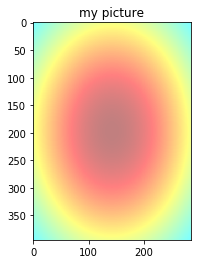

In [24]:
img_with_heatmap = cv2.cvtColor(img_with_heatmap, cv2.COLOR_BGR2RGB)
plt.imshow(img_with_heatmap)
plt.title('my picture')
plt.show()

In [25]:
img_with_heatmap.shape

(395, 286, 3)

In [26]:
var = [] 
for I in range(0, 2):
    new_stuff = torch.randn((4,4))
    var.append(new_stuff.unsqueeze(0))
var_tensor = torch.cat(var)

In [27]:
var_tensor.size()

torch.Size([2, 4, 4])

In [28]:
a = torch.randn((4,4,4))

In [29]:
a[1,:].numpy()

array([[ 0.02763492, -0.5478985 ,  0.307381  , -0.29463962],
       [-1.9232631 , -0.3937568 , -1.0984409 ,  0.3885125 ],
       [-0.66522926, -0.2818536 ,  0.5187074 , -2.192632  ],
       [ 1.0615666 ,  0.332779  , -0.21435244,  0.07778238]],
      dtype=float32)

In [30]:
rgb_image[:]


( 0 ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
           ...             ⋱             ...          
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000

( 1 ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
           ...             ⋱             ...          
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000

( 2 ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
           ...         